# Converting a Keras model to an SNN on Loihi

[![Open In
Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nengo/nengo-dl/blob/master/docs/examples/keras-to-loihi.ipynb)

This notebook describes how to train a network in Keras and convert it to a spiking
neural network (SNN) to run on Loihi. Intel's Loihi chip is a type of "neuromorphic"
hardware—specialized neural network acceleration hardware that uses spike-based
communication like neurons in the brain. In this tutorial, will look at how to set up
our network to target and run on Intel's Loihi chip using the NengoLoihi backend. While
in general the Nengo ecosystem allows users to switch between backends without changes
to their models, we will see how making some Loihi-specific changes during training and
inference allow us to take full advantage of its capabilities.

There are several ways to build SNNs to target NengoLoihi. The [CIFAR-10 Loihi
example](https://www.nengo.ai/nengo-loihi/examples/cifar10-convnet.html) works through
how to build up a deep spiking network to run on Loihi using the standard Nengo and
NengoDL APIs. In NengoDL's [Keras to SNN
example](https://www.nengo.ai/nengo-dl/examples/keras-to-snn.html), we looked at
converting a Keras model to an SNN. Here, we will extend the Keras to SNN example,
tailoring the model for execution on Loihi.

The goal of this notebook is to familiarize you with some of the nuances of running SNNs
on the Loihi, and how to set these up starting from a neural network defined in Keras.
The two focuses in this notebook are on adding a network layer that runs off-chip to
transform the input images into spikes, and training using a Loihi neuron model that
captures the unique behaviour of Loihi's quantized neurons. We'll add the network layer
and train and test with normal ReLU neurons first to see what kind of performance we can
expect without quantization constraints. Then we'll train with the Loihi neurons to
improve implementation performance, and finally we'll run the model on Loihi to measure
the final performance (we use a simulated Loihi if actual Loihi hardware is not
available).

In [1]:
import collections
import warnings

%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import nengo_dl
import numpy as np
import tensorflow as tf

import nengo_loihi

# ignore NengoDL warning about no GPU
warnings.filterwarnings("ignore", message="No GPU", module="nengo_dl")

# The results in this notebook should be reproducible across many random seeds.
# However, some seed values may cause problems, particularly in the `to-spikes` layer
# where poor initialization can result in no information being sent to the chip. We set
# the seed to ensure that good results are reproducible without having to re-train.
np.random.seed(0)
tf.random.set_seed(0)

In this example we'll use the standard [MNIST
dataset](http://yann.lecun.com/exdb/mnist/).

    8192/11490434 [..............................] - ETA: 0s

 4202496/11490434 [=========>....................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


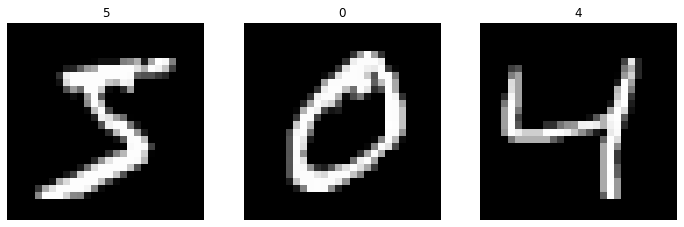

In [2]:
# load in MNIST dataset
(
    (train_images, train_labels),
    (test_images, test_labels),
) = tf.keras.datasets.mnist.load_data()

# flatten images and add time dimension
train_images = train_images.reshape((train_images.shape[0], 1, -1))
train_labels = train_labels.reshape((train_labels.shape[0], 1, -1))
test_images = test_images.reshape((test_images.shape[0], 1, -1))
test_labels = test_labels.reshape((test_labels.shape[0], 1, -1))

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(np.reshape(train_images[i], (28, 28)), cmap="gray")
    plt.axis("off")
    plt.title(str(train_labels[i, 0, 0]))

## Implementing the network

We will start with the same network structure used in the [Keras to SNN
example](https://www.nengo.ai/nengo-dl/examples/keras-to-snn.html): Two convolutional
layers and a dense layer.

The only way to communicate with the Loihi is by sending spikes. Usually, when we have a
model that we want to run on neuromorphic hardware, we want the whole model that we've
defined to run on the hardware. Communicating with Loihi, however, requires that we have
at least one layer that runs *off*-chip to convert the input signal to spikes to send to
the rest of the model running on Loihi.

We'll add a `Conv2D` layer to run off-chip and convert the input signal to spikes. This
could also be an `Activation` layer. The advantage to the `Activation` layer is that it
adds no extra parameters and minimizes off-chip computations. The `Conv2D` layer uses a
few parameters, and requires a bit more off-chip computation, but gives the network much
more flexibility as to how pixels are converted to spikes. An `Activation` layer would
likely work well for simple images like MNIST, but for more complex images (e.g. with
more than one color channel, or a wider range of intensity values) the flexibility of
the `Conv2D` layer is important. We avoid layers like the `Dense` layer, as it
significantly increases both the number of parameters and the number of computations
that have to be run off-chip.

On the output side of the network, we now have to worry about how many neurons are in
the last layer run on the chip. We are limited in how many neurons we can record from on
the board, so we add a `Dense` layer with 100 neurons between the last `Conv2D` layer
and our 10-dimensional `Dense` output layer (which runs off-chip). This way, we only
have to record from 100 neurons, rather than the 2,304 neurons we would need to record
from if we connected directly from the last `Conv2D` layer to the 10-dimensional output.
An added benefit is that the amount of off-chip computation is reduced, since the number
of weights used by the off-chip output layer is 100 x 10 instead of 2304 x 10.

In [3]:
inp = tf.keras.Input(shape=(28, 28, 1), name="input")

# transform input signal to spikes using trainable 1x1 convolutional layer
to_spikes_layer = tf.keras.layers.Conv2D(
    filters=3,  # 3 neurons per pixel
    kernel_size=1,
    strides=1,
    activation=tf.nn.relu,
    use_bias=False,
    name="to-spikes",
)
to_spikes = to_spikes_layer(inp)

# on-chip convolutional layers
conv0_layer = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=2,
    activation=tf.nn.relu,
    use_bias=False,
    name="conv0",
)
conv0 = conv0_layer(to_spikes)

conv1_layer = tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=2,
    activation=tf.nn.relu,
    use_bias=False,
    name="conv1",
)
conv1 = conv1_layer(conv0)

flatten = tf.keras.layers.Flatten(name="flatten")(conv1)

dense0_layer = tf.keras.layers.Dense(units=100, activation=tf.nn.relu, name="dense0")
dense0 = dense0_layer(flatten)

# since this final output layer has no activation function,
# it will be converted to a `nengo.Node` and run off-chip
dense1 = tf.keras.layers.Dense(units=10, name="dense1")(dense0)

model = tf.keras.Model(inputs=inp, outputs=dense1)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
to-spikes (Conv2D)           (None, 28, 28, 3)         3         
_________________________________________________________________
conv0 (Conv2D)               (None, 13, 13, 32)        864       
_________________________________________________________________
conv1 (Conv2D)               (None, 6, 6, 64)          18432     
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense0 (Dense)               (None, 100)               230500    
_________________________________________________________________
dense1 (Dense)               (None, 10)               

### Training the networks

As in the Keras-to-SNN notebook, once we create our model we'll use the NengoDL
Converter to translate it into a Nengo network, and then we'll train.

In [4]:
def train(params_file="./keras_to_loihi_params", epochs=1, **kwargs):
    converter = nengo_dl.Converter(model, **kwargs)

    with nengo_dl.Simulator(converter.net, seed=0, minibatch_size=200) as sim:
        sim.compile(
            optimizer=tf.optimizers.RMSprop(0.001),
            loss={
                converter.outputs[dense1]: tf.losses.SparseCategoricalCrossentropy(
                    from_logits=True
                )
            },
            metrics={converter.outputs[dense1]: tf.metrics.sparse_categorical_accuracy},
        )
        sim.fit(
            {converter.inputs[inp]: train_images},
            {converter.outputs[dense1]: train_labels},
            epochs=epochs,
        )

        # save the parameters to file
        sim.save_params(params_file)

In [5]:
# train this network with normal ReLU neurons
train(
    epochs=2,
    swap_activations={tf.nn.relu: nengo.RectifiedLinear()},
)

|                     Building network (0%)                    | ETA:  --:--:--

|########             Building network (13%)                     | ETA: 0:00:00

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|###           Constructing graph: build stage (5%)              | ETA: 0:00:01

|##############Constructing graph: build stage (88%)#####        | ETA: 0:00:00

|  #                      Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Epoch 1/2


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|###           Constructing graph: build stage (5%)              | ETA: 0:00:00

|##############Constructing graph: build stage (88%)#####        | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|###           Constructing graph: build stage (5%)              | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

  1/300 [..............................] - ETA: 0s - loss: 2.8263 - probe_loss: 2.8263 - probe_sparse_categorical_accuracy: 0.0450

  2/300 [..............................] - ETA: 11s - loss: 2.9245 - probe_loss: 2.9245 - probe_sparse_categorical_accuracy: 0.1325

  3/300 [..............................] - ETA: 14s - loss: 2.5426 - probe_loss: 2.5426 - probe_sparse_categorical_accuracy: 0.2317

  4/300 [..............................] - ETA: 16s - loss: 2.2379 - probe_loss: 2.2379 - probe_sparse_categorical_accuracy: 0.3275

  5/300 [..............................] - ETA: 17s - loss: 1.9964 - probe_loss: 1.9964 - probe_sparse_categorical_accuracy: 0.3960

  6/300 [..............................] - ETA: 17s - loss: 1.8518 - probe_loss: 1.8518 - probe_sparse_categorical_accuracy: 0.4450

  7/300 [..............................] - ETA: 18s - loss: 1.7335 - probe_loss: 1.7335 - probe_sparse_categorical_accuracy: 0.4779

  8/300 [..............................] - ETA: 18s - loss: 1.6285 - probe_loss: 1.6285 - probe_sparse_categorical_accuracy: 0.5063

  9/300 [..............................] - ETA: 19s - loss: 1.5206 - probe_loss: 1.5206 - probe_sparse_categorical_accuracy: 0.5417

 10/300 [>.............................] - ETA: 19s - loss: 1.4260 - probe_loss: 1.4260 - probe_sparse_categorical_accuracy: 0.5690

 11/300 [>.............................] - ETA: 19s - loss: 1.3486 - probe_loss: 1.3486 - probe_sparse_categorical_accuracy: 0.5936

 12/300 [>.............................] - ETA: 19s - loss: 1.2835 - probe_loss: 1.2835 - probe_sparse_categorical_accuracy: 0.6117

 13/300 [>.............................] - ETA: 19s - loss: 1.2169 - probe_loss: 1.2169 - probe_sparse_categorical_accuracy: 0.6312

 14/300 [>.............................] - ETA: 19s - loss: 1.1587 - probe_loss: 1.1587 - probe_sparse_categorical_accuracy: 0.6493

 15/300 [>.............................] - ETA: 19s - loss: 1.1245 - probe_loss: 1.1245 - probe_sparse_categorical_accuracy: 0.6597

 16/300 [>.............................] - ETA: 19s - loss: 1.1077 - probe_loss: 1.1077 - probe_sparse_categorical_accuracy: 0.6681

 17/300 [>.............................] - ETA: 19s - loss: 1.0686 - probe_loss: 1.0686 - probe_sparse_categorical_accuracy: 0.6797

 18/300 [>.............................] - ETA: 19s - loss: 1.0263 - probe_loss: 1.0263 - probe_sparse_categorical_accuracy: 0.6928

 19/300 [>.............................] - ETA: 19s - loss: 0.9866 - probe_loss: 0.9866 - probe_sparse_categorical_accuracy: 0.7058

 20/300 [=>............................] - ETA: 19s - loss: 0.9589 - probe_loss: 0.9589 - probe_sparse_categorical_accuracy: 0.7143

 21/300 [=>............................] - ETA: 19s - loss: 0.9302 - probe_loss: 0.9302 - probe_sparse_categorical_accuracy: 0.7236

 22/300 [=>............................] - ETA: 19s - loss: 0.9025 - probe_loss: 0.9025 - probe_sparse_categorical_accuracy: 0.7307

 23/300 [=>............................] - ETA: 19s - loss: 0.8814 - probe_loss: 0.8814 - probe_sparse_categorical_accuracy: 0.7370

 24/300 [=>............................] - ETA: 18s - loss: 0.8585 - probe_loss: 0.8585 - probe_sparse_categorical_accuracy: 0.7435

 25/300 [=>............................] - ETA: 18s - loss: 0.8416 - probe_loss: 0.8416 - probe_sparse_categorical_accuracy: 0.7490

 26/300 [=>............................] - ETA: 18s - loss: 0.8233 - probe_loss: 0.8233 - probe_sparse_categorical_accuracy: 0.7531

 27/300 [=>............................] - ETA: 18s - loss: 0.8046 - probe_loss: 0.8046 - probe_sparse_categorical_accuracy: 0.7591

 28/300 [=>............................] - ETA: 18s - loss: 0.7877 - probe_loss: 0.7877 - probe_sparse_categorical_accuracy: 0.7646

 29/300 [=>............................] - ETA: 18s - loss: 0.7687 - probe_loss: 0.7687 - probe_sparse_categorical_accuracy: 0.7700

 30/300 [==>...........................] - ETA: 18s - loss: 0.7526 - probe_loss: 0.7526 - probe_sparse_categorical_accuracy: 0.7757

 31/300 [==>...........................] - ETA: 18s - loss: 0.7381 - probe_loss: 0.7381 - probe_sparse_categorical_accuracy: 0.7808

 32/300 [==>...........................] - ETA: 18s - loss: 0.7251 - probe_loss: 0.7251 - probe_sparse_categorical_accuracy: 0.7853

 33/300 [==>...........................] - ETA: 18s - loss: 0.7135 - probe_loss: 0.7135 - probe_sparse_categorical_accuracy: 0.7894

 34/300 [==>...........................] - ETA: 18s - loss: 0.6998 - probe_loss: 0.6998 - probe_sparse_categorical_accuracy: 0.7934

 35/300 [==>...........................] - ETA: 18s - loss: 0.6880 - probe_loss: 0.6880 - probe_sparse_categorical_accuracy: 0.7966

 36/300 [==>...........................] - ETA: 18s - loss: 0.6759 - probe_loss: 0.6759 - probe_sparse_categorical_accuracy: 0.8000

 37/300 [==>...........................] - ETA: 17s - loss: 0.6652 - probe_loss: 0.6652 - probe_sparse_categorical_accuracy: 0.8034

 38/300 [==>...........................] - ETA: 17s - loss: 0.6534 - probe_loss: 0.6534 - probe_sparse_categorical_accuracy: 0.8070

 39/300 [==>...........................] - ETA: 17s - loss: 0.6396 - probe_loss: 0.6396 - probe_sparse_categorical_accuracy: 0.8110

 40/300 [===>..........................] - ETA: 17s - loss: 0.6291 - probe_loss: 0.6291 - probe_sparse_categorical_accuracy: 0.8141

 41/300 [===>..........................] - ETA: 17s - loss: 0.6210 - probe_loss: 0.6210 - probe_sparse_categorical_accuracy: 0.8161

 42/300 [===>..........................] - ETA: 17s - loss: 0.6161 - probe_loss: 0.6161 - probe_sparse_categorical_accuracy: 0.8175

 43/300 [===>..........................] - ETA: 17s - loss: 0.6109 - probe_loss: 0.6109 - probe_sparse_categorical_accuracy: 0.8190

 44/300 [===>..........................] - ETA: 17s - loss: 0.6030 - probe_loss: 0.6030 - probe_sparse_categorical_accuracy: 0.8210

 45/300 [===>..........................] - ETA: 17s - loss: 0.5957 - probe_loss: 0.5957 - probe_sparse_categorical_accuracy: 0.8231

 46/300 [===>..........................] - ETA: 17s - loss: 0.5885 - probe_loss: 0.5885 - probe_sparse_categorical_accuracy: 0.8250

 47/300 [===>..........................] - ETA: 17s - loss: 0.5797 - probe_loss: 0.5797 - probe_sparse_categorical_accuracy: 0.8274

 48/300 [===>..........................] - ETA: 17s - loss: 0.5729 - probe_loss: 0.5729 - probe_sparse_categorical_accuracy: 0.8299

 49/300 [===>..........................] - ETA: 17s - loss: 0.5644 - probe_loss: 0.5644 - probe_sparse_categorical_accuracy: 0.8324

 50/300 [====>.........................] - ETA: 16s - loss: 0.5568 - probe_loss: 0.5568 - probe_sparse_categorical_accuracy: 0.8346

 51/300 [====>.........................] - ETA: 16s - loss: 0.5496 - probe_loss: 0.5496 - probe_sparse_categorical_accuracy: 0.8370

 52/300 [====>.........................] - ETA: 16s - loss: 0.5436 - probe_loss: 0.5436 - probe_sparse_categorical_accuracy: 0.8386

 53/300 [====>.........................] - ETA: 16s - loss: 0.5360 - probe_loss: 0.5360 - probe_sparse_categorical_accuracy: 0.8408

 54/300 [====>.........................] - ETA: 16s - loss: 0.5302 - probe_loss: 0.5302 - probe_sparse_categorical_accuracy: 0.8427

 55/300 [====>.........................] - ETA: 16s - loss: 0.5252 - probe_loss: 0.5252 - probe_sparse_categorical_accuracy: 0.8443

 56/300 [====>.........................] - ETA: 16s - loss: 0.5184 - probe_loss: 0.5184 - probe_sparse_categorical_accuracy: 0.8461

 57/300 [====>.........................] - ETA: 16s - loss: 0.5125 - probe_loss: 0.5125 - probe_sparse_categorical_accuracy: 0.8475

 58/300 [====>.........................] - ETA: 16s - loss: 0.5091 - probe_loss: 0.5091 - probe_sparse_categorical_accuracy: 0.8486

 59/300 [====>.........................] - ETA: 16s - loss: 0.5034 - probe_loss: 0.5034 - probe_sparse_categorical_accuracy: 0.8504

 60/300 [=====>........................] - ETA: 16s - loss: 0.4975 - probe_loss: 0.4975 - probe_sparse_categorical_accuracy: 0.8522

 61/300 [=====>........................] - ETA: 16s - loss: 0.4918 - probe_loss: 0.4918 - probe_sparse_categorical_accuracy: 0.8541

 62/300 [=====>........................] - ETA: 16s - loss: 0.4864 - probe_loss: 0.4864 - probe_sparse_categorical_accuracy: 0.8558

 63/300 [=====>........................] - ETA: 16s - loss: 0.4814 - probe_loss: 0.4814 - probe_sparse_categorical_accuracy: 0.8574

 64/300 [=====>........................] - ETA: 16s - loss: 0.4761 - probe_loss: 0.4761 - probe_sparse_categorical_accuracy: 0.8588

 65/300 [=====>........................] - ETA: 16s - loss: 0.4713 - probe_loss: 0.4713 - probe_sparse_categorical_accuracy: 0.8604

 66/300 [=====>........................] - ETA: 15s - loss: 0.4667 - probe_loss: 0.4667 - probe_sparse_categorical_accuracy: 0.8614

 67/300 [=====>........................] - ETA: 15s - loss: 0.4612 - probe_loss: 0.4612 - probe_sparse_categorical_accuracy: 0.8631

 68/300 [=====>........................] - ETA: 15s - loss: 0.4572 - probe_loss: 0.4572 - probe_sparse_categorical_accuracy: 0.8643

 69/300 [=====>........................] - ETA: 15s - loss: 0.4530 - probe_loss: 0.4530 - probe_sparse_categorical_accuracy: 0.8656

 70/300 [======>.......................] - ETA: 15s - loss: 0.4486 - probe_loss: 0.4486 - probe_sparse_categorical_accuracy: 0.8667

 71/300 [======>.......................] - ETA: 15s - loss: 0.4432 - probe_loss: 0.4432 - probe_sparse_categorical_accuracy: 0.8682

 72/300 [======>.......................] - ETA: 15s - loss: 0.4394 - probe_loss: 0.4394 - probe_sparse_categorical_accuracy: 0.8694

 73/300 [======>.......................] - ETA: 15s - loss: 0.4353 - probe_loss: 0.4353 - probe_sparse_categorical_accuracy: 0.8705

 74/300 [======>.......................] - ETA: 15s - loss: 0.4316 - probe_loss: 0.4316 - probe_sparse_categorical_accuracy: 0.8715

 75/300 [======>.......................] - ETA: 15s - loss: 0.4274 - probe_loss: 0.4274 - probe_sparse_categorical_accuracy: 0.8725

 76/300 [======>.......................] - ETA: 15s - loss: 0.4230 - probe_loss: 0.4230 - probe_sparse_categorical_accuracy: 0.8739

 77/300 [======>.......................] - ETA: 15s - loss: 0.4188 - probe_loss: 0.4188 - probe_sparse_categorical_accuracy: 0.8751

 78/300 [======>.......................] - ETA: 15s - loss: 0.4148 - probe_loss: 0.4148 - probe_sparse_categorical_accuracy: 0.8764

 79/300 [======>.......................] - ETA: 15s - loss: 0.4110 - probe_loss: 0.4110 - probe_sparse_categorical_accuracy: 0.8776

 80/300 [=======>......................] - ETA: 15s - loss: 0.4066 - probe_loss: 0.4066 - probe_sparse_categorical_accuracy: 0.8787

 81/300 [=======>......................] - ETA: 14s - loss: 0.4038 - probe_loss: 0.4038 - probe_sparse_categorical_accuracy: 0.8797

 82/300 [=======>......................] - ETA: 14s - loss: 0.4014 - probe_loss: 0.4014 - probe_sparse_categorical_accuracy: 0.8806

 83/300 [=======>......................] - ETA: 14s - loss: 0.3983 - probe_loss: 0.3983 - probe_sparse_categorical_accuracy: 0.8813

 84/300 [=======>......................] - ETA: 14s - loss: 0.3954 - probe_loss: 0.3954 - probe_sparse_categorical_accuracy: 0.8823

 85/300 [=======>......................] - ETA: 14s - loss: 0.3918 - probe_loss: 0.3918 - probe_sparse_categorical_accuracy: 0.8834

 86/300 [=======>......................] - ETA: 14s - loss: 0.3886 - probe_loss: 0.3886 - probe_sparse_categorical_accuracy: 0.8843

 87/300 [=======>......................] - ETA: 14s - loss: 0.3863 - probe_loss: 0.3863 - probe_sparse_categorical_accuracy: 0.8851

 88/300 [=======>......................] - ETA: 14s - loss: 0.3844 - probe_loss: 0.3844 - probe_sparse_categorical_accuracy: 0.8855

 89/300 [=======>......................] - ETA: 14s - loss: 0.3816 - probe_loss: 0.3816 - probe_sparse_categorical_accuracy: 0.8863

 90/300 [========>.....................] - ETA: 14s - loss: 0.3792 - probe_loss: 0.3792 - probe_sparse_categorical_accuracy: 0.8871

 91/300 [========>.....................] - ETA: 14s - loss: 0.3769 - probe_loss: 0.3769 - probe_sparse_categorical_accuracy: 0.8876

 92/300 [========>.....................] - ETA: 14s - loss: 0.3757 - probe_loss: 0.3757 - probe_sparse_categorical_accuracy: 0.8881

 93/300 [========>.....................] - ETA: 14s - loss: 0.3731 - probe_loss: 0.3731 - probe_sparse_categorical_accuracy: 0.8888

 94/300 [========>.....................] - ETA: 13s - loss: 0.3710 - probe_loss: 0.3710 - probe_sparse_categorical_accuracy: 0.8893

 95/300 [========>.....................] - ETA: 13s - loss: 0.3692 - probe_loss: 0.3692 - probe_sparse_categorical_accuracy: 0.8897

 96/300 [========>.....................] - ETA: 13s - loss: 0.3668 - probe_loss: 0.3668 - probe_sparse_categorical_accuracy: 0.8905

 97/300 [========>.....................] - ETA: 13s - loss: 0.3636 - probe_loss: 0.3636 - probe_sparse_categorical_accuracy: 0.8914

 98/300 [========>.....................] - ETA: 13s - loss: 0.3615 - probe_loss: 0.3615 - probe_sparse_categorical_accuracy: 0.8921

 99/300 [========>.....................] - ETA: 13s - loss: 0.3589 - probe_loss: 0.3589 - probe_sparse_categorical_accuracy: 0.8929

100/300 [=========>....................] - ETA: 13s - loss: 0.3559 - probe_loss: 0.3559 - probe_sparse_categorical_accuracy: 0.8936

101/300 [=========>....................] - ETA: 13s - loss: 0.3545 - probe_loss: 0.3545 - probe_sparse_categorical_accuracy: 0.8942

102/300 [=========>....................] - ETA: 13s - loss: 0.3518 - probe_loss: 0.3518 - probe_sparse_categorical_accuracy: 0.8950

103/300 [=========>....................] - ETA: 13s - loss: 0.3500 - probe_loss: 0.3500 - probe_sparse_categorical_accuracy: 0.8956

104/300 [=========>....................] - ETA: 13s - loss: 0.3480 - probe_loss: 0.3480 - probe_sparse_categorical_accuracy: 0.8961

105/300 [=========>....................] - ETA: 13s - loss: 0.3463 - probe_loss: 0.3463 - probe_sparse_categorical_accuracy: 0.8964

106/300 [=========>....................] - ETA: 13s - loss: 0.3450 - probe_loss: 0.3450 - probe_sparse_categorical_accuracy: 0.8968

107/300 [=========>....................] - ETA: 13s - loss: 0.3426 - probe_loss: 0.3426 - probe_sparse_categorical_accuracy: 0.8974

108/300 [=========>....................] - ETA: 13s - loss: 0.3402 - probe_loss: 0.3402 - probe_sparse_categorical_accuracy: 0.8981

109/300 [=========>....................] - ETA: 12s - loss: 0.3378 - probe_loss: 0.3378 - probe_sparse_categorical_accuracy: 0.8988

110/300 [==========>...................] - ETA: 12s - loss: 0.3366 - probe_loss: 0.3366 - probe_sparse_categorical_accuracy: 0.8991

111/300 [==========>...................] - ETA: 12s - loss: 0.3343 - probe_loss: 0.3343 - probe_sparse_categorical_accuracy: 0.8999

112/300 [==========>...................] - ETA: 12s - loss: 0.3328 - probe_loss: 0.3328 - probe_sparse_categorical_accuracy: 0.9005

113/300 [==========>...................] - ETA: 12s - loss: 0.3314 - probe_loss: 0.3314 - probe_sparse_categorical_accuracy: 0.9009

114/300 [==========>...................] - ETA: 12s - loss: 0.3289 - probe_loss: 0.3289 - probe_sparse_categorical_accuracy: 0.9017

115/300 [==========>...................] - ETA: 12s - loss: 0.3267 - probe_loss: 0.3267 - probe_sparse_categorical_accuracy: 0.9023

116/300 [==========>...................] - ETA: 12s - loss: 0.3248 - probe_loss: 0.3248 - probe_sparse_categorical_accuracy: 0.9028

117/300 [==========>...................] - ETA: 12s - loss: 0.3232 - probe_loss: 0.3232 - probe_sparse_categorical_accuracy: 0.9032

118/300 [==========>...................] - ETA: 12s - loss: 0.3218 - probe_loss: 0.3218 - probe_sparse_categorical_accuracy: 0.9039

119/300 [==========>...................] - ETA: 12s - loss: 0.3200 - probe_loss: 0.3200 - probe_sparse_categorical_accuracy: 0.9044

120/300 [===========>..................] - ETA: 12s - loss: 0.3182 - probe_loss: 0.3182 - probe_sparse_categorical_accuracy: 0.9049

121/300 [===========>..................] - ETA: 12s - loss: 0.3167 - probe_loss: 0.3167 - probe_sparse_categorical_accuracy: 0.9052

122/300 [===========>..................] - ETA: 12s - loss: 0.3147 - probe_loss: 0.3147 - probe_sparse_categorical_accuracy: 0.9059

123/300 [===========>..................] - ETA: 12s - loss: 0.3130 - probe_loss: 0.3130 - probe_sparse_categorical_accuracy: 0.9064

124/300 [===========>..................] - ETA: 12s - loss: 0.3112 - probe_loss: 0.3112 - probe_sparse_categorical_accuracy: 0.9068

125/300 [===========>..................] - ETA: 11s - loss: 0.3092 - probe_loss: 0.3092 - probe_sparse_categorical_accuracy: 0.9074

126/300 [===========>..................] - ETA: 11s - loss: 0.3070 - probe_loss: 0.3070 - probe_sparse_categorical_accuracy: 0.9080

127/300 [===========>..................] - ETA: 11s - loss: 0.3055 - probe_loss: 0.3055 - probe_sparse_categorical_accuracy: 0.9084

128/300 [===========>..................] - ETA: 11s - loss: 0.3039 - probe_loss: 0.3039 - probe_sparse_categorical_accuracy: 0.9089

129/300 [===========>..................] - ETA: 11s - loss: 0.3030 - probe_loss: 0.3030 - probe_sparse_categorical_accuracy: 0.9091

130/300 [============>.................] - ETA: 11s - loss: 0.3013 - probe_loss: 0.3013 - probe_sparse_categorical_accuracy: 0.9096

131/300 [============>.................] - ETA: 11s - loss: 0.2999 - probe_loss: 0.2999 - probe_sparse_categorical_accuracy: 0.9101

132/300 [============>.................] - ETA: 11s - loss: 0.2986 - probe_loss: 0.2986 - probe_sparse_categorical_accuracy: 0.9106

133/300 [============>.................] - ETA: 11s - loss: 0.2971 - probe_loss: 0.2971 - probe_sparse_categorical_accuracy: 0.9111

134/300 [============>.................] - ETA: 11s - loss: 0.2962 - probe_loss: 0.2962 - probe_sparse_categorical_accuracy: 0.9112

135/300 [============>.................] - ETA: 11s - loss: 0.2944 - probe_loss: 0.2944 - probe_sparse_categorical_accuracy: 0.9118

136/300 [============>.................] - ETA: 11s - loss: 0.2927 - probe_loss: 0.2927 - probe_sparse_categorical_accuracy: 0.9123

137/300 [============>.................] - ETA: 11s - loss: 0.2909 - probe_loss: 0.2909 - probe_sparse_categorical_accuracy: 0.9128

138/300 [============>.................] - ETA: 11s - loss: 0.2895 - probe_loss: 0.2895 - probe_sparse_categorical_accuracy: 0.9133

139/300 [============>.................] - ETA: 11s - loss: 0.2877 - probe_loss: 0.2877 - probe_sparse_categorical_accuracy: 0.9137

140/300 [=============>................] - ETA: 10s - loss: 0.2870 - probe_loss: 0.2870 - probe_sparse_categorical_accuracy: 0.9140

141/300 [=============>................] - ETA: 10s - loss: 0.2859 - probe_loss: 0.2859 - probe_sparse_categorical_accuracy: 0.9144

142/300 [=============>................] - ETA: 10s - loss: 0.2851 - probe_loss: 0.2851 - probe_sparse_categorical_accuracy: 0.9146

143/300 [=============>................] - ETA: 10s - loss: 0.2838 - probe_loss: 0.2838 - probe_sparse_categorical_accuracy: 0.9150

144/300 [=============>................] - ETA: 10s - loss: 0.2829 - probe_loss: 0.2829 - probe_sparse_categorical_accuracy: 0.9153

145/300 [=============>................] - ETA: 10s - loss: 0.2819 - probe_loss: 0.2819 - probe_sparse_categorical_accuracy: 0.9155

146/300 [=============>................] - ETA: 10s - loss: 0.2814 - probe_loss: 0.2814 - probe_sparse_categorical_accuracy: 0.9158

147/300 [=============>................] - ETA: 10s - loss: 0.2804 - probe_loss: 0.2804 - probe_sparse_categorical_accuracy: 0.9160

148/300 [=============>................] - ETA: 10s - loss: 0.2792 - probe_loss: 0.2792 - probe_sparse_categorical_accuracy: 0.9164

149/300 [=============>................] - ETA: 10s - loss: 0.2776 - probe_loss: 0.2776 - probe_sparse_categorical_accuracy: 0.9169

150/300 [==============>...............] - ETA: 10s - loss: 0.2761 - probe_loss: 0.2761 - probe_sparse_categorical_accuracy: 0.9173

151/300 [==============>...............] - ETA: 10s - loss: 0.2749 - probe_loss: 0.2749 - probe_sparse_categorical_accuracy: 0.9176

152/300 [==============>...............] - ETA: 10s - loss: 0.2735 - probe_loss: 0.2735 - probe_sparse_categorical_accuracy: 0.9180

153/300 [==============>...............] - ETA: 10s - loss: 0.2726 - probe_loss: 0.2726 - probe_sparse_categorical_accuracy: 0.9184

154/300 [==============>...............] - ETA: 9s - loss: 0.2714 - probe_loss: 0.2714 - probe_sparse_categorical_accuracy: 0.9188 

155/300 [==============>...............] - ETA: 9s - loss: 0.2703 - probe_loss: 0.2703 - probe_sparse_categorical_accuracy: 0.9190

156/300 [==============>...............] - ETA: 9s - loss: 0.2698 - probe_loss: 0.2698 - probe_sparse_categorical_accuracy: 0.9192

157/300 [==============>...............] - ETA: 9s - loss: 0.2683 - probe_loss: 0.2683 - probe_sparse_categorical_accuracy: 0.9196

158/300 [==============>...............] - ETA: 9s - loss: 0.2673 - probe_loss: 0.2673 - probe_sparse_categorical_accuracy: 0.9199

159/300 [==============>...............] - ETA: 9s - loss: 0.2666 - probe_loss: 0.2666 - probe_sparse_categorical_accuracy: 0.9201

160/300 [===============>..............] - ETA: 9s - loss: 0.2654 - probe_loss: 0.2654 - probe_sparse_categorical_accuracy: 0.9204

161/300 [===============>..............] - ETA: 9s - loss: 0.2640 - probe_loss: 0.2640 - probe_sparse_categorical_accuracy: 0.9208

162/300 [===============>..............] - ETA: 9s - loss: 0.2628 - probe_loss: 0.2628 - probe_sparse_categorical_accuracy: 0.9212

163/300 [===============>..............] - ETA: 9s - loss: 0.2622 - probe_loss: 0.2622 - probe_sparse_categorical_accuracy: 0.9215

164/300 [===============>..............] - ETA: 9s - loss: 0.2612 - probe_loss: 0.2612 - probe_sparse_categorical_accuracy: 0.9218

165/300 [===============>..............] - ETA: 9s - loss: 0.2601 - probe_loss: 0.2601 - probe_sparse_categorical_accuracy: 0.9221

166/300 [===============>..............] - ETA: 9s - loss: 0.2588 - probe_loss: 0.2588 - probe_sparse_categorical_accuracy: 0.9224

167/300 [===============>..............] - ETA: 9s - loss: 0.2576 - probe_loss: 0.2576 - probe_sparse_categorical_accuracy: 0.9228

168/300 [===============>..............] - ETA: 9s - loss: 0.2567 - probe_loss: 0.2567 - probe_sparse_categorical_accuracy: 0.9230

169/300 [===============>..............] - ETA: 8s - loss: 0.2556 - probe_loss: 0.2556 - probe_sparse_categorical_accuracy: 0.9233

170/300 [================>.............] - ETA: 8s - loss: 0.2546 - probe_loss: 0.2546 - probe_sparse_categorical_accuracy: 0.9236

171/300 [================>.............] - ETA: 8s - loss: 0.2535 - probe_loss: 0.2535 - probe_sparse_categorical_accuracy: 0.9240

172/300 [================>.............] - ETA: 8s - loss: 0.2523 - probe_loss: 0.2523 - probe_sparse_categorical_accuracy: 0.9243

173/300 [================>.............] - ETA: 8s - loss: 0.2513 - probe_loss: 0.2513 - probe_sparse_categorical_accuracy: 0.9247

174/300 [================>.............] - ETA: 8s - loss: 0.2505 - probe_loss: 0.2505 - probe_sparse_categorical_accuracy: 0.9249

175/300 [================>.............] - ETA: 8s - loss: 0.2496 - probe_loss: 0.2496 - probe_sparse_categorical_accuracy: 0.9251

176/300 [================>.............] - ETA: 8s - loss: 0.2489 - probe_loss: 0.2489 - probe_sparse_categorical_accuracy: 0.9253

177/300 [================>.............] - ETA: 8s - loss: 0.2480 - probe_loss: 0.2480 - probe_sparse_categorical_accuracy: 0.9256

178/300 [================>.............] - ETA: 8s - loss: 0.2475 - probe_loss: 0.2475 - probe_sparse_categorical_accuracy: 0.9258

179/300 [================>.............] - ETA: 8s - loss: 0.2469 - probe_loss: 0.2469 - probe_sparse_categorical_accuracy: 0.9260

180/300 [=================>............] - ETA: 8s - loss: 0.2459 - probe_loss: 0.2459 - probe_sparse_categorical_accuracy: 0.9263

181/300 [=================>............] - ETA: 8s - loss: 0.2452 - probe_loss: 0.2452 - probe_sparse_categorical_accuracy: 0.9265

182/300 [=================>............] - ETA: 8s - loss: 0.2443 - probe_loss: 0.2443 - probe_sparse_categorical_accuracy: 0.9268

183/300 [=================>............] - ETA: 7s - loss: 0.2436 - probe_loss: 0.2436 - probe_sparse_categorical_accuracy: 0.9269

184/300 [=================>............] - ETA: 7s - loss: 0.2428 - probe_loss: 0.2428 - probe_sparse_categorical_accuracy: 0.9272

185/300 [=================>............] - ETA: 7s - loss: 0.2419 - probe_loss: 0.2419 - probe_sparse_categorical_accuracy: 0.9274

186/300 [=================>............] - ETA: 7s - loss: 0.2411 - probe_loss: 0.2411 - probe_sparse_categorical_accuracy: 0.9276

187/300 [=================>............] - ETA: 7s - loss: 0.2404 - probe_loss: 0.2404 - probe_sparse_categorical_accuracy: 0.9278

188/300 [=================>............] - ETA: 7s - loss: 0.2396 - probe_loss: 0.2396 - probe_sparse_categorical_accuracy: 0.9280

189/300 [=================>............] - ETA: 7s - loss: 0.2389 - probe_loss: 0.2389 - probe_sparse_categorical_accuracy: 0.9282

190/300 [==================>...........] - ETA: 7s - loss: 0.2383 - probe_loss: 0.2383 - probe_sparse_categorical_accuracy: 0.9284

191/300 [==================>...........] - ETA: 7s - loss: 0.2375 - probe_loss: 0.2375 - probe_sparse_categorical_accuracy: 0.9287

192/300 [==================>...........] - ETA: 7s - loss: 0.2366 - probe_loss: 0.2366 - probe_sparse_categorical_accuracy: 0.9290

193/300 [==================>...........] - ETA: 7s - loss: 0.2357 - probe_loss: 0.2357 - probe_sparse_categorical_accuracy: 0.9292

194/300 [==================>...........] - ETA: 7s - loss: 0.2348 - probe_loss: 0.2348 - probe_sparse_categorical_accuracy: 0.9295

195/300 [==================>...........] - ETA: 7s - loss: 0.2340 - probe_loss: 0.2340 - probe_sparse_categorical_accuracy: 0.9297

196/300 [==================>...........] - ETA: 7s - loss: 0.2333 - probe_loss: 0.2333 - probe_sparse_categorical_accuracy: 0.9299

197/300 [==================>...........] - ETA: 7s - loss: 0.2326 - probe_loss: 0.2326 - probe_sparse_categorical_accuracy: 0.9301

198/300 [==================>...........] - ETA: 6s - loss: 0.2318 - probe_loss: 0.2318 - probe_sparse_categorical_accuracy: 0.9302

199/300 [==================>...........] - ETA: 6s - loss: 0.2310 - probe_loss: 0.2310 - probe_sparse_categorical_accuracy: 0.9305

200/300 [===================>..........] - ETA: 6s - loss: 0.2300 - probe_loss: 0.2300 - probe_sparse_categorical_accuracy: 0.9308

201/300 [===================>..........] - ETA: 6s - loss: 0.2292 - probe_loss: 0.2292 - probe_sparse_categorical_accuracy: 0.9310

202/300 [===================>..........] - ETA: 6s - loss: 0.2284 - probe_loss: 0.2284 - probe_sparse_categorical_accuracy: 0.9313

203/300 [===================>..........] - ETA: 6s - loss: 0.2276 - probe_loss: 0.2276 - probe_sparse_categorical_accuracy: 0.9315

204/300 [===================>..........] - ETA: 6s - loss: 0.2272 - probe_loss: 0.2272 - probe_sparse_categorical_accuracy: 0.9316

205/300 [===================>..........] - ETA: 6s - loss: 0.2265 - probe_loss: 0.2265 - probe_sparse_categorical_accuracy: 0.9318

206/300 [===================>..........] - ETA: 6s - loss: 0.2261 - probe_loss: 0.2261 - probe_sparse_categorical_accuracy: 0.9318

207/300 [===================>..........] - ETA: 6s - loss: 0.2253 - probe_loss: 0.2253 - probe_sparse_categorical_accuracy: 0.9321

208/300 [===================>..........] - ETA: 6s - loss: 0.2245 - probe_loss: 0.2245 - probe_sparse_categorical_accuracy: 0.9323

209/300 [===================>..........] - ETA: 6s - loss: 0.2236 - probe_loss: 0.2236 - probe_sparse_categorical_accuracy: 0.9325

210/300 [====================>.........] - ETA: 6s - loss: 0.2230 - probe_loss: 0.2230 - probe_sparse_categorical_accuracy: 0.9327

211/300 [====================>.........] - ETA: 6s - loss: 0.2222 - probe_loss: 0.2222 - probe_sparse_categorical_accuracy: 0.9329

212/300 [====================>.........] - ETA: 5s - loss: 0.2215 - probe_loss: 0.2215 - probe_sparse_categorical_accuracy: 0.9332

213/300 [====================>.........] - ETA: 5s - loss: 0.2210 - probe_loss: 0.2210 - probe_sparse_categorical_accuracy: 0.9333

214/300 [====================>.........] - ETA: 5s - loss: 0.2204 - probe_loss: 0.2204 - probe_sparse_categorical_accuracy: 0.9335

215/300 [====================>.........] - ETA: 5s - loss: 0.2196 - probe_loss: 0.2196 - probe_sparse_categorical_accuracy: 0.9336

216/300 [====================>.........] - ETA: 5s - loss: 0.2190 - probe_loss: 0.2190 - probe_sparse_categorical_accuracy: 0.9339

217/300 [====================>.........] - ETA: 5s - loss: 0.2186 - probe_loss: 0.2186 - probe_sparse_categorical_accuracy: 0.9340

218/300 [====================>.........] - ETA: 5s - loss: 0.2179 - probe_loss: 0.2179 - probe_sparse_categorical_accuracy: 0.9342

219/300 [====================>.........] - ETA: 5s - loss: 0.2172 - probe_loss: 0.2172 - probe_sparse_categorical_accuracy: 0.9344

220/300 [=====================>........] - ETA: 5s - loss: 0.2166 - probe_loss: 0.2166 - probe_sparse_categorical_accuracy: 0.9346

221/300 [=====================>........] - ETA: 5s - loss: 0.2159 - probe_loss: 0.2159 - probe_sparse_categorical_accuracy: 0.9348

222/300 [=====================>........] - ETA: 5s - loss: 0.2154 - probe_loss: 0.2154 - probe_sparse_categorical_accuracy: 0.9349

223/300 [=====================>........] - ETA: 5s - loss: 0.2149 - probe_loss: 0.2149 - probe_sparse_categorical_accuracy: 0.9351

224/300 [=====================>........] - ETA: 5s - loss: 0.2145 - probe_loss: 0.2145 - probe_sparse_categorical_accuracy: 0.9352

225/300 [=====================>........] - ETA: 5s - loss: 0.2140 - probe_loss: 0.2140 - probe_sparse_categorical_accuracy: 0.9354

226/300 [=====================>........] - ETA: 5s - loss: 0.2135 - probe_loss: 0.2135 - probe_sparse_categorical_accuracy: 0.9355

227/300 [=====================>........] - ETA: 4s - loss: 0.2128 - probe_loss: 0.2128 - probe_sparse_categorical_accuracy: 0.9357

228/300 [=====================>........] - ETA: 4s - loss: 0.2120 - probe_loss: 0.2120 - probe_sparse_categorical_accuracy: 0.9360

229/300 [=====================>........] - ETA: 4s - loss: 0.2112 - probe_loss: 0.2112 - probe_sparse_categorical_accuracy: 0.9362

230/300 [======================>.......] - ETA: 4s - loss: 0.2106 - probe_loss: 0.2106 - probe_sparse_categorical_accuracy: 0.9364

231/300 [======================>.......] - ETA: 4s - loss: 0.2099 - probe_loss: 0.2099 - probe_sparse_categorical_accuracy: 0.9366

232/300 [======================>.......] - ETA: 4s - loss: 0.2094 - probe_loss: 0.2094 - probe_sparse_categorical_accuracy: 0.9369

233/300 [======================>.......] - ETA: 4s - loss: 0.2087 - probe_loss: 0.2087 - probe_sparse_categorical_accuracy: 0.9370

234/300 [======================>.......] - ETA: 4s - loss: 0.2081 - probe_loss: 0.2081 - probe_sparse_categorical_accuracy: 0.9372

235/300 [======================>.......] - ETA: 4s - loss: 0.2076 - probe_loss: 0.2076 - probe_sparse_categorical_accuracy: 0.9374

236/300 [======================>.......] - ETA: 4s - loss: 0.2072 - probe_loss: 0.2072 - probe_sparse_categorical_accuracy: 0.9375

237/300 [======================>.......] - ETA: 4s - loss: 0.2065 - probe_loss: 0.2065 - probe_sparse_categorical_accuracy: 0.9378

238/300 [======================>.......] - ETA: 4s - loss: 0.2059 - probe_loss: 0.2059 - probe_sparse_categorical_accuracy: 0.9380

239/300 [======================>.......] - ETA: 4s - loss: 0.2053 - probe_loss: 0.2053 - probe_sparse_categorical_accuracy: 0.9381

240/300 [=======================>......] - ETA: 4s - loss: 0.2047 - probe_loss: 0.2047 - probe_sparse_categorical_accuracy: 0.9383

241/300 [=======================>......] - ETA: 4s - loss: 0.2043 - probe_loss: 0.2043 - probe_sparse_categorical_accuracy: 0.9384

242/300 [=======================>......] - ETA: 3s - loss: 0.2037 - probe_loss: 0.2037 - probe_sparse_categorical_accuracy: 0.9386

243/300 [=======================>......] - ETA: 3s - loss: 0.2032 - probe_loss: 0.2032 - probe_sparse_categorical_accuracy: 0.9388

244/300 [=======================>......] - ETA: 3s - loss: 0.2027 - probe_loss: 0.2027 - probe_sparse_categorical_accuracy: 0.9389

245/300 [=======================>......] - ETA: 3s - loss: 0.2026 - probe_loss: 0.2026 - probe_sparse_categorical_accuracy: 0.9390

246/300 [=======================>......] - ETA: 3s - loss: 0.2027 - probe_loss: 0.2027 - probe_sparse_categorical_accuracy: 0.9389

247/300 [=======================>......] - ETA: 3s - loss: 0.2023 - probe_loss: 0.2023 - probe_sparse_categorical_accuracy: 0.9391

248/300 [=======================>......] - ETA: 3s - loss: 0.2017 - probe_loss: 0.2017 - probe_sparse_categorical_accuracy: 0.9392

249/300 [=======================>......] - ETA: 3s - loss: 0.2013 - probe_loss: 0.2013 - probe_sparse_categorical_accuracy: 0.9393

250/300 [========================>.....] - ETA: 3s - loss: 0.2009 - probe_loss: 0.2009 - probe_sparse_categorical_accuracy: 0.9394

251/300 [========================>.....] - ETA: 3s - loss: 0.2005 - probe_loss: 0.2005 - probe_sparse_categorical_accuracy: 0.9395

252/300 [========================>.....] - ETA: 3s - loss: 0.1999 - probe_loss: 0.1999 - probe_sparse_categorical_accuracy: 0.9397

253/300 [========================>.....] - ETA: 3s - loss: 0.1996 - probe_loss: 0.1996 - probe_sparse_categorical_accuracy: 0.9398

254/300 [========================>.....] - ETA: 3s - loss: 0.1991 - probe_loss: 0.1991 - probe_sparse_categorical_accuracy: 0.9399

255/300 [========================>.....] - ETA: 3s - loss: 0.1985 - probe_loss: 0.1985 - probe_sparse_categorical_accuracy: 0.9401

256/300 [========================>.....] - ETA: 2s - loss: 0.1981 - probe_loss: 0.1981 - probe_sparse_categorical_accuracy: 0.9403

257/300 [========================>.....] - ETA: 2s - loss: 0.1978 - probe_loss: 0.1978 - probe_sparse_categorical_accuracy: 0.9403

258/300 [========================>.....] - ETA: 2s - loss: 0.1974 - probe_loss: 0.1974 - probe_sparse_categorical_accuracy: 0.9404

259/300 [========================>.....] - ETA: 2s - loss: 0.1969 - probe_loss: 0.1969 - probe_sparse_categorical_accuracy: 0.9406

260/300 [=========================>....] - ETA: 2s - loss: 0.1965 - probe_loss: 0.1965 - probe_sparse_categorical_accuracy: 0.9407

261/300 [=========================>....] - ETA: 2s - loss: 0.1961 - probe_loss: 0.1961 - probe_sparse_categorical_accuracy: 0.9407

262/300 [=========================>....] - ETA: 2s - loss: 0.1956 - probe_loss: 0.1956 - probe_sparse_categorical_accuracy: 0.9409

263/300 [=========================>....] - ETA: 2s - loss: 0.1950 - probe_loss: 0.1950 - probe_sparse_categorical_accuracy: 0.9411

264/300 [=========================>....] - ETA: 2s - loss: 0.1945 - probe_loss: 0.1945 - probe_sparse_categorical_accuracy: 0.9412

265/300 [=========================>....] - ETA: 2s - loss: 0.1941 - probe_loss: 0.1941 - probe_sparse_categorical_accuracy: 0.9413

266/300 [=========================>....] - ETA: 2s - loss: 0.1934 - probe_loss: 0.1934 - probe_sparse_categorical_accuracy: 0.9415

267/300 [=========================>....] - ETA: 2s - loss: 0.1932 - probe_loss: 0.1932 - probe_sparse_categorical_accuracy: 0.9416

268/300 [=========================>....] - ETA: 2s - loss: 0.1928 - probe_loss: 0.1928 - probe_sparse_categorical_accuracy: 0.9417

269/300 [=========================>....] - ETA: 2s - loss: 0.1923 - probe_loss: 0.1923 - probe_sparse_categorical_accuracy: 0.9418

270/300 [==========================>...] - ETA: 2s - loss: 0.1917 - probe_loss: 0.1917 - probe_sparse_categorical_accuracy: 0.9420

271/300 [==========================>...] - ETA: 1s - loss: 0.1912 - probe_loss: 0.1912 - probe_sparse_categorical_accuracy: 0.9422

272/300 [==========================>...] - ETA: 1s - loss: 0.1906 - probe_loss: 0.1906 - probe_sparse_categorical_accuracy: 0.9423

273/300 [==========================>...] - ETA: 1s - loss: 0.1902 - probe_loss: 0.1902 - probe_sparse_categorical_accuracy: 0.9424

274/300 [==========================>...] - ETA: 1s - loss: 0.1898 - probe_loss: 0.1898 - probe_sparse_categorical_accuracy: 0.9426

275/300 [==========================>...] - ETA: 1s - loss: 0.1895 - probe_loss: 0.1895 - probe_sparse_categorical_accuracy: 0.9426

276/300 [==========================>...] - ETA: 1s - loss: 0.1891 - probe_loss: 0.1891 - probe_sparse_categorical_accuracy: 0.9428

277/300 [==========================>...] - ETA: 1s - loss: 0.1887 - probe_loss: 0.1887 - probe_sparse_categorical_accuracy: 0.9429

278/300 [==========================>...] - ETA: 1s - loss: 0.1882 - probe_loss: 0.1882 - probe_sparse_categorical_accuracy: 0.9430

279/300 [==========================>...] - ETA: 1s - loss: 0.1877 - probe_loss: 0.1877 - probe_sparse_categorical_accuracy: 0.9431

280/300 [===========================>..] - ETA: 1s - loss: 0.1875 - probe_loss: 0.1875 - probe_sparse_categorical_accuracy: 0.9433



281/300 [===========================>..] - ETA: 1s - loss: 0.1871 - probe_loss: 0.1871 - probe_sparse_categorical_accuracy: 0.9434

282/300 [===========================>..] - ETA: 1s - loss: 0.1866 - probe_loss: 0.1866 - probe_sparse_categorical_accuracy: 0.9436

283/300 [===========================>..] - ETA: 1s - loss: 0.1863 - probe_loss: 0.1863 - probe_sparse_categorical_accuracy: 0.9437

284/300 [===========================>..] - ETA: 1s - loss: 0.1860 - probe_loss: 0.1860 - probe_sparse_categorical_accuracy: 0.9437

285/300 [===========================>..] - ETA: 1s - loss: 0.1857 - probe_loss: 0.1857 - probe_sparse_categorical_accuracy: 0.9438

286/300 [===========================>..] - ETA: 0s - loss: 0.1854 - probe_loss: 0.1854 - probe_sparse_categorical_accuracy: 0.9439

287/300 [===========================>..] - ETA: 0s - loss: 0.1850 - probe_loss: 0.1850 - probe_sparse_categorical_accuracy: 0.9440

288/300 [===========================>..] - ETA: 0s - loss: 0.1846 - probe_loss: 0.1846 - probe_sparse_categorical_accuracy: 0.9441

289/300 [===========================>..] - ETA: 0s - loss: 0.1843 - probe_loss: 0.1843 - probe_sparse_categorical_accuracy: 0.9443

290/300 [============================>.] - ETA: 0s - loss: 0.1839 - probe_loss: 0.1839 - probe_sparse_categorical_accuracy: 0.9444

291/300 [============================>.] - ETA: 0s - loss: 0.1836 - probe_loss: 0.1836 - probe_sparse_categorical_accuracy: 0.9445

292/300 [============================>.] - ETA: 0s - loss: 0.1832 - probe_loss: 0.1832 - probe_sparse_categorical_accuracy: 0.9446

293/300 [============================>.] - ETA: 0s - loss: 0.1827 - probe_loss: 0.1827 - probe_sparse_categorical_accuracy: 0.9448

294/300 [============================>.] - ETA: 0s - loss: 0.1821 - probe_loss: 0.1821 - probe_sparse_categorical_accuracy: 0.9449

295/300 [============================>.] - ETA: 0s - loss: 0.1819 - probe_loss: 0.1819 - probe_sparse_categorical_accuracy: 0.9451

296/300 [============================>.] - ETA: 0s - loss: 0.1815 - probe_loss: 0.1815 - probe_sparse_categorical_accuracy: 0.9451

297/300 [============================>.] - ETA: 0s - loss: 0.1811 - probe_loss: 0.1811 - probe_sparse_categorical_accuracy: 0.9452

298/300 [============================>.] - ETA: 0s - loss: 0.1807 - probe_loss: 0.1807 - probe_sparse_categorical_accuracy: 0.9454

299/300 [============================>.] - ETA: 0s - loss: 0.1802 - probe_loss: 0.1802 - probe_sparse_categorical_accuracy: 0.9455

300/300 [==============================] - ETA: 0s - loss: 0.1799 - probe_loss: 0.1799 - probe_sparse_categorical_accuracy: 0.9456

300/300 [==============================] - 20s 68ms/step - loss: 0.1799 - probe_loss: 0.1799 - probe_sparse_categorical_accuracy: 0.9456


Epoch 2/2


  1/300 [..............................] - ETA: 0s - loss: 0.0239 - probe_loss: 0.0239 - probe_sparse_categorical_accuracy: 0.9900

  2/300 [..............................] - ETA: 10s - loss: 0.0214 - probe_loss: 0.0214 - probe_sparse_categorical_accuracy: 0.9900

  3/300 [..............................] - ETA: 13s - loss: 0.0210 - probe_loss: 0.0210 - probe_sparse_categorical_accuracy: 0.9917

  4/300 [..............................] - ETA: 15s - loss: 0.0232 - probe_loss: 0.0232 - probe_sparse_categorical_accuracy: 0.9912

  5/300 [..............................] - ETA: 16s - loss: 0.0223 - probe_loss: 0.0223 - probe_sparse_categorical_accuracy: 0.9920

  6/300 [..............................] - ETA: 17s - loss: 0.0241 - probe_loss: 0.0241 - probe_sparse_categorical_accuracy: 0.9925

  7/300 [..............................] - ETA: 17s - loss: 0.0241 - probe_loss: 0.0241 - probe_sparse_categorical_accuracy: 0.9929

  8/300 [..............................] - ETA: 17s - loss: 0.0260 - probe_loss: 0.0260 - probe_sparse_categorical_accuracy: 0.9919

  9/300 [..............................] - ETA: 18s - loss: 0.0265 - probe_loss: 0.0265 - probe_sparse_categorical_accuracy: 0.9922

 10/300 [>.............................] - ETA: 18s - loss: 0.0261 - probe_loss: 0.0261 - probe_sparse_categorical_accuracy: 0.9915

 11/300 [>.............................] - ETA: 18s - loss: 0.0278 - probe_loss: 0.0278 - probe_sparse_categorical_accuracy: 0.9909

 12/300 [>.............................] - ETA: 19s - loss: 0.0370 - probe_loss: 0.0370 - probe_sparse_categorical_accuracy: 0.9896

 13/300 [>.............................] - ETA: 19s - loss: 0.0387 - probe_loss: 0.0387 - probe_sparse_categorical_accuracy: 0.9892

 14/300 [>.............................] - ETA: 19s - loss: 0.0402 - probe_loss: 0.0402 - probe_sparse_categorical_accuracy: 0.9886

 15/300 [>.............................] - ETA: 19s - loss: 0.0400 - probe_loss: 0.0400 - probe_sparse_categorical_accuracy: 0.9887

 16/300 [>.............................] - ETA: 19s - loss: 0.0393 - probe_loss: 0.0393 - probe_sparse_categorical_accuracy: 0.9891

 17/300 [>.............................] - ETA: 19s - loss: 0.0412 - probe_loss: 0.0412 - probe_sparse_categorical_accuracy: 0.9888

 18/300 [>.............................] - ETA: 19s - loss: 0.0410 - probe_loss: 0.0410 - probe_sparse_categorical_accuracy: 0.9883

 19/300 [>.............................] - ETA: 19s - loss: 0.0394 - probe_loss: 0.0394 - probe_sparse_categorical_accuracy: 0.9889

 20/300 [=>............................] - ETA: 19s - loss: 0.0390 - probe_loss: 0.0390 - probe_sparse_categorical_accuracy: 0.9893

 21/300 [=>............................] - ETA: 19s - loss: 0.0407 - probe_loss: 0.0407 - probe_sparse_categorical_accuracy: 0.9888

 22/300 [=>............................] - ETA: 18s - loss: 0.0429 - probe_loss: 0.0429 - probe_sparse_categorical_accuracy: 0.9873

 23/300 [=>............................] - ETA: 18s - loss: 0.0424 - probe_loss: 0.0424 - probe_sparse_categorical_accuracy: 0.9874

 24/300 [=>............................] - ETA: 18s - loss: 0.0424 - probe_loss: 0.0424 - probe_sparse_categorical_accuracy: 0.9871

 25/300 [=>............................] - ETA: 18s - loss: 0.0430 - probe_loss: 0.0430 - probe_sparse_categorical_accuracy: 0.9868

 26/300 [=>............................] - ETA: 18s - loss: 0.0443 - probe_loss: 0.0443 - probe_sparse_categorical_accuracy: 0.9863

 27/300 [=>............................] - ETA: 18s - loss: 0.0447 - probe_loss: 0.0447 - probe_sparse_categorical_accuracy: 0.9863

 28/300 [=>............................] - ETA: 18s - loss: 0.0462 - probe_loss: 0.0462 - probe_sparse_categorical_accuracy: 0.9861

 29/300 [=>............................] - ETA: 18s - loss: 0.0455 - probe_loss: 0.0455 - probe_sparse_categorical_accuracy: 0.9862

 30/300 [==>...........................] - ETA: 18s - loss: 0.0451 - probe_loss: 0.0451 - probe_sparse_categorical_accuracy: 0.9862

 31/300 [==>...........................] - ETA: 18s - loss: 0.0464 - probe_loss: 0.0464 - probe_sparse_categorical_accuracy: 0.9861

 32/300 [==>...........................] - ETA: 18s - loss: 0.0457 - probe_loss: 0.0457 - probe_sparse_categorical_accuracy: 0.9862

 33/300 [==>...........................] - ETA: 18s - loss: 0.0456 - probe_loss: 0.0456 - probe_sparse_categorical_accuracy: 0.9864

 34/300 [==>...........................] - ETA: 18s - loss: 0.0447 - probe_loss: 0.0447 - probe_sparse_categorical_accuracy: 0.9868

 35/300 [==>...........................] - ETA: 17s - loss: 0.0448 - probe_loss: 0.0448 - probe_sparse_categorical_accuracy: 0.9867

 36/300 [==>...........................] - ETA: 17s - loss: 0.0447 - probe_loss: 0.0447 - probe_sparse_categorical_accuracy: 0.9868

 37/300 [==>...........................] - ETA: 17s - loss: 0.0442 - probe_loss: 0.0442 - probe_sparse_categorical_accuracy: 0.9869

 38/300 [==>...........................] - ETA: 17s - loss: 0.0436 - probe_loss: 0.0436 - probe_sparse_categorical_accuracy: 0.9871

 39/300 [==>...........................] - ETA: 17s - loss: 0.0431 - probe_loss: 0.0431 - probe_sparse_categorical_accuracy: 0.9873

 40/300 [===>..........................] - ETA: 17s - loss: 0.0459 - probe_loss: 0.0459 - probe_sparse_categorical_accuracy: 0.9869

 41/300 [===>..........................] - ETA: 17s - loss: 0.0457 - probe_loss: 0.0457 - probe_sparse_categorical_accuracy: 0.9868

 42/300 [===>..........................] - ETA: 17s - loss: 0.0457 - probe_loss: 0.0457 - probe_sparse_categorical_accuracy: 0.9867

 43/300 [===>..........................] - ETA: 17s - loss: 0.0466 - probe_loss: 0.0466 - probe_sparse_categorical_accuracy: 0.9863

 44/300 [===>..........................] - ETA: 17s - loss: 0.0463 - probe_loss: 0.0463 - probe_sparse_categorical_accuracy: 0.9864

 45/300 [===>..........................] - ETA: 17s - loss: 0.0461 - probe_loss: 0.0461 - probe_sparse_categorical_accuracy: 0.9863

 46/300 [===>..........................] - ETA: 17s - loss: 0.0460 - probe_loss: 0.0460 - probe_sparse_categorical_accuracy: 0.9864

 47/300 [===>..........................] - ETA: 17s - loss: 0.0475 - probe_loss: 0.0475 - probe_sparse_categorical_accuracy: 0.9864

 48/300 [===>..........................] - ETA: 17s - loss: 0.0478 - probe_loss: 0.0478 - probe_sparse_categorical_accuracy: 0.9862

 49/300 [===>..........................] - ETA: 17s - loss: 0.0482 - probe_loss: 0.0482 - probe_sparse_categorical_accuracy: 0.9862

 50/300 [====>.........................] - ETA: 16s - loss: 0.0489 - probe_loss: 0.0489 - probe_sparse_categorical_accuracy: 0.9861

 51/300 [====>.........................] - ETA: 16s - loss: 0.0486 - probe_loss: 0.0486 - probe_sparse_categorical_accuracy: 0.9863

 52/300 [====>.........................] - ETA: 16s - loss: 0.0490 - probe_loss: 0.0490 - probe_sparse_categorical_accuracy: 0.9859

 53/300 [====>.........................] - ETA: 16s - loss: 0.0499 - probe_loss: 0.0499 - probe_sparse_categorical_accuracy: 0.9855

 54/300 [====>.........................] - ETA: 16s - loss: 0.0517 - probe_loss: 0.0517 - probe_sparse_categorical_accuracy: 0.9850

 55/300 [====>.........................] - ETA: 16s - loss: 0.0520 - probe_loss: 0.0520 - probe_sparse_categorical_accuracy: 0.9852

 56/300 [====>.........................] - ETA: 16s - loss: 0.0521 - probe_loss: 0.0521 - probe_sparse_categorical_accuracy: 0.9852

 57/300 [====>.........................] - ETA: 16s - loss: 0.0519 - probe_loss: 0.0519 - probe_sparse_categorical_accuracy: 0.9852

 58/300 [====>.........................] - ETA: 16s - loss: 0.0518 - probe_loss: 0.0518 - probe_sparse_categorical_accuracy: 0.9853

 59/300 [====>.........................] - ETA: 16s - loss: 0.0514 - probe_loss: 0.0514 - probe_sparse_categorical_accuracy: 0.9853

 60/300 [=====>........................] - ETA: 16s - loss: 0.0511 - probe_loss: 0.0511 - probe_sparse_categorical_accuracy: 0.9853

 61/300 [=====>........................] - ETA: 16s - loss: 0.0511 - probe_loss: 0.0511 - probe_sparse_categorical_accuracy: 0.9854

 62/300 [=====>........................] - ETA: 16s - loss: 0.0510 - probe_loss: 0.0510 - probe_sparse_categorical_accuracy: 0.9854

 63/300 [=====>........................] - ETA: 16s - loss: 0.0504 - probe_loss: 0.0504 - probe_sparse_categorical_accuracy: 0.9856

 64/300 [=====>........................] - ETA: 16s - loss: 0.0508 - probe_loss: 0.0508 - probe_sparse_categorical_accuracy: 0.9855

 65/300 [=====>........................] - ETA: 15s - loss: 0.0512 - probe_loss: 0.0512 - probe_sparse_categorical_accuracy: 0.9854

 66/300 [=====>........................] - ETA: 15s - loss: 0.0513 - probe_loss: 0.0513 - probe_sparse_categorical_accuracy: 0.9854

 67/300 [=====>........................] - ETA: 15s - loss: 0.0508 - probe_loss: 0.0508 - probe_sparse_categorical_accuracy: 0.9854

 68/300 [=====>........................] - ETA: 15s - loss: 0.0515 - probe_loss: 0.0515 - probe_sparse_categorical_accuracy: 0.9853

 69/300 [=====>........................] - ETA: 15s - loss: 0.0514 - probe_loss: 0.0514 - probe_sparse_categorical_accuracy: 0.9853

 70/300 [======>.......................] - ETA: 15s - loss: 0.0510 - probe_loss: 0.0510 - probe_sparse_categorical_accuracy: 0.9854

 71/300 [======>.......................] - ETA: 15s - loss: 0.0507 - probe_loss: 0.0507 - probe_sparse_categorical_accuracy: 0.9854

 72/300 [======>.......................] - ETA: 15s - loss: 0.0504 - probe_loss: 0.0504 - probe_sparse_categorical_accuracy: 0.9854

 73/300 [======>.......................] - ETA: 15s - loss: 0.0504 - probe_loss: 0.0504 - probe_sparse_categorical_accuracy: 0.9853

 74/300 [======>.......................] - ETA: 15s - loss: 0.0501 - probe_loss: 0.0501 - probe_sparse_categorical_accuracy: 0.9854

 75/300 [======>.......................] - ETA: 15s - loss: 0.0506 - probe_loss: 0.0506 - probe_sparse_categorical_accuracy: 0.9853

 76/300 [======>.......................] - ETA: 15s - loss: 0.0504 - probe_loss: 0.0504 - probe_sparse_categorical_accuracy: 0.9853

 77/300 [======>.......................] - ETA: 15s - loss: 0.0507 - probe_loss: 0.0507 - probe_sparse_categorical_accuracy: 0.9853

 78/300 [======>.......................] - ETA: 15s - loss: 0.0504 - probe_loss: 0.0504 - probe_sparse_categorical_accuracy: 0.9854

 79/300 [======>.......................] - ETA: 15s - loss: 0.0502 - probe_loss: 0.0502 - probe_sparse_categorical_accuracy: 0.9855

 80/300 [=======>......................] - ETA: 15s - loss: 0.0498 - probe_loss: 0.0498 - probe_sparse_categorical_accuracy: 0.9856

 81/300 [=======>......................] - ETA: 15s - loss: 0.0509 - probe_loss: 0.0509 - probe_sparse_categorical_accuracy: 0.9853

 82/300 [=======>......................] - ETA: 14s - loss: 0.0505 - probe_loss: 0.0505 - probe_sparse_categorical_accuracy: 0.9855

 83/300 [=======>......................] - ETA: 14s - loss: 0.0507 - probe_loss: 0.0507 - probe_sparse_categorical_accuracy: 0.9852

 84/300 [=======>......................] - ETA: 14s - loss: 0.0503 - probe_loss: 0.0503 - probe_sparse_categorical_accuracy: 0.9853

 85/300 [=======>......................] - ETA: 14s - loss: 0.0504 - probe_loss: 0.0504 - probe_sparse_categorical_accuracy: 0.9853

 86/300 [=======>......................] - ETA: 14s - loss: 0.0505 - probe_loss: 0.0505 - probe_sparse_categorical_accuracy: 0.9852

 87/300 [=======>......................] - ETA: 14s - loss: 0.0505 - probe_loss: 0.0505 - probe_sparse_categorical_accuracy: 0.9853

 88/300 [=======>......................] - ETA: 14s - loss: 0.0508 - probe_loss: 0.0508 - probe_sparse_categorical_accuracy: 0.9852

 89/300 [=======>......................] - ETA: 14s - loss: 0.0508 - probe_loss: 0.0508 - probe_sparse_categorical_accuracy: 0.9853

 90/300 [========>.....................] - ETA: 14s - loss: 0.0509 - probe_loss: 0.0509 - probe_sparse_categorical_accuracy: 0.9852

 91/300 [========>.....................] - ETA: 14s - loss: 0.0509 - probe_loss: 0.0509 - probe_sparse_categorical_accuracy: 0.9853

 92/300 [========>.....................] - ETA: 14s - loss: 0.0510 - probe_loss: 0.0510 - probe_sparse_categorical_accuracy: 0.9853

 93/300 [========>.....................] - ETA: 14s - loss: 0.0507 - probe_loss: 0.0507 - probe_sparse_categorical_accuracy: 0.9853

 94/300 [========>.....................] - ETA: 14s - loss: 0.0511 - probe_loss: 0.0511 - probe_sparse_categorical_accuracy: 0.9854

 95/300 [========>.....................] - ETA: 13s - loss: 0.0507 - probe_loss: 0.0507 - probe_sparse_categorical_accuracy: 0.9855

 96/300 [========>.....................] - ETA: 13s - loss: 0.0504 - probe_loss: 0.0504 - probe_sparse_categorical_accuracy: 0.9855

 97/300 [========>.....................] - ETA: 13s - loss: 0.0502 - probe_loss: 0.0502 - probe_sparse_categorical_accuracy: 0.9856

 98/300 [========>.....................] - ETA: 13s - loss: 0.0501 - probe_loss: 0.0501 - probe_sparse_categorical_accuracy: 0.9855

 99/300 [========>.....................] - ETA: 13s - loss: 0.0500 - probe_loss: 0.0500 - probe_sparse_categorical_accuracy: 0.9855

100/300 [=========>....................] - ETA: 13s - loss: 0.0497 - probe_loss: 0.0497 - probe_sparse_categorical_accuracy: 0.9855

101/300 [=========>....................] - ETA: 13s - loss: 0.0495 - probe_loss: 0.0495 - probe_sparse_categorical_accuracy: 0.9855

102/300 [=========>....................] - ETA: 13s - loss: 0.0495 - probe_loss: 0.0495 - probe_sparse_categorical_accuracy: 0.9855

103/300 [=========>....................] - ETA: 13s - loss: 0.0497 - probe_loss: 0.0497 - probe_sparse_categorical_accuracy: 0.9854

104/300 [=========>....................] - ETA: 13s - loss: 0.0501 - probe_loss: 0.0501 - probe_sparse_categorical_accuracy: 0.9853

105/300 [=========>....................] - ETA: 13s - loss: 0.0503 - probe_loss: 0.0503 - probe_sparse_categorical_accuracy: 0.9854

106/300 [=========>....................] - ETA: 13s - loss: 0.0503 - probe_loss: 0.0503 - probe_sparse_categorical_accuracy: 0.9854

107/300 [=========>....................] - ETA: 13s - loss: 0.0504 - probe_loss: 0.0504 - probe_sparse_categorical_accuracy: 0.9853

108/300 [=========>....................] - ETA: 13s - loss: 0.0504 - probe_loss: 0.0504 - probe_sparse_categorical_accuracy: 0.9854

109/300 [=========>....................] - ETA: 12s - loss: 0.0512 - probe_loss: 0.0512 - probe_sparse_categorical_accuracy: 0.9853

110/300 [==========>...................] - ETA: 12s - loss: 0.0515 - probe_loss: 0.0515 - probe_sparse_categorical_accuracy: 0.9852

111/300 [==========>...................] - ETA: 12s - loss: 0.0513 - probe_loss: 0.0513 - probe_sparse_categorical_accuracy: 0.9853

112/300 [==========>...................] - ETA: 12s - loss: 0.0510 - probe_loss: 0.0510 - probe_sparse_categorical_accuracy: 0.9854

113/300 [==========>...................] - ETA: 12s - loss: 0.0513 - probe_loss: 0.0513 - probe_sparse_categorical_accuracy: 0.9852

114/300 [==========>...................] - ETA: 12s - loss: 0.0512 - probe_loss: 0.0512 - probe_sparse_categorical_accuracy: 0.9851

115/300 [==========>...................] - ETA: 12s - loss: 0.0517 - probe_loss: 0.0517 - probe_sparse_categorical_accuracy: 0.9850

116/300 [==========>...................] - ETA: 12s - loss: 0.0518 - probe_loss: 0.0518 - probe_sparse_categorical_accuracy: 0.9850

117/300 [==========>...................] - ETA: 12s - loss: 0.0516 - probe_loss: 0.0516 - probe_sparse_categorical_accuracy: 0.9851

118/300 [==========>...................] - ETA: 12s - loss: 0.0517 - probe_loss: 0.0517 - probe_sparse_categorical_accuracy: 0.9850

119/300 [==========>...................] - ETA: 12s - loss: 0.0519 - probe_loss: 0.0519 - probe_sparse_categorical_accuracy: 0.9849

120/300 [===========>..................] - ETA: 12s - loss: 0.0522 - probe_loss: 0.0522 - probe_sparse_categorical_accuracy: 0.9848

121/300 [===========>..................] - ETA: 12s - loss: 0.0520 - probe_loss: 0.0520 - probe_sparse_categorical_accuracy: 0.9848

122/300 [===========>..................] - ETA: 12s - loss: 0.0519 - probe_loss: 0.0519 - probe_sparse_categorical_accuracy: 0.9848

123/300 [===========>..................] - ETA: 12s - loss: 0.0519 - probe_loss: 0.0519 - probe_sparse_categorical_accuracy: 0.9848

124/300 [===========>..................] - ETA: 11s - loss: 0.0518 - probe_loss: 0.0518 - probe_sparse_categorical_accuracy: 0.9848

125/300 [===========>..................] - ETA: 11s - loss: 0.0520 - probe_loss: 0.0520 - probe_sparse_categorical_accuracy: 0.9848

126/300 [===========>..................] - ETA: 11s - loss: 0.0520 - probe_loss: 0.0520 - probe_sparse_categorical_accuracy: 0.9848

127/300 [===========>..................] - ETA: 11s - loss: 0.0518 - probe_loss: 0.0518 - probe_sparse_categorical_accuracy: 0.9848

128/300 [===========>..................] - ETA: 11s - loss: 0.0515 - probe_loss: 0.0515 - probe_sparse_categorical_accuracy: 0.9850

129/300 [===========>..................] - ETA: 11s - loss: 0.0515 - probe_loss: 0.0515 - probe_sparse_categorical_accuracy: 0.9850

130/300 [============>.................] - ETA: 11s - loss: 0.0511 - probe_loss: 0.0511 - probe_sparse_categorical_accuracy: 0.9851

131/300 [============>.................] - ETA: 11s - loss: 0.0510 - probe_loss: 0.0510 - probe_sparse_categorical_accuracy: 0.9851

132/300 [============>.................] - ETA: 11s - loss: 0.0508 - probe_loss: 0.0508 - probe_sparse_categorical_accuracy: 0.9852

133/300 [============>.................] - ETA: 11s - loss: 0.0510 - probe_loss: 0.0510 - probe_sparse_categorical_accuracy: 0.9850

134/300 [============>.................] - ETA: 11s - loss: 0.0509 - probe_loss: 0.0509 - probe_sparse_categorical_accuracy: 0.9850

135/300 [============>.................] - ETA: 11s - loss: 0.0507 - probe_loss: 0.0507 - probe_sparse_categorical_accuracy: 0.9851

136/300 [============>.................] - ETA: 11s - loss: 0.0506 - probe_loss: 0.0506 - probe_sparse_categorical_accuracy: 0.9851

137/300 [============>.................] - ETA: 11s - loss: 0.0504 - probe_loss: 0.0504 - probe_sparse_categorical_accuracy: 0.9851

138/300 [============>.................] - ETA: 11s - loss: 0.0504 - probe_loss: 0.0504 - probe_sparse_categorical_accuracy: 0.9852

139/300 [============>.................] - ETA: 10s - loss: 0.0504 - probe_loss: 0.0504 - probe_sparse_categorical_accuracy: 0.9851

140/300 [=============>................] - ETA: 10s - loss: 0.0503 - probe_loss: 0.0503 - probe_sparse_categorical_accuracy: 0.9851

141/300 [=============>................] - ETA: 10s - loss: 0.0502 - probe_loss: 0.0502 - probe_sparse_categorical_accuracy: 0.9851

142/300 [=============>................] - ETA: 10s - loss: 0.0502 - probe_loss: 0.0502 - probe_sparse_categorical_accuracy: 0.9851

143/300 [=============>................] - ETA: 10s - loss: 0.0505 - probe_loss: 0.0505 - probe_sparse_categorical_accuracy: 0.9851

144/300 [=============>................] - ETA: 10s - loss: 0.0503 - probe_loss: 0.0503 - probe_sparse_categorical_accuracy: 0.9852

145/300 [=============>................] - ETA: 10s - loss: 0.0501 - probe_loss: 0.0501 - probe_sparse_categorical_accuracy: 0.9852

146/300 [=============>................] - ETA: 10s - loss: 0.0500 - probe_loss: 0.0500 - probe_sparse_categorical_accuracy: 0.9852

147/300 [=============>................] - ETA: 10s - loss: 0.0502 - probe_loss: 0.0502 - probe_sparse_categorical_accuracy: 0.9852

148/300 [=============>................] - ETA: 10s - loss: 0.0502 - probe_loss: 0.0502 - probe_sparse_categorical_accuracy: 0.9852

149/300 [=============>................] - ETA: 10s - loss: 0.0500 - probe_loss: 0.0500 - probe_sparse_categorical_accuracy: 0.9852

150/300 [==============>...............] - ETA: 10s - loss: 0.0499 - probe_loss: 0.0499 - probe_sparse_categorical_accuracy: 0.9852

151/300 [==============>...............] - ETA: 10s - loss: 0.0500 - probe_loss: 0.0500 - probe_sparse_categorical_accuracy: 0.9851

152/300 [==============>...............] - ETA: 10s - loss: 0.0500 - probe_loss: 0.0500 - probe_sparse_categorical_accuracy: 0.9852

153/300 [==============>...............] - ETA: 9s - loss: 0.0500 - probe_loss: 0.0500 - probe_sparse_categorical_accuracy: 0.9852 

154/300 [==============>...............] - ETA: 9s - loss: 0.0503 - probe_loss: 0.0503 - probe_sparse_categorical_accuracy: 0.9851

155/300 [==============>...............] - ETA: 9s - loss: 0.0504 - probe_loss: 0.0504 - probe_sparse_categorical_accuracy: 0.9851

156/300 [==============>...............] - ETA: 9s - loss: 0.0505 - probe_loss: 0.0505 - probe_sparse_categorical_accuracy: 0.9850

157/300 [==============>...............] - ETA: 9s - loss: 0.0505 - probe_loss: 0.0505 - probe_sparse_categorical_accuracy: 0.9850

158/300 [==============>...............] - ETA: 9s - loss: 0.0503 - probe_loss: 0.0503 - probe_sparse_categorical_accuracy: 0.9851

159/300 [==============>...............] - ETA: 9s - loss: 0.0501 - probe_loss: 0.0501 - probe_sparse_categorical_accuracy: 0.9851

160/300 [===============>..............] - ETA: 9s - loss: 0.0499 - probe_loss: 0.0499 - probe_sparse_categorical_accuracy: 0.9852

161/300 [===============>..............] - ETA: 9s - loss: 0.0503 - probe_loss: 0.0503 - probe_sparse_categorical_accuracy: 0.9850

162/300 [===============>..............] - ETA: 9s - loss: 0.0501 - probe_loss: 0.0501 - probe_sparse_categorical_accuracy: 0.9851

163/300 [===============>..............] - ETA: 9s - loss: 0.0499 - probe_loss: 0.0499 - probe_sparse_categorical_accuracy: 0.9852

164/300 [===============>..............] - ETA: 9s - loss: 0.0503 - probe_loss: 0.0503 - probe_sparse_categorical_accuracy: 0.9851

165/300 [===============>..............] - ETA: 9s - loss: 0.0504 - probe_loss: 0.0504 - probe_sparse_categorical_accuracy: 0.9851

166/300 [===============>..............] - ETA: 9s - loss: 0.0504 - probe_loss: 0.0504 - probe_sparse_categorical_accuracy: 0.9850

167/300 [===============>..............] - ETA: 9s - loss: 0.0503 - probe_loss: 0.0503 - probe_sparse_categorical_accuracy: 0.9850

168/300 [===============>..............] - ETA: 8s - loss: 0.0502 - probe_loss: 0.0502 - probe_sparse_categorical_accuracy: 0.9850

169/300 [===============>..............] - ETA: 8s - loss: 0.0502 - probe_loss: 0.0502 - probe_sparse_categorical_accuracy: 0.9850

170/300 [================>.............] - ETA: 8s - loss: 0.0503 - probe_loss: 0.0503 - probe_sparse_categorical_accuracy: 0.9850

171/300 [================>.............] - ETA: 8s - loss: 0.0505 - probe_loss: 0.0505 - probe_sparse_categorical_accuracy: 0.9849

172/300 [================>.............] - ETA: 8s - loss: 0.0508 - probe_loss: 0.0508 - probe_sparse_categorical_accuracy: 0.9849

173/300 [================>.............] - ETA: 8s - loss: 0.0510 - probe_loss: 0.0510 - probe_sparse_categorical_accuracy: 0.9849

174/300 [================>.............] - ETA: 8s - loss: 0.0511 - probe_loss: 0.0511 - probe_sparse_categorical_accuracy: 0.9849

175/300 [================>.............] - ETA: 8s - loss: 0.0511 - probe_loss: 0.0511 - probe_sparse_categorical_accuracy: 0.9849

176/300 [================>.............] - ETA: 8s - loss: 0.0513 - probe_loss: 0.0513 - probe_sparse_categorical_accuracy: 0.9848

177/300 [================>.............] - ETA: 8s - loss: 0.0511 - probe_loss: 0.0511 - probe_sparse_categorical_accuracy: 0.9848

178/300 [================>.............] - ETA: 8s - loss: 0.0510 - probe_loss: 0.0510 - probe_sparse_categorical_accuracy: 0.9849

179/300 [================>.............] - ETA: 8s - loss: 0.0511 - probe_loss: 0.0511 - probe_sparse_categorical_accuracy: 0.9849

180/300 [=================>............] - ETA: 8s - loss: 0.0516 - probe_loss: 0.0516 - probe_sparse_categorical_accuracy: 0.9848

181/300 [=================>............] - ETA: 8s - loss: 0.0516 - probe_loss: 0.0516 - probe_sparse_categorical_accuracy: 0.9848

182/300 [=================>............] - ETA: 7s - loss: 0.0516 - probe_loss: 0.0516 - probe_sparse_categorical_accuracy: 0.9848

183/300 [=================>............] - ETA: 7s - loss: 0.0515 - probe_loss: 0.0515 - probe_sparse_categorical_accuracy: 0.9848

184/300 [=================>............] - ETA: 7s - loss: 0.0514 - probe_loss: 0.0514 - probe_sparse_categorical_accuracy: 0.9848

185/300 [=================>............] - ETA: 7s - loss: 0.0514 - probe_loss: 0.0514 - probe_sparse_categorical_accuracy: 0.9848

186/300 [=================>............] - ETA: 7s - loss: 0.0514 - probe_loss: 0.0514 - probe_sparse_categorical_accuracy: 0.9848

187/300 [=================>............] - ETA: 7s - loss: 0.0514 - probe_loss: 0.0514 - probe_sparse_categorical_accuracy: 0.9848

188/300 [=================>............] - ETA: 7s - loss: 0.0513 - probe_loss: 0.0513 - probe_sparse_categorical_accuracy: 0.9848

189/300 [=================>............] - ETA: 7s - loss: 0.0513 - probe_loss: 0.0513 - probe_sparse_categorical_accuracy: 0.9848

190/300 [==================>...........] - ETA: 7s - loss: 0.0512 - probe_loss: 0.0512 - probe_sparse_categorical_accuracy: 0.9848

191/300 [==================>...........] - ETA: 7s - loss: 0.0510 - probe_loss: 0.0510 - probe_sparse_categorical_accuracy: 0.9849

192/300 [==================>...........] - ETA: 7s - loss: 0.0508 - probe_loss: 0.0508 - probe_sparse_categorical_accuracy: 0.9849

193/300 [==================>...........] - ETA: 7s - loss: 0.0508 - probe_loss: 0.0508 - probe_sparse_categorical_accuracy: 0.9849

194/300 [==================>...........] - ETA: 7s - loss: 0.0507 - probe_loss: 0.0507 - probe_sparse_categorical_accuracy: 0.9849

195/300 [==================>...........] - ETA: 7s - loss: 0.0509 - probe_loss: 0.0509 - probe_sparse_categorical_accuracy: 0.9849

196/300 [==================>...........] - ETA: 7s - loss: 0.0508 - probe_loss: 0.0508 - probe_sparse_categorical_accuracy: 0.9849

197/300 [==================>...........] - ETA: 6s - loss: 0.0508 - probe_loss: 0.0508 - probe_sparse_categorical_accuracy: 0.9849

198/300 [==================>...........] - ETA: 6s - loss: 0.0506 - probe_loss: 0.0506 - probe_sparse_categorical_accuracy: 0.9850

199/300 [==================>...........] - ETA: 6s - loss: 0.0509 - probe_loss: 0.0509 - probe_sparse_categorical_accuracy: 0.9849

200/300 [===================>..........] - ETA: 6s - loss: 0.0509 - probe_loss: 0.0509 - probe_sparse_categorical_accuracy: 0.9850

201/300 [===================>..........] - ETA: 6s - loss: 0.0511 - probe_loss: 0.0511 - probe_sparse_categorical_accuracy: 0.9849

202/300 [===================>..........] - ETA: 6s - loss: 0.0509 - probe_loss: 0.0509 - probe_sparse_categorical_accuracy: 0.9849

203/300 [===================>..........] - ETA: 6s - loss: 0.0508 - probe_loss: 0.0508 - probe_sparse_categorical_accuracy: 0.9850

204/300 [===================>..........] - ETA: 6s - loss: 0.0506 - probe_loss: 0.0506 - probe_sparse_categorical_accuracy: 0.9850

205/300 [===================>..........] - ETA: 6s - loss: 0.0505 - probe_loss: 0.0505 - probe_sparse_categorical_accuracy: 0.9851

206/300 [===================>..........] - ETA: 6s - loss: 0.0504 - probe_loss: 0.0504 - probe_sparse_categorical_accuracy: 0.9851

207/300 [===================>..........] - ETA: 6s - loss: 0.0502 - probe_loss: 0.0502 - probe_sparse_categorical_accuracy: 0.9852

208/300 [===================>..........] - ETA: 6s - loss: 0.0503 - probe_loss: 0.0503 - probe_sparse_categorical_accuracy: 0.9851

209/300 [===================>..........] - ETA: 6s - loss: 0.0503 - probe_loss: 0.0503 - probe_sparse_categorical_accuracy: 0.9851

210/300 [====================>.........] - ETA: 6s - loss: 0.0501 - probe_loss: 0.0501 - probe_sparse_categorical_accuracy: 0.9852

211/300 [====================>.........] - ETA: 6s - loss: 0.0501 - probe_loss: 0.0501 - probe_sparse_categorical_accuracy: 0.9852

212/300 [====================>.........] - ETA: 5s - loss: 0.0502 - probe_loss: 0.0502 - probe_sparse_categorical_accuracy: 0.9851

213/300 [====================>.........] - ETA: 5s - loss: 0.0503 - probe_loss: 0.0503 - probe_sparse_categorical_accuracy: 0.9851

214/300 [====================>.........] - ETA: 5s - loss: 0.0502 - probe_loss: 0.0502 - probe_sparse_categorical_accuracy: 0.9851

215/300 [====================>.........] - ETA: 5s - loss: 0.0503 - probe_loss: 0.0503 - probe_sparse_categorical_accuracy: 0.9850

216/300 [====================>.........] - ETA: 5s - loss: 0.0501 - probe_loss: 0.0501 - probe_sparse_categorical_accuracy: 0.9850

217/300 [====================>.........] - ETA: 5s - loss: 0.0502 - probe_loss: 0.0502 - probe_sparse_categorical_accuracy: 0.9850

218/300 [====================>.........] - ETA: 5s - loss: 0.0502 - probe_loss: 0.0502 - probe_sparse_categorical_accuracy: 0.9850

219/300 [====================>.........] - ETA: 5s - loss: 0.0501 - probe_loss: 0.0501 - probe_sparse_categorical_accuracy: 0.9851

220/300 [=====================>........] - ETA: 5s - loss: 0.0501 - probe_loss: 0.0501 - probe_sparse_categorical_accuracy: 0.9850

221/300 [=====================>........] - ETA: 5s - loss: 0.0504 - probe_loss: 0.0504 - probe_sparse_categorical_accuracy: 0.9850

222/300 [=====================>........] - ETA: 5s - loss: 0.0504 - probe_loss: 0.0504 - probe_sparse_categorical_accuracy: 0.9850

223/300 [=====================>........] - ETA: 5s - loss: 0.0502 - probe_loss: 0.0502 - probe_sparse_categorical_accuracy: 0.9851

224/300 [=====================>........] - ETA: 5s - loss: 0.0501 - probe_loss: 0.0501 - probe_sparse_categorical_accuracy: 0.9851

225/300 [=====================>........] - ETA: 5s - loss: 0.0501 - probe_loss: 0.0501 - probe_sparse_categorical_accuracy: 0.9851

226/300 [=====================>........] - ETA: 4s - loss: 0.0500 - probe_loss: 0.0500 - probe_sparse_categorical_accuracy: 0.9850

227/300 [=====================>........] - ETA: 4s - loss: 0.0499 - probe_loss: 0.0499 - probe_sparse_categorical_accuracy: 0.9850

228/300 [=====================>........] - ETA: 4s - loss: 0.0498 - probe_loss: 0.0498 - probe_sparse_categorical_accuracy: 0.9850

229/300 [=====================>........] - ETA: 4s - loss: 0.0499 - probe_loss: 0.0499 - probe_sparse_categorical_accuracy: 0.9850

230/300 [======================>.......] - ETA: 4s - loss: 0.0498 - probe_loss: 0.0498 - probe_sparse_categorical_accuracy: 0.9850

231/300 [======================>.......] - ETA: 4s - loss: 0.0499 - probe_loss: 0.0499 - probe_sparse_categorical_accuracy: 0.9850

232/300 [======================>.......] - ETA: 4s - loss: 0.0497 - probe_loss: 0.0497 - probe_sparse_categorical_accuracy: 0.9850

233/300 [======================>.......] - ETA: 4s - loss: 0.0497 - probe_loss: 0.0497 - probe_sparse_categorical_accuracy: 0.9850

234/300 [======================>.......] - ETA: 4s - loss: 0.0497 - probe_loss: 0.0497 - probe_sparse_categorical_accuracy: 0.9850

235/300 [======================>.......] - ETA: 4s - loss: 0.0497 - probe_loss: 0.0497 - probe_sparse_categorical_accuracy: 0.9850

236/300 [======================>.......] - ETA: 4s - loss: 0.0495 - probe_loss: 0.0495 - probe_sparse_categorical_accuracy: 0.9851

237/300 [======================>.......] - ETA: 4s - loss: 0.0496 - probe_loss: 0.0496 - probe_sparse_categorical_accuracy: 0.9851

238/300 [======================>.......] - ETA: 4s - loss: 0.0496 - probe_loss: 0.0496 - probe_sparse_categorical_accuracy: 0.9851

239/300 [======================>.......] - ETA: 4s - loss: 0.0494 - probe_loss: 0.0494 - probe_sparse_categorical_accuracy: 0.9851

240/300 [=======================>......] - ETA: 4s - loss: 0.0494 - probe_loss: 0.0494 - probe_sparse_categorical_accuracy: 0.9851

241/300 [=======================>......] - ETA: 3s - loss: 0.0492 - probe_loss: 0.0492 - probe_sparse_categorical_accuracy: 0.9852

242/300 [=======================>......] - ETA: 3s - loss: 0.0492 - probe_loss: 0.0492 - probe_sparse_categorical_accuracy: 0.9852

243/300 [=======================>......] - ETA: 3s - loss: 0.0490 - probe_loss: 0.0490 - probe_sparse_categorical_accuracy: 0.9852

244/300 [=======================>......] - ETA: 3s - loss: 0.0490 - probe_loss: 0.0490 - probe_sparse_categorical_accuracy: 0.9852

245/300 [=======================>......] - ETA: 3s - loss: 0.0490 - probe_loss: 0.0490 - probe_sparse_categorical_accuracy: 0.9852

246/300 [=======================>......] - ETA: 3s - loss: 0.0490 - probe_loss: 0.0490 - probe_sparse_categorical_accuracy: 0.9852

247/300 [=======================>......] - ETA: 3s - loss: 0.0489 - probe_loss: 0.0489 - probe_sparse_categorical_accuracy: 0.9853

248/300 [=======================>......] - ETA: 3s - loss: 0.0491 - probe_loss: 0.0491 - probe_sparse_categorical_accuracy: 0.9852

249/300 [=======================>......] - ETA: 3s - loss: 0.0489 - probe_loss: 0.0489 - probe_sparse_categorical_accuracy: 0.9853

250/300 [========================>.....] - ETA: 3s - loss: 0.0490 - probe_loss: 0.0490 - probe_sparse_categorical_accuracy: 0.9853

251/300 [========================>.....] - ETA: 3s - loss: 0.0490 - probe_loss: 0.0490 - probe_sparse_categorical_accuracy: 0.9853

252/300 [========================>.....] - ETA: 3s - loss: 0.0490 - probe_loss: 0.0490 - probe_sparse_categorical_accuracy: 0.9852

253/300 [========================>.....] - ETA: 3s - loss: 0.0489 - probe_loss: 0.0489 - probe_sparse_categorical_accuracy: 0.9853

254/300 [========================>.....] - ETA: 3s - loss: 0.0489 - probe_loss: 0.0489 - probe_sparse_categorical_accuracy: 0.9853

255/300 [========================>.....] - ETA: 3s - loss: 0.0489 - probe_loss: 0.0489 - probe_sparse_categorical_accuracy: 0.9853

256/300 [========================>.....] - ETA: 2s - loss: 0.0490 - probe_loss: 0.0490 - probe_sparse_categorical_accuracy: 0.9852

257/300 [========================>.....] - ETA: 2s - loss: 0.0490 - probe_loss: 0.0490 - probe_sparse_categorical_accuracy: 0.9852

258/300 [========================>.....] - ETA: 2s - loss: 0.0490 - probe_loss: 0.0490 - probe_sparse_categorical_accuracy: 0.9852

259/300 [========================>.....] - ETA: 2s - loss: 0.0489 - probe_loss: 0.0489 - probe_sparse_categorical_accuracy: 0.9853

260/300 [=========================>....] - ETA: 2s - loss: 0.0488 - probe_loss: 0.0488 - probe_sparse_categorical_accuracy: 0.9853

261/300 [=========================>....] - ETA: 2s - loss: 0.0487 - probe_loss: 0.0487 - probe_sparse_categorical_accuracy: 0.9853

262/300 [=========================>....] - ETA: 2s - loss: 0.0487 - probe_loss: 0.0487 - probe_sparse_categorical_accuracy: 0.9853

263/300 [=========================>....] - ETA: 2s - loss: 0.0486 - probe_loss: 0.0486 - probe_sparse_categorical_accuracy: 0.9853

264/300 [=========================>....] - ETA: 2s - loss: 0.0485 - probe_loss: 0.0485 - probe_sparse_categorical_accuracy: 0.9854

265/300 [=========================>....] - ETA: 2s - loss: 0.0487 - probe_loss: 0.0487 - probe_sparse_categorical_accuracy: 0.9853

266/300 [=========================>....] - ETA: 2s - loss: 0.0487 - probe_loss: 0.0487 - probe_sparse_categorical_accuracy: 0.9853

267/300 [=========================>....] - ETA: 2s - loss: 0.0490 - probe_loss: 0.0490 - probe_sparse_categorical_accuracy: 0.9852

268/300 [=========================>....] - ETA: 2s - loss: 0.0491 - probe_loss: 0.0491 - probe_sparse_categorical_accuracy: 0.9852

269/300 [=========================>....] - ETA: 2s - loss: 0.0490 - probe_loss: 0.0490 - probe_sparse_categorical_accuracy: 0.9853

270/300 [==========================>...] - ETA: 2s - loss: 0.0490 - probe_loss: 0.0490 - probe_sparse_categorical_accuracy: 0.9853

271/300 [==========================>...] - ETA: 1s - loss: 0.0492 - probe_loss: 0.0492 - probe_sparse_categorical_accuracy: 0.9852

272/300 [==========================>...] - ETA: 1s - loss: 0.0492 - probe_loss: 0.0492 - probe_sparse_categorical_accuracy: 0.9853

273/300 [==========================>...] - ETA: 1s - loss: 0.0493 - probe_loss: 0.0493 - probe_sparse_categorical_accuracy: 0.9852

274/300 [==========================>...] - ETA: 1s - loss: 0.0492 - probe_loss: 0.0492 - probe_sparse_categorical_accuracy: 0.9852

275/300 [==========================>...] - ETA: 1s - loss: 0.0493 - probe_loss: 0.0493 - probe_sparse_categorical_accuracy: 0.9852

276/300 [==========================>...] - ETA: 1s - loss: 0.0494 - probe_loss: 0.0494 - probe_sparse_categorical_accuracy: 0.9852

277/300 [==========================>...] - ETA: 1s - loss: 0.0493 - probe_loss: 0.0493 - probe_sparse_categorical_accuracy: 0.9852

278/300 [==========================>...] - ETA: 1s - loss: 0.0492 - probe_loss: 0.0492 - probe_sparse_categorical_accuracy: 0.9852

279/300 [==========================>...] - ETA: 1s - loss: 0.0493 - probe_loss: 0.0493 - probe_sparse_categorical_accuracy: 0.9852

280/300 [===========================>..] - ETA: 1s - loss: 0.0496 - probe_loss: 0.0496 - probe_sparse_categorical_accuracy: 0.9851

281/300 [===========================>..] - ETA: 1s - loss: 0.0496 - probe_loss: 0.0496 - probe_sparse_categorical_accuracy: 0.9851

282/300 [===========================>..] - ETA: 1s - loss: 0.0496 - probe_loss: 0.0496 - probe_sparse_categorical_accuracy: 0.9851

283/300 [===========================>..] - ETA: 1s - loss: 0.0496 - probe_loss: 0.0496 - probe_sparse_categorical_accuracy: 0.9851

284/300 [===========================>..] - ETA: 1s - loss: 0.0498 - probe_loss: 0.0498 - probe_sparse_categorical_accuracy: 0.9850

285/300 [===========================>..] - ETA: 1s - loss: 0.0498 - probe_loss: 0.0498 - probe_sparse_categorical_accuracy: 0.9850

286/300 [===========================>..] - ETA: 0s - loss: 0.0498 - probe_loss: 0.0498 - probe_sparse_categorical_accuracy: 0.9850

287/300 [===========================>..] - ETA: 0s - loss: 0.0497 - probe_loss: 0.0497 - probe_sparse_categorical_accuracy: 0.9850

288/300 [===========================>..] - ETA: 0s - loss: 0.0497 - probe_loss: 0.0497 - probe_sparse_categorical_accuracy: 0.9850

289/300 [===========================>..] - ETA: 0s - loss: 0.0497 - probe_loss: 0.0497 - probe_sparse_categorical_accuracy: 0.9850

290/300 [============================>.] - ETA: 0s - loss: 0.0496 - probe_loss: 0.0496 - probe_sparse_categorical_accuracy: 0.9851

291/300 [============================>.] - ETA: 0s - loss: 0.0495 - probe_loss: 0.0495 - probe_sparse_categorical_accuracy: 0.9851

292/300 [============================>.] - ETA: 0s - loss: 0.0494 - probe_loss: 0.0494 - probe_sparse_categorical_accuracy: 0.9851

293/300 [============================>.] - ETA: 0s - loss: 0.0493 - probe_loss: 0.0493 - probe_sparse_categorical_accuracy: 0.9852

294/300 [============================>.] - ETA: 0s - loss: 0.0494 - probe_loss: 0.0494 - probe_sparse_categorical_accuracy: 0.9852

295/300 [============================>.] - ETA: 0s - loss: 0.0493 - probe_loss: 0.0493 - probe_sparse_categorical_accuracy: 0.9852

296/300 [============================>.] - ETA: 0s - loss: 0.0493 - probe_loss: 0.0493 - probe_sparse_categorical_accuracy: 0.9852

297/300 [============================>.] - ETA: 0s - loss: 0.0492 - probe_loss: 0.0492 - probe_sparse_categorical_accuracy: 0.9852

298/300 [============================>.] - ETA: 0s - loss: 0.0493 - probe_loss: 0.0493 - probe_sparse_categorical_accuracy: 0.9852

299/300 [============================>.] - ETA: 0s - loss: 0.0492 - probe_loss: 0.0492 - probe_sparse_categorical_accuracy: 0.9852

300/300 [==============================] - ETA: 0s - loss: 0.0491 - probe_loss: 0.0491 - probe_sparse_categorical_accuracy: 0.9852

300/300 [==============================] - 20s 67ms/step - loss: 0.0491 - probe_loss: 0.0491 - probe_sparse_categorical_accuracy: 0.9852


After training for 2 epochs the non-spiking network achievs around 98% accuracy on the
test data.

Now that we have our trained weights, we can begin the conversion to spiking neurons. To
help us in this process we're going to first define a helper function that will build
the network for us, load weights from a specified file, and make it easy to play around
with some other features of the network.

### Evaluating the networks

We will now define a general function to evaluate our network on the test dataset with
various neural activation functions (both non-spiking and spiking). The function creates
a new network with the desired activation function, loads the weights that we learned
during training, runs the network on the test dataset, and reports accuracy and firing
rate with both `print` statements and plots.

In [6]:
def run_network(
    activation,
    params_file="./keras_to_loihi_params",
    n_steps=30,
    scale_firing_rates=1,
    synapse=None,
    n_test=100,
    n_plots=2,
):
    # convert the keras model to a nengo network
    nengo_converter = nengo_dl.Converter(
        model,
        scale_firing_rates=scale_firing_rates,
        swap_activations={tf.nn.relu: activation},
        synapse=synapse,
    )

    # get input/output objects
    nengo_input = nengo_converter.inputs[inp]
    nengo_output = nengo_converter.outputs[dense1]

    # add probes to layers to record activity
    with nengo_converter.net:
        probes = collections.OrderedDict(
            [
                [to_spikes_layer, nengo.Probe(nengo_converter.layers[to_spikes])],
                [conv0_layer, nengo.Probe(nengo_converter.layers[conv0])],
                [conv1_layer, nengo.Probe(nengo_converter.layers[conv1])],
                [dense0_layer, nengo.Probe(nengo_converter.layers[dense0])],
            ]
        )

    # repeat inputs for some number of timesteps
    tiled_test_images = np.tile(test_images[:n_test], (1, n_steps, 1))

    # set some options to speed up simulation
    with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)

    # build network, load in trained weights, run inference on test images
    with nengo_dl.Simulator(
        nengo_converter.net, minibatch_size=20, progress_bar=False
    ) as nengo_sim:
        nengo_sim.load_params(params_file)
        data = nengo_sim.predict({nengo_input: tiled_test_images})

    # compute accuracy on test data, using output of network on
    # last timestep
    test_predictions = np.argmax(data[nengo_output][:, -1], axis=-1)
    print(
        "Test accuracy: %.2f%%"
        % (100 * np.mean(test_predictions == test_labels[:n_test, 0, 0]))
    )

    # plot the results
    mean_rates = []
    for i in range(n_plots):
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.title("Input image")
        plt.imshow(test_images[i, 0].reshape((28, 28)), cmap="gray")
        plt.axis("off")

        n_layers = len(probes)
        mean_rates_i = []
        for j, layer in enumerate(probes.keys()):
            probe = probes[layer]
            plt.subplot(n_layers, 3, (j * 3) + 2)
            plt.suptitle("Neural activities")

            outputs = data[probe][i]

            # look at only at non-zero outputs
            nonzero = (outputs > 0).any(axis=0)
            outputs = outputs[:, nonzero] if sum(nonzero) > 0 else outputs

            # undo neuron amplitude to get real firing rates
            outputs /= nengo_converter.layers[layer].ensemble.neuron_type.amplitude

            rates = outputs.mean(axis=0)
            mean_rate = rates.mean()
            mean_rates_i.append(mean_rate)
            print(
                '"%s" mean firing rate (example %d): %0.1f' % (layer.name, i, mean_rate)
            )

            if is_spiking_type(activation):
                outputs *= 0.001
                plt.ylabel("# of Spikes")
            else:
                plt.ylabel("Firing rates (Hz)")

            # plot outputs of first 100 neurons
            plt.plot(outputs[:, :100])

        mean_rates.append(mean_rates_i)

        plt.xlabel("Timestep")

        plt.subplot(1, 3, 3)
        plt.title("Output predictions")
        plt.plot(tf.nn.softmax(data[nengo_output][i]))
        plt.legend([str(j) for j in range(10)], loc="upper left")
        plt.xlabel("Timestep")
        plt.ylabel("Probability")

        plt.tight_layout()

    # take mean rates across all plotted examples
    mean_rates = np.array(mean_rates).mean(axis=0)

    return mean_rates


def is_spiking_type(neuron_type):
    return isinstance(neuron_type, (nengo.LIF, nengo.SpikingRectifiedLinear))

Test accuracy: 100.00%
"to-spikes" mean firing rate (example 0): 14.1
"conv0" mean firing rate (example 0): 2.0
"conv1" mean firing rate (example 0): 1.0
"dense0" mean firing rate (example 0): 2.9


"to-spikes" mean firing rate (example 1): 15.5
"conv0" mean firing rate (example 1): 2.3
"conv1" mean firing rate (example 1): 1.4
"dense0" mean firing rate (example 1): 3.7


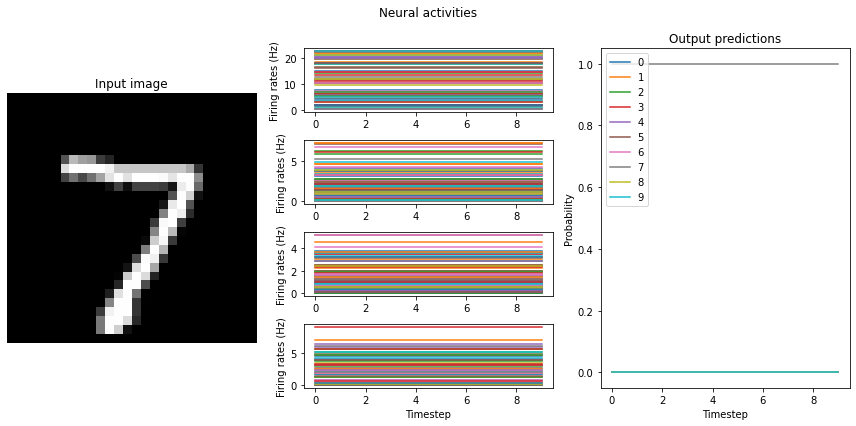

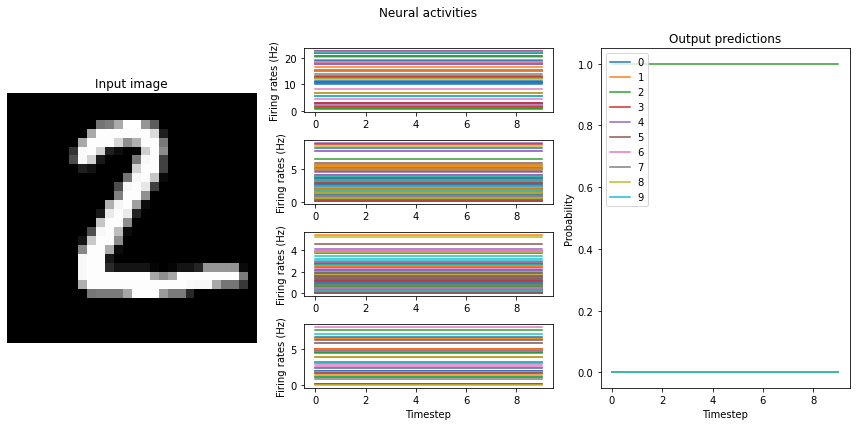

In [7]:
# test the trained networks on test set
mean_rates = run_network(activation=nengo.RectifiedLinear(), n_steps=10)

Note that we're plotting the output over time for consistency with future plots, but
since our network doesn't have any temporal elements (e.g. spiking neurons), the output
is constant for each digit. The firing rates here displayed in the middle graph are
important to note for conversion to spikes, and may vary somewhat depending on the
random initial conditions used for training. One of the important features visible here,
which we'll discuss shortly, is the decreasing mean firing rate as you move through the
network. Note that these mean firing rates are computed across only the neurons that
have non-zero activities; they are therefore the mean rates of the active neurons.

Let's continue with the comparison by moving into spikes.

## Converting to a spiking neural network

Using the NengoDL converter, we can swap all the `relu` activation functions to
`nengo.SpikingRectifiedLinear`. Using the lessons that we learned in the Keras->SNN
example notebook we'll set `synapse=0.005` and `scale_firing_rates=100`.

Test accuracy: 100.00%
"to-spikes" mean firing rate (example 0): 1420.9


"conv0" mean firing rate (example 0): 185.4
"conv1" mean firing rate (example 0): 87.2
"dense0" mean firing rate (example 0): 140.0


"to-spikes" mean firing rate (example 1): 1548.5
"conv0" mean firing rate (example 1): 210.2
"conv1" mean firing rate (example 1): 96.4
"dense0" mean firing rate (example 1): 176.3


array([1484.677  ,  197.84457,   91.80095,  158.14815], dtype=float32)

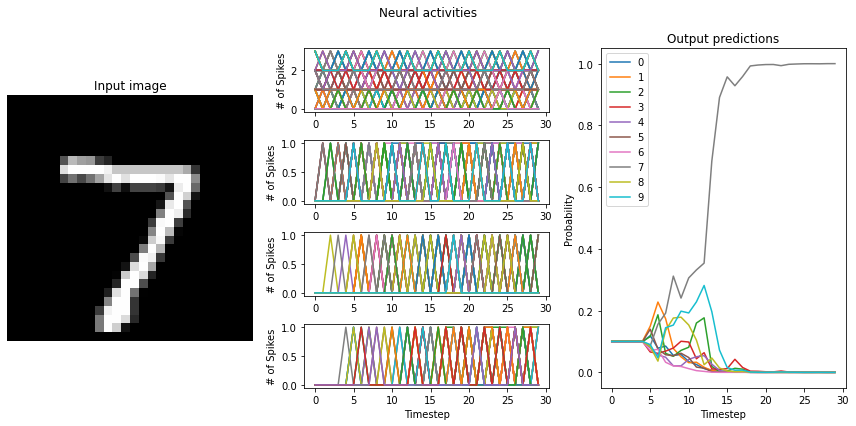

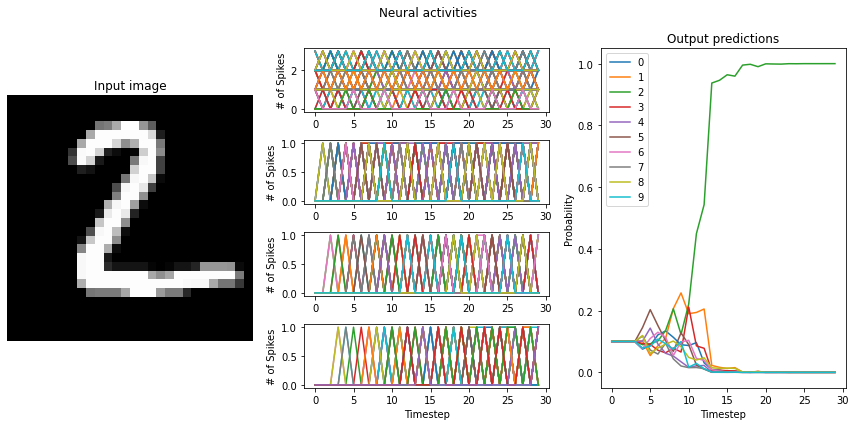

In [8]:
# test the trained networks using spiking neurons
run_network(
    activation=nengo.SpikingRectifiedLinear(),
    scale_firing_rates=100,
    synapse=0.005,
)

An important feature of SNNs is the time required to generate output. The larger your
scaling factor, the quicker the network response to input will be. This is because more
spikes will be generated at each layer, triggering a quicker response at the succeeding
layer.

For still images, where each successive image has no correlation with the previous
image, this leads to a lag in generating output. SNNs are however much more efficient in
a problem like processing a video stream, where there is high correlation between
frames. In general, SNNs perform better in situations with temporal dynamics. For
simplicity, though, we only examine the case of processing still images here.

Let's see what happens when we convert to an SNN using Loihi neurons.

## Converting to SNN using Loihi neurons

To get a sense of how well our network will run on Loihi, we switch to using the
`LoihiSpikingRectifiedLinear` activation profile.

Note that the on-chip restrictions don't apply to the input layer that we added to the
network, because it won't be running on the Loihi. Here, the performance differences are
minimal so we just convert all neurons over to Loihi neurons. If you find that adding
the input layer is causing a performance drop, you may want to build your network such
that only the on-chip layers use the NengoLoihi neurons and the off-chip layer uses a
standard spiking neuron model (i.e. `SpikingRectifiedLinear`).

Test accuracy: 88.00%
"to-spikes" mean firing rate (example 0): 792.1
"conv0" mean firing rate (example 0): 92.6
"conv1" mean firing rate (example 0): 47.0


"dense0" mean firing rate (example 0): 34.7


"to-spikes" mean firing rate (example 1): 834.5
"conv0" mean firing rate (example 1): 102.5
"conv1" mean firing rate (example 1): 49.6


"dense0" mean firing rate (example 1): 36.5


array([813.3253  ,  97.535126,  48.28082 ,  35.615074], dtype=float32)

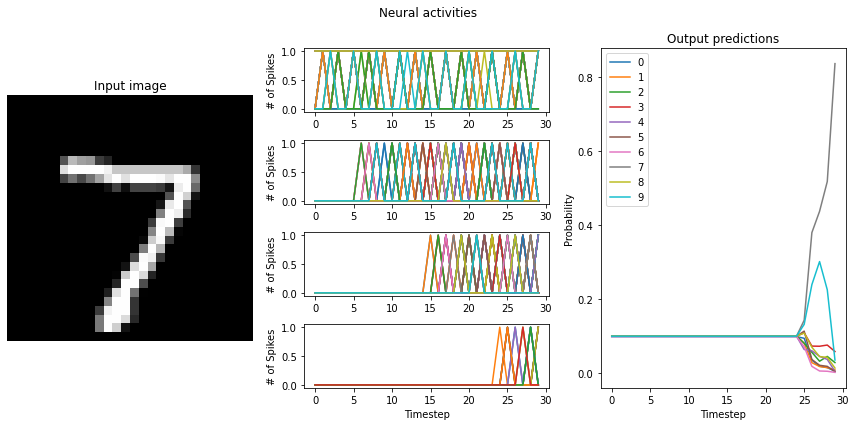

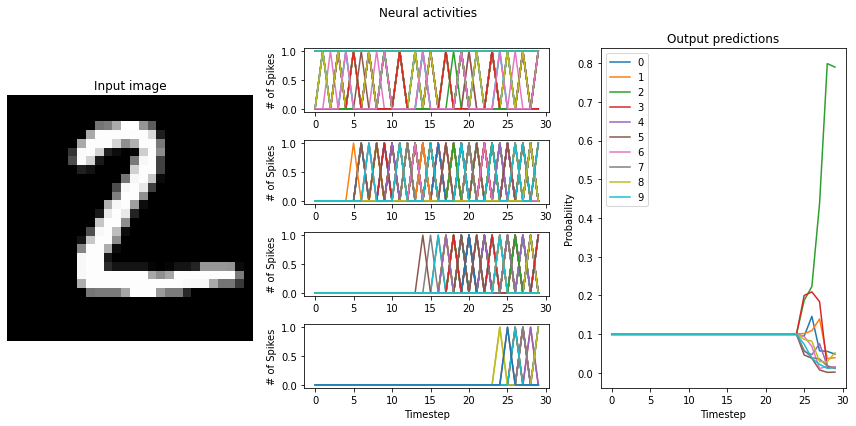

In [9]:
# test the trained networks using spiking neurons
run_network(
    activation=nengo_loihi.neurons.LoihiSpikingRectifiedLinear(),
    scale_firing_rates=100,
    synapse=0.005,
)

If the training resulted a network with large differences between the firing rates (>
10Hz) of the network layers, switching to `LoihiSpikingRectifiedLinear` neurons will
cause a significant decrease in the performance of the network. What causes this?

Basically, the issue is that each of the layers need different scaling terms. With large
firing rate discrepancies between layers, we end up trying to balance between having a
`scale_firing_rate` value for the network that 1) is high enough to achieve good
performance from the network, but 2) is low enough to not induce multiple spikes per
time step in any layer. The second point here is where we're getting tripped up.

Loihi neurons can only spike once per time step. Recall that while the
`scale_firing_rates` term increases the gain on signals going into neurons, it also
correspondingly decreases the `amplitude` of the neuron activity output. If
`scale_firing_rates` is set high enough to expect three spikes per time step, but only
one spike comes out, the effects will no longer balance out and performance will
deteriorate.

Instead of setting a single `scale_firing_rate` for the whole network, we can specify a
scaling value for each layer. To figure out what range we want to put the firing rates
into, let's look at the Loihi neurons' activation functions.

### The Loihi activation profile

The shape of the Loihi neuron activation profile is unique, and for high firing rates
has strong discrepancies with standard `relu` and `lif` behaviour. This is due to the
discretization required by the Loihi hardware. Let's take a closer look.

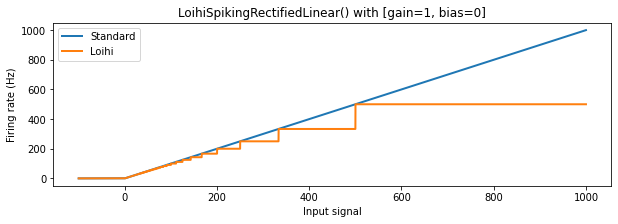

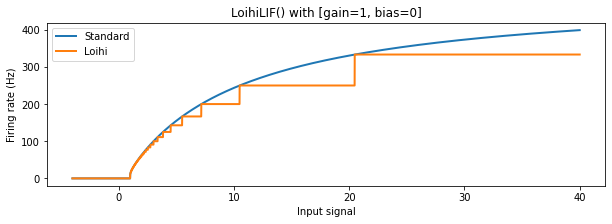

In [10]:
def plot_activation(neurons, min, max, **kwargs):
    x = np.arange(min, max, 0.001)
    fr = neurons.rates(x=x, gain=[1], bias=[0])

    plt.plot(x, fr, lw=2, **kwargs)
    plt.title("%s with [gain=1, bias=0]" % str(neurons))
    plt.ylabel("Firing rate (Hz)")
    plt.xlabel("Input signal")
    plt.legend(["Standard", "Loihi"], loc=2)


plt.figure(figsize=(10, 3))
plot_activation(nengo.RectifiedLinear(), -100, 1000)
plot_activation(nengo_loihi.neurons.LoihiSpikingRectifiedLinear(), -100, 1000)

plt.figure(figsize=(10, 3))
plot_activation(nengo.LIF(), -4, 40)
plot_activation(nengo_loihi.neurons.LoihiLIF(), -4, 40)

We can see that for lower firing rates the behaviour of the Loihi neurons approximates
the normal `relu` and `lif` neurons relatively well, but for higher firing rates the
discrepancy becomes larger. The discretization results in large plateus of input signal
values where the output firing rate from the neuron stays the same, making different
input values in this range indistinguishable. Also, as mentioned above, for input values
above 1000 (not shown) the `LoihiSpikingRectifiedLinear` neuron will have a constant
output of 1000 Hz (since this corresponds to one spike per timestep, the maximum firing
rate on Loihi); the `SpikingRectifiedLinear` neuron, on the other hand, is able to fire
faster than 1000 Hz by using multiple spikes per timestep.

We can now return to our original question: How do we pick good firing rates for each
layer? For outputs above 250 Hz, both Loihi activation functions show significant
deviations from the non-Loihi activation profiles; they also become more discontinuous
above this point. We therefore want to keep our maximum firing rates below 250 Hz. We
also need the firing rate to be high enough to generate sufficient spikes, so that
information can be transmitted from layer to layer in a reasonable time. For these
reasons, we'll choose a target mean firing rate for each layer to be 200. We'll generate
a scaling term for each layer individually to hit this target.

Test accuracy: 99.00%
"to-spikes" mean firing rate (example 0): 169.2
"conv0" mean firing rate (example 0): 123.0
"conv1" mean firing rate (example 0): 91.2
"dense0" mean firing rate (example 0): 41.0


"to-spikes" mean firing rate (example 1): 191.0


"conv0" mean firing rate (example 1): 137.3
"conv1" mean firing rate (example 1): 94.9
"dense0" mean firing rate (example 1): 42.3


array([180.12039 , 130.15698 ,  93.0778  ,  41.666664], dtype=float32)

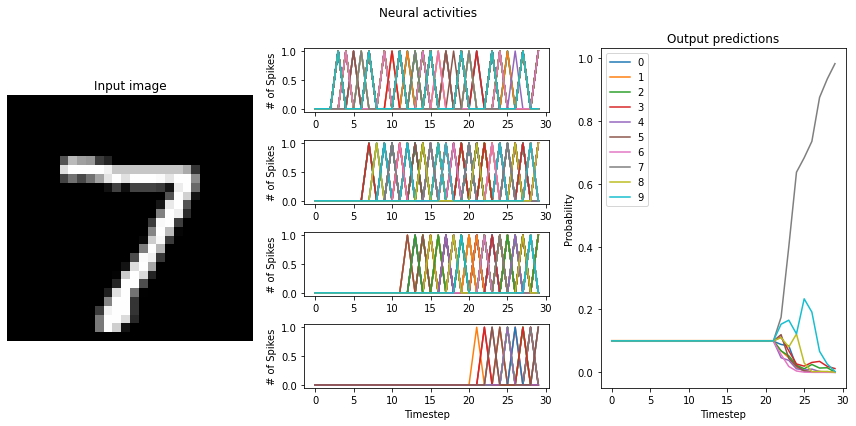

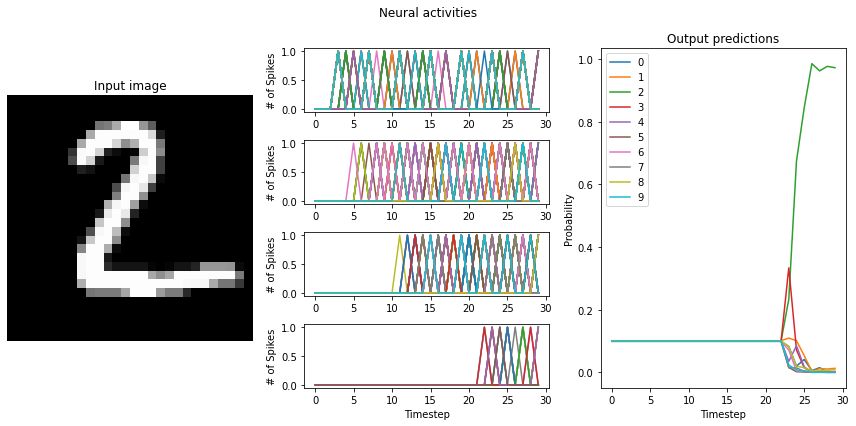

In [11]:
target_mean = 200
scale_firing_rates = {
    to_spikes_layer: target_mean / mean_rates[0],
    conv0_layer: target_mean / mean_rates[1],
    conv1_layer: target_mean / mean_rates[2],
    dense0_layer: target_mean / mean_rates[3],
}

# test the trained networks using spiking neurons
run_network(
    activation=nengo_loihi.neurons.LoihiSpikingRectifiedLinear(),
    scale_firing_rates=scale_firing_rates,
    synapse=0.005,
)

As we can see, when we individually scale the activity of each layer, we almost fully
recover non-spiking performance. Note that the firing rates of some layers (the later
layers in particular) do not quite meet the target mean firing rate of 200 Hz, though.
This is because our mean firing rates were measured using the `RectifiedLinear` neuron
type, and do not account for the difference between it and the
`LoihiSpikingRectifiedLinear` activation function. For better results, we could go back
and measure the mean firing rates using the Loihi neuron type, or hand-tune the scaling
factors on each layer to achieve the desired firing rates.

Alternatively, we can train our network using the `LoihiSpikingRectifiedLinear`. This
will account both for the discretization in the activation profile, and the hard limit
of 1 spike per time step. For larger or more complex networks this can save time tuning.

## Training with the Loihi neurons

We're going to use another trick for training and set `scale_firing_rates=100` _while_
training. What this does essentially is initiate the network with high firing rates,
such that during training we'll consistently find a local minima with higher firing
rates that will work well when we swap in spiking neurons. It also reduces the
discrepancy in firing rates between layers, starting them all off in a higher range.

This is a low-overhead, ad-hoc means of increasing the firing rates of neurons in each
layer, and does not guarantee that the network converges to a desired range of firing
rates for each layer after training. The firing rate regularization method—shown in a
basic form in the [Keras to SNN
example](https://www.nengo.ai/nengo-dl/examples/keras-to-snn.html) and in a more
powerful form in the [CIFAR-10 Loihi
example](https://www.nengo.ai/nengo-loihi/examples/cifar10-convnet.html)—is a more
consistent way to achieve the desired range of firing rates in each layer.

In [12]:
# train this network with normal ReLU neurons
train(
    params_file="./keras_to_loihi_loihineuron_params",
    epochs=2,
    swap_activations={tf.nn.relu: nengo_loihi.neurons.LoihiSpikingRectifiedLinear()},
    scale_firing_rates=100,
)

|                     Building network (0%)                    | ETA:  --:--:--

|########             Building network (13%)                     | ETA: 0:00:00

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

| #                       Constructing graph                          | 0:00:00

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|######        Constructing graph: build stage (10%)             | ETA: 0:00:00

|##############Constructing graph: build stage (36%)             | ETA: 0:00:00

|##############Constructing graph: build stage (68%)             | ETA: 0:00:00

|   #                     Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Epoch 1/2


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|###           Constructing graph: build stage (5%)              | ETA: 0:00:01

|##############Constructing graph: build stage (52%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|###           Constructing graph: build stage (5%)              | ETA: 0:00:01

|##############Constructing graph: build stage (52%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

  1/300 [..............................] - ETA: 0s - loss: 2.4255 - probe_loss: 2.4255 - probe_sparse_categorical_accuracy: 0.0400

  2/300 [..............................] - ETA: 10s - loss: 2.2369 - probe_loss: 2.2369 - probe_sparse_categorical_accuracy: 0.1550

  3/300 [..............................] - ETA: 13s - loss: 2.0643 - probe_loss: 2.0643 - probe_sparse_categorical_accuracy: 0.2417

  4/300 [..............................] - ETA: 15s - loss: 1.8997 - probe_loss: 1.8997 - probe_sparse_categorical_accuracy: 0.3125

  5/300 [..............................] - ETA: 16s - loss: 1.7664 - probe_loss: 1.7664 - probe_sparse_categorical_accuracy: 0.3720

  6/300 [..............................] - ETA: 16s - loss: 1.6626 - probe_loss: 1.6626 - probe_sparse_categorical_accuracy: 0.4242

  7/300 [..............................] - ETA: 17s - loss: 1.5608 - probe_loss: 1.5608 - probe_sparse_categorical_accuracy: 0.4621

  8/300 [..............................] - ETA: 17s - loss: 1.4820 - probe_loss: 1.4820 - probe_sparse_categorical_accuracy: 0.4925

  9/300 [..............................] - ETA: 17s - loss: 1.3994 - probe_loss: 1.3994 - probe_sparse_categorical_accuracy: 0.5233

 10/300 [>.............................] - ETA: 17s - loss: 1.3349 - probe_loss: 1.3349 - probe_sparse_categorical_accuracy: 0.5480

 11/300 [>.............................] - ETA: 17s - loss: 1.2967 - probe_loss: 1.2967 - probe_sparse_categorical_accuracy: 0.5609

 12/300 [>.............................] - ETA: 18s - loss: 1.2455 - probe_loss: 1.2455 - probe_sparse_categorical_accuracy: 0.5796

 13/300 [>.............................] - ETA: 18s - loss: 1.1863 - probe_loss: 1.1863 - probe_sparse_categorical_accuracy: 0.6015

 14/300 [>.............................] - ETA: 18s - loss: 1.1338 - probe_loss: 1.1338 - probe_sparse_categorical_accuracy: 0.6207

 15/300 [>.............................] - ETA: 18s - loss: 1.0914 - probe_loss: 1.0914 - probe_sparse_categorical_accuracy: 0.6367

 16/300 [>.............................] - ETA: 18s - loss: 1.0462 - probe_loss: 1.0462 - probe_sparse_categorical_accuracy: 0.6541

 17/300 [>.............................] - ETA: 18s - loss: 1.0123 - probe_loss: 1.0123 - probe_sparse_categorical_accuracy: 0.6659

 18/300 [>.............................] - ETA: 18s - loss: 0.9829 - probe_loss: 0.9829 - probe_sparse_categorical_accuracy: 0.6764

 19/300 [>.............................] - ETA: 18s - loss: 0.9535 - probe_loss: 0.9535 - probe_sparse_categorical_accuracy: 0.6850

 20/300 [=>............................] - ETA: 18s - loss: 0.9343 - probe_loss: 0.9343 - probe_sparse_categorical_accuracy: 0.6908

 21/300 [=>............................] - ETA: 18s - loss: 0.9125 - probe_loss: 0.9125 - probe_sparse_categorical_accuracy: 0.6990

 22/300 [=>............................] - ETA: 18s - loss: 0.8893 - probe_loss: 0.8893 - probe_sparse_categorical_accuracy: 0.7064

 23/300 [=>............................] - ETA: 18s - loss: 0.8701 - probe_loss: 0.8701 - probe_sparse_categorical_accuracy: 0.7130

 24/300 [=>............................] - ETA: 18s - loss: 0.8500 - probe_loss: 0.8500 - probe_sparse_categorical_accuracy: 0.7198

 25/300 [=>............................] - ETA: 18s - loss: 0.8339 - probe_loss: 0.8339 - probe_sparse_categorical_accuracy: 0.7256

 26/300 [=>............................] - ETA: 18s - loss: 0.8166 - probe_loss: 0.8166 - probe_sparse_categorical_accuracy: 0.7302

 27/300 [=>............................] - ETA: 18s - loss: 0.7972 - probe_loss: 0.7972 - probe_sparse_categorical_accuracy: 0.7370

 28/300 [=>............................] - ETA: 18s - loss: 0.7820 - probe_loss: 0.7820 - probe_sparse_categorical_accuracy: 0.7430

 29/300 [=>............................] - ETA: 18s - loss: 0.7632 - probe_loss: 0.7632 - probe_sparse_categorical_accuracy: 0.7493

 30/300 [==>...........................] - ETA: 17s - loss: 0.7486 - probe_loss: 0.7486 - probe_sparse_categorical_accuracy: 0.7547

 31/300 [==>...........................] - ETA: 17s - loss: 0.7359 - probe_loss: 0.7359 - probe_sparse_categorical_accuracy: 0.7592

 32/300 [==>...........................] - ETA: 17s - loss: 0.7264 - probe_loss: 0.7264 - probe_sparse_categorical_accuracy: 0.7636

 33/300 [==>...........................] - ETA: 17s - loss: 0.7171 - probe_loss: 0.7171 - probe_sparse_categorical_accuracy: 0.7674

 34/300 [==>...........................] - ETA: 17s - loss: 0.7045 - probe_loss: 0.7045 - probe_sparse_categorical_accuracy: 0.7721

 35/300 [==>...........................] - ETA: 17s - loss: 0.6936 - probe_loss: 0.6936 - probe_sparse_categorical_accuracy: 0.7756

 36/300 [==>...........................] - ETA: 17s - loss: 0.6818 - probe_loss: 0.6818 - probe_sparse_categorical_accuracy: 0.7799

 37/300 [==>...........................] - ETA: 17s - loss: 0.6712 - probe_loss: 0.6712 - probe_sparse_categorical_accuracy: 0.7841

 38/300 [==>...........................] - ETA: 17s - loss: 0.6594 - probe_loss: 0.6594 - probe_sparse_categorical_accuracy: 0.7882

 39/300 [==>...........................] - ETA: 17s - loss: 0.6467 - probe_loss: 0.6467 - probe_sparse_categorical_accuracy: 0.7921

 40/300 [===>..........................] - ETA: 17s - loss: 0.6379 - probe_loss: 0.6379 - probe_sparse_categorical_accuracy: 0.7944

 41/300 [===>..........................] - ETA: 17s - loss: 0.6311 - probe_loss: 0.6311 - probe_sparse_categorical_accuracy: 0.7967

 42/300 [===>..........................] - ETA: 17s - loss: 0.6272 - probe_loss: 0.6272 - probe_sparse_categorical_accuracy: 0.7973

 43/300 [===>..........................] - ETA: 17s - loss: 0.6211 - probe_loss: 0.6211 - probe_sparse_categorical_accuracy: 0.7991

 44/300 [===>..........................] - ETA: 17s - loss: 0.6130 - probe_loss: 0.6130 - probe_sparse_categorical_accuracy: 0.8014

 45/300 [===>..........................] - ETA: 17s - loss: 0.6064 - probe_loss: 0.6064 - probe_sparse_categorical_accuracy: 0.8037

 46/300 [===>..........................] - ETA: 17s - loss: 0.5981 - probe_loss: 0.5981 - probe_sparse_categorical_accuracy: 0.8065

 47/300 [===>..........................] - ETA: 17s - loss: 0.5890 - probe_loss: 0.5890 - probe_sparse_categorical_accuracy: 0.8095

 48/300 [===>..........................] - ETA: 17s - loss: 0.5826 - probe_loss: 0.5826 - probe_sparse_categorical_accuracy: 0.8122

 49/300 [===>..........................] - ETA: 17s - loss: 0.5751 - probe_loss: 0.5751 - probe_sparse_categorical_accuracy: 0.8146

 50/300 [====>.........................] - ETA: 16s - loss: 0.5683 - probe_loss: 0.5683 - probe_sparse_categorical_accuracy: 0.8170

 51/300 [====>.........................] - ETA: 16s - loss: 0.5617 - probe_loss: 0.5617 - probe_sparse_categorical_accuracy: 0.8193

 52/300 [====>.........................] - ETA: 16s - loss: 0.5558 - probe_loss: 0.5558 - probe_sparse_categorical_accuracy: 0.8213

 53/300 [====>.........................] - ETA: 16s - loss: 0.5485 - probe_loss: 0.5485 - probe_sparse_categorical_accuracy: 0.8239

 54/300 [====>.........................] - ETA: 16s - loss: 0.5433 - probe_loss: 0.5433 - probe_sparse_categorical_accuracy: 0.8257

 55/300 [====>.........................] - ETA: 16s - loss: 0.5383 - probe_loss: 0.5383 - probe_sparse_categorical_accuracy: 0.8278

 56/300 [====>.........................] - ETA: 16s - loss: 0.5317 - probe_loss: 0.5317 - probe_sparse_categorical_accuracy: 0.8299

 57/300 [====>.........................] - ETA: 16s - loss: 0.5268 - probe_loss: 0.5268 - probe_sparse_categorical_accuracy: 0.8313

 58/300 [====>.........................] - ETA: 16s - loss: 0.5235 - probe_loss: 0.5235 - probe_sparse_categorical_accuracy: 0.8323

 59/300 [====>.........................] - ETA: 16s - loss: 0.5181 - probe_loss: 0.5181 - probe_sparse_categorical_accuracy: 0.8343

 60/300 [=====>........................] - ETA: 16s - loss: 0.5122 - probe_loss: 0.5122 - probe_sparse_categorical_accuracy: 0.8363

 61/300 [=====>........................] - ETA: 16s - loss: 0.5073 - probe_loss: 0.5073 - probe_sparse_categorical_accuracy: 0.8379

 62/300 [=====>........................] - ETA: 16s - loss: 0.5020 - probe_loss: 0.5020 - probe_sparse_categorical_accuracy: 0.8399

 63/300 [=====>........................] - ETA: 16s - loss: 0.4974 - probe_loss: 0.4974 - probe_sparse_categorical_accuracy: 0.8417

 64/300 [=====>........................] - ETA: 16s - loss: 0.4919 - probe_loss: 0.4919 - probe_sparse_categorical_accuracy: 0.8434

 65/300 [=====>........................] - ETA: 15s - loss: 0.4875 - probe_loss: 0.4875 - probe_sparse_categorical_accuracy: 0.8448

 66/300 [=====>........................] - ETA: 15s - loss: 0.4830 - probe_loss: 0.4830 - probe_sparse_categorical_accuracy: 0.8461

 67/300 [=====>........................] - ETA: 15s - loss: 0.4775 - probe_loss: 0.4775 - probe_sparse_categorical_accuracy: 0.8481

 68/300 [=====>........................] - ETA: 15s - loss: 0.4734 - probe_loss: 0.4734 - probe_sparse_categorical_accuracy: 0.8497

 69/300 [=====>........................] - ETA: 15s - loss: 0.4695 - probe_loss: 0.4695 - probe_sparse_categorical_accuracy: 0.8509

 70/300 [======>.......................] - ETA: 15s - loss: 0.4655 - probe_loss: 0.4655 - probe_sparse_categorical_accuracy: 0.8523

 71/300 [======>.......................] - ETA: 15s - loss: 0.4603 - probe_loss: 0.4603 - probe_sparse_categorical_accuracy: 0.8541

 72/300 [======>.......................] - ETA: 15s - loss: 0.4569 - probe_loss: 0.4569 - probe_sparse_categorical_accuracy: 0.8554

 73/300 [======>.......................] - ETA: 15s - loss: 0.4529 - probe_loss: 0.4529 - probe_sparse_categorical_accuracy: 0.8567

 74/300 [======>.......................] - ETA: 15s - loss: 0.4488 - probe_loss: 0.4488 - probe_sparse_categorical_accuracy: 0.8580

 75/300 [======>.......................] - ETA: 15s - loss: 0.4451 - probe_loss: 0.4451 - probe_sparse_categorical_accuracy: 0.8593

 76/300 [======>.......................] - ETA: 15s - loss: 0.4412 - probe_loss: 0.4412 - probe_sparse_categorical_accuracy: 0.8607

 77/300 [======>.......................] - ETA: 15s - loss: 0.4373 - probe_loss: 0.4373 - probe_sparse_categorical_accuracy: 0.8619

 78/300 [======>.......................] - ETA: 15s - loss: 0.4340 - probe_loss: 0.4340 - probe_sparse_categorical_accuracy: 0.8630

 79/300 [======>.......................] - ETA: 15s - loss: 0.4304 - probe_loss: 0.4304 - probe_sparse_categorical_accuracy: 0.8641

 80/300 [=======>......................] - ETA: 14s - loss: 0.4263 - probe_loss: 0.4263 - probe_sparse_categorical_accuracy: 0.8653

 81/300 [=======>......................] - ETA: 14s - loss: 0.4237 - probe_loss: 0.4237 - probe_sparse_categorical_accuracy: 0.8663

 82/300 [=======>......................] - ETA: 14s - loss: 0.4219 - probe_loss: 0.4219 - probe_sparse_categorical_accuracy: 0.8670

 83/300 [=======>......................] - ETA: 14s - loss: 0.4186 - probe_loss: 0.4186 - probe_sparse_categorical_accuracy: 0.8680

 84/300 [=======>......................] - ETA: 14s - loss: 0.4157 - probe_loss: 0.4157 - probe_sparse_categorical_accuracy: 0.8689

 85/300 [=======>......................] - ETA: 14s - loss: 0.4123 - probe_loss: 0.4123 - probe_sparse_categorical_accuracy: 0.8700

 86/300 [=======>......................] - ETA: 14s - loss: 0.4090 - probe_loss: 0.4090 - probe_sparse_categorical_accuracy: 0.8710

 87/300 [=======>......................] - ETA: 14s - loss: 0.4065 - probe_loss: 0.4065 - probe_sparse_categorical_accuracy: 0.8718

 88/300 [=======>......................] - ETA: 14s - loss: 0.4042 - probe_loss: 0.4042 - probe_sparse_categorical_accuracy: 0.8727

 89/300 [=======>......................] - ETA: 14s - loss: 0.4012 - probe_loss: 0.4012 - probe_sparse_categorical_accuracy: 0.8735

 90/300 [========>.....................] - ETA: 14s - loss: 0.3984 - probe_loss: 0.3984 - probe_sparse_categorical_accuracy: 0.8744

 91/300 [========>.....................] - ETA: 14s - loss: 0.3959 - probe_loss: 0.3959 - probe_sparse_categorical_accuracy: 0.8753

 92/300 [========>.....................] - ETA: 14s - loss: 0.3944 - probe_loss: 0.3944 - probe_sparse_categorical_accuracy: 0.8759

 93/300 [========>.....................] - ETA: 14s - loss: 0.3919 - probe_loss: 0.3919 - probe_sparse_categorical_accuracy: 0.8767

 94/300 [========>.....................] - ETA: 14s - loss: 0.3892 - probe_loss: 0.3892 - probe_sparse_categorical_accuracy: 0.8776

 95/300 [========>.....................] - ETA: 13s - loss: 0.3868 - probe_loss: 0.3868 - probe_sparse_categorical_accuracy: 0.8783

 96/300 [========>.....................] - ETA: 13s - loss: 0.3841 - probe_loss: 0.3841 - probe_sparse_categorical_accuracy: 0.8792

 97/300 [========>.....................] - ETA: 13s - loss: 0.3811 - probe_loss: 0.3811 - probe_sparse_categorical_accuracy: 0.8800

 98/300 [========>.....................] - ETA: 13s - loss: 0.3791 - probe_loss: 0.3791 - probe_sparse_categorical_accuracy: 0.8807

 99/300 [========>.....................] - ETA: 13s - loss: 0.3770 - probe_loss: 0.3770 - probe_sparse_categorical_accuracy: 0.8813

100/300 [=========>....................] - ETA: 13s - loss: 0.3743 - probe_loss: 0.3743 - probe_sparse_categorical_accuracy: 0.8822

101/300 [=========>....................] - ETA: 13s - loss: 0.3731 - probe_loss: 0.3731 - probe_sparse_categorical_accuracy: 0.8828

102/300 [=========>....................] - ETA: 13s - loss: 0.3705 - probe_loss: 0.3705 - probe_sparse_categorical_accuracy: 0.8838

103/300 [=========>....................] - ETA: 13s - loss: 0.3684 - probe_loss: 0.3684 - probe_sparse_categorical_accuracy: 0.8844

104/300 [=========>....................] - ETA: 13s - loss: 0.3662 - probe_loss: 0.3662 - probe_sparse_categorical_accuracy: 0.8851

105/300 [=========>....................] - ETA: 13s - loss: 0.3639 - probe_loss: 0.3639 - probe_sparse_categorical_accuracy: 0.8859

106/300 [=========>....................] - ETA: 13s - loss: 0.3618 - probe_loss: 0.3618 - probe_sparse_categorical_accuracy: 0.8867

107/300 [=========>....................] - ETA: 13s - loss: 0.3593 - probe_loss: 0.3593 - probe_sparse_categorical_accuracy: 0.8875

108/300 [=========>....................] - ETA: 13s - loss: 0.3571 - probe_loss: 0.3571 - probe_sparse_categorical_accuracy: 0.8881

109/300 [=========>....................] - ETA: 13s - loss: 0.3549 - probe_loss: 0.3549 - probe_sparse_categorical_accuracy: 0.8888

110/300 [==========>...................] - ETA: 12s - loss: 0.3538 - probe_loss: 0.3538 - probe_sparse_categorical_accuracy: 0.8891

111/300 [==========>...................] - ETA: 12s - loss: 0.3515 - probe_loss: 0.3515 - probe_sparse_categorical_accuracy: 0.8899

112/300 [==========>...................] - ETA: 12s - loss: 0.3498 - probe_loss: 0.3498 - probe_sparse_categorical_accuracy: 0.8904

113/300 [==========>...................] - ETA: 12s - loss: 0.3481 - probe_loss: 0.3481 - probe_sparse_categorical_accuracy: 0.8910

114/300 [==========>...................] - ETA: 12s - loss: 0.3456 - probe_loss: 0.3456 - probe_sparse_categorical_accuracy: 0.8918

115/300 [==========>...................] - ETA: 12s - loss: 0.3436 - probe_loss: 0.3436 - probe_sparse_categorical_accuracy: 0.8924

116/300 [==========>...................] - ETA: 12s - loss: 0.3419 - probe_loss: 0.3419 - probe_sparse_categorical_accuracy: 0.8928

117/300 [==========>...................] - ETA: 12s - loss: 0.3404 - probe_loss: 0.3404 - probe_sparse_categorical_accuracy: 0.8933

118/300 [==========>...................] - ETA: 12s - loss: 0.3390 - probe_loss: 0.3390 - probe_sparse_categorical_accuracy: 0.8940

119/300 [==========>...................] - ETA: 12s - loss: 0.3371 - probe_loss: 0.3371 - probe_sparse_categorical_accuracy: 0.8946

120/300 [===========>..................] - ETA: 12s - loss: 0.3356 - probe_loss: 0.3356 - probe_sparse_categorical_accuracy: 0.8950

121/300 [===========>..................] - ETA: 12s - loss: 0.3341 - probe_loss: 0.3341 - probe_sparse_categorical_accuracy: 0.8955

122/300 [===========>..................] - ETA: 12s - loss: 0.3320 - probe_loss: 0.3320 - probe_sparse_categorical_accuracy: 0.8963

123/300 [===========>..................] - ETA: 12s - loss: 0.3304 - probe_loss: 0.3304 - probe_sparse_categorical_accuracy: 0.8968

124/300 [===========>..................] - ETA: 12s - loss: 0.3285 - probe_loss: 0.3285 - probe_sparse_categorical_accuracy: 0.8973

125/300 [===========>..................] - ETA: 11s - loss: 0.3265 - probe_loss: 0.3265 - probe_sparse_categorical_accuracy: 0.8978

126/300 [===========>..................] - ETA: 11s - loss: 0.3243 - probe_loss: 0.3243 - probe_sparse_categorical_accuracy: 0.8986

127/300 [===========>..................] - ETA: 11s - loss: 0.3229 - probe_loss: 0.3229 - probe_sparse_categorical_accuracy: 0.8989

128/300 [===========>..................] - ETA: 11s - loss: 0.3214 - probe_loss: 0.3214 - probe_sparse_categorical_accuracy: 0.8995

129/300 [===========>..................] - ETA: 11s - loss: 0.3206 - probe_loss: 0.3206 - probe_sparse_categorical_accuracy: 0.8997

130/300 [============>.................] - ETA: 11s - loss: 0.3189 - probe_loss: 0.3189 - probe_sparse_categorical_accuracy: 0.9002

131/300 [============>.................] - ETA: 11s - loss: 0.3174 - probe_loss: 0.3174 - probe_sparse_categorical_accuracy: 0.9007

132/300 [============>.................] - ETA: 11s - loss: 0.3158 - probe_loss: 0.3158 - probe_sparse_categorical_accuracy: 0.9014

133/300 [============>.................] - ETA: 11s - loss: 0.3144 - probe_loss: 0.3144 - probe_sparse_categorical_accuracy: 0.9019

134/300 [============>.................] - ETA: 11s - loss: 0.3133 - probe_loss: 0.3133 - probe_sparse_categorical_accuracy: 0.9022

135/300 [============>.................] - ETA: 11s - loss: 0.3115 - probe_loss: 0.3115 - probe_sparse_categorical_accuracy: 0.9029

136/300 [============>.................] - ETA: 11s - loss: 0.3099 - probe_loss: 0.3099 - probe_sparse_categorical_accuracy: 0.9034

137/300 [============>.................] - ETA: 11s - loss: 0.3081 - probe_loss: 0.3081 - probe_sparse_categorical_accuracy: 0.9039

138/300 [============>.................] - ETA: 11s - loss: 0.3065 - probe_loss: 0.3065 - probe_sparse_categorical_accuracy: 0.9045

139/300 [============>.................] - ETA: 10s - loss: 0.3047 - probe_loss: 0.3047 - probe_sparse_categorical_accuracy: 0.9050

140/300 [=============>................] - ETA: 10s - loss: 0.3039 - probe_loss: 0.3039 - probe_sparse_categorical_accuracy: 0.9054

141/300 [=============>................] - ETA: 10s - loss: 0.3031 - probe_loss: 0.3031 - probe_sparse_categorical_accuracy: 0.9056

142/300 [=============>................] - ETA: 10s - loss: 0.3025 - probe_loss: 0.3025 - probe_sparse_categorical_accuracy: 0.9058

143/300 [=============>................] - ETA: 10s - loss: 0.3011 - probe_loss: 0.3011 - probe_sparse_categorical_accuracy: 0.9063

144/300 [=============>................] - ETA: 10s - loss: 0.3002 - probe_loss: 0.3002 - probe_sparse_categorical_accuracy: 0.9066

145/300 [=============>................] - ETA: 10s - loss: 0.2990 - probe_loss: 0.2990 - probe_sparse_categorical_accuracy: 0.9069

146/300 [=============>................] - ETA: 10s - loss: 0.2986 - probe_loss: 0.2986 - probe_sparse_categorical_accuracy: 0.9072

147/300 [=============>................] - ETA: 10s - loss: 0.2974 - probe_loss: 0.2974 - probe_sparse_categorical_accuracy: 0.9074

148/300 [=============>................] - ETA: 10s - loss: 0.2963 - probe_loss: 0.2963 - probe_sparse_categorical_accuracy: 0.9078

149/300 [=============>................] - ETA: 10s - loss: 0.2948 - probe_loss: 0.2948 - probe_sparse_categorical_accuracy: 0.9084

150/300 [==============>...............] - ETA: 10s - loss: 0.2932 - probe_loss: 0.2932 - probe_sparse_categorical_accuracy: 0.9089

151/300 [==============>...............] - ETA: 10s - loss: 0.2919 - probe_loss: 0.2919 - probe_sparse_categorical_accuracy: 0.9093

152/300 [==============>...............] - ETA: 10s - loss: 0.2905 - probe_loss: 0.2905 - probe_sparse_categorical_accuracy: 0.9097

153/300 [==============>...............] - ETA: 10s - loss: 0.2896 - probe_loss: 0.2896 - probe_sparse_categorical_accuracy: 0.9100

154/300 [==============>...............] - ETA: 9s - loss: 0.2884 - probe_loss: 0.2884 - probe_sparse_categorical_accuracy: 0.9103 

155/300 [==============>...............] - ETA: 9s - loss: 0.2874 - probe_loss: 0.2874 - probe_sparse_categorical_accuracy: 0.9105

156/300 [==============>...............] - ETA: 9s - loss: 0.2866 - probe_loss: 0.2866 - probe_sparse_categorical_accuracy: 0.9108

157/300 [==============>...............] - ETA: 9s - loss: 0.2851 - probe_loss: 0.2851 - probe_sparse_categorical_accuracy: 0.9113

158/300 [==============>...............] - ETA: 9s - loss: 0.2841 - probe_loss: 0.2841 - probe_sparse_categorical_accuracy: 0.9116

159/300 [==============>...............] - ETA: 9s - loss: 0.2835 - probe_loss: 0.2835 - probe_sparse_categorical_accuracy: 0.9119

160/300 [===============>..............] - ETA: 9s - loss: 0.2822 - probe_loss: 0.2822 - probe_sparse_categorical_accuracy: 0.9122

161/300 [===============>..............] - ETA: 9s - loss: 0.2809 - probe_loss: 0.2809 - probe_sparse_categorical_accuracy: 0.9127

162/300 [===============>..............] - ETA: 9s - loss: 0.2799 - probe_loss: 0.2799 - probe_sparse_categorical_accuracy: 0.9130

163/300 [===============>..............] - ETA: 9s - loss: 0.2792 - probe_loss: 0.2792 - probe_sparse_categorical_accuracy: 0.9133

164/300 [===============>..............] - ETA: 9s - loss: 0.2781 - probe_loss: 0.2781 - probe_sparse_categorical_accuracy: 0.9137

165/300 [===============>..............] - ETA: 9s - loss: 0.2768 - probe_loss: 0.2768 - probe_sparse_categorical_accuracy: 0.9140

166/300 [===============>..............] - ETA: 9s - loss: 0.2755 - probe_loss: 0.2755 - probe_sparse_categorical_accuracy: 0.9144

167/300 [===============>..............] - ETA: 9s - loss: 0.2744 - probe_loss: 0.2744 - probe_sparse_categorical_accuracy: 0.9149

168/300 [===============>..............] - ETA: 9s - loss: 0.2735 - probe_loss: 0.2735 - probe_sparse_categorical_accuracy: 0.9150

169/300 [===============>..............] - ETA: 8s - loss: 0.2726 - probe_loss: 0.2726 - probe_sparse_categorical_accuracy: 0.9154

170/300 [================>.............] - ETA: 8s - loss: 0.2716 - probe_loss: 0.2716 - probe_sparse_categorical_accuracy: 0.9157

171/300 [================>.............] - ETA: 8s - loss: 0.2708 - probe_loss: 0.2708 - probe_sparse_categorical_accuracy: 0.9160

172/300 [================>.............] - ETA: 8s - loss: 0.2696 - probe_loss: 0.2696 - probe_sparse_categorical_accuracy: 0.9163

173/300 [================>.............] - ETA: 8s - loss: 0.2686 - probe_loss: 0.2686 - probe_sparse_categorical_accuracy: 0.9166

174/300 [================>.............] - ETA: 8s - loss: 0.2677 - probe_loss: 0.2677 - probe_sparse_categorical_accuracy: 0.9168

175/300 [================>.............] - ETA: 8s - loss: 0.2668 - probe_loss: 0.2668 - probe_sparse_categorical_accuracy: 0.9171

176/300 [================>.............] - ETA: 8s - loss: 0.2664 - probe_loss: 0.2664 - probe_sparse_categorical_accuracy: 0.9172

177/300 [================>.............] - ETA: 8s - loss: 0.2653 - probe_loss: 0.2653 - probe_sparse_categorical_accuracy: 0.9175

178/300 [================>.............] - ETA: 8s - loss: 0.2646 - probe_loss: 0.2646 - probe_sparse_categorical_accuracy: 0.9178

179/300 [================>.............] - ETA: 8s - loss: 0.2640 - probe_loss: 0.2640 - probe_sparse_categorical_accuracy: 0.9180

180/300 [=================>............] - ETA: 8s - loss: 0.2629 - probe_loss: 0.2629 - probe_sparse_categorical_accuracy: 0.9184

181/300 [=================>............] - ETA: 8s - loss: 0.2622 - probe_loss: 0.2622 - probe_sparse_categorical_accuracy: 0.9185

182/300 [=================>............] - ETA: 8s - loss: 0.2612 - probe_loss: 0.2612 - probe_sparse_categorical_accuracy: 0.9188

183/300 [=================>............] - ETA: 7s - loss: 0.2605 - probe_loss: 0.2605 - probe_sparse_categorical_accuracy: 0.9191

184/300 [=================>............] - ETA: 7s - loss: 0.2596 - probe_loss: 0.2596 - probe_sparse_categorical_accuracy: 0.9193

185/300 [=================>............] - ETA: 7s - loss: 0.2587 - probe_loss: 0.2587 - probe_sparse_categorical_accuracy: 0.9196

186/300 [=================>............] - ETA: 7s - loss: 0.2578 - probe_loss: 0.2578 - probe_sparse_categorical_accuracy: 0.9199

187/300 [=================>............] - ETA: 7s - loss: 0.2570 - probe_loss: 0.2570 - probe_sparse_categorical_accuracy: 0.9202

188/300 [=================>............] - ETA: 7s - loss: 0.2562 - probe_loss: 0.2562 - probe_sparse_categorical_accuracy: 0.9205

189/300 [=================>............] - ETA: 7s - loss: 0.2554 - probe_loss: 0.2554 - probe_sparse_categorical_accuracy: 0.9207

190/300 [==================>...........] - ETA: 7s - loss: 0.2547 - probe_loss: 0.2547 - probe_sparse_categorical_accuracy: 0.9210

191/300 [==================>...........] - ETA: 7s - loss: 0.2541 - probe_loss: 0.2541 - probe_sparse_categorical_accuracy: 0.9213

192/300 [==================>...........] - ETA: 7s - loss: 0.2531 - probe_loss: 0.2531 - probe_sparse_categorical_accuracy: 0.9216

193/300 [==================>...........] - ETA: 7s - loss: 0.2523 - probe_loss: 0.2523 - probe_sparse_categorical_accuracy: 0.9219

194/300 [==================>...........] - ETA: 7s - loss: 0.2512 - probe_loss: 0.2512 - probe_sparse_categorical_accuracy: 0.9222

195/300 [==================>...........] - ETA: 7s - loss: 0.2503 - probe_loss: 0.2503 - probe_sparse_categorical_accuracy: 0.9225

196/300 [==================>...........] - ETA: 7s - loss: 0.2496 - probe_loss: 0.2496 - probe_sparse_categorical_accuracy: 0.9228

197/300 [==================>...........] - ETA: 7s - loss: 0.2488 - probe_loss: 0.2488 - probe_sparse_categorical_accuracy: 0.9230

198/300 [==================>...........] - ETA: 6s - loss: 0.2481 - probe_loss: 0.2481 - probe_sparse_categorical_accuracy: 0.9231

199/300 [==================>...........] - ETA: 6s - loss: 0.2473 - probe_loss: 0.2473 - probe_sparse_categorical_accuracy: 0.9234

200/300 [===================>..........] - ETA: 6s - loss: 0.2464 - probe_loss: 0.2464 - probe_sparse_categorical_accuracy: 0.9237

201/300 [===================>..........] - ETA: 6s - loss: 0.2457 - probe_loss: 0.2457 - probe_sparse_categorical_accuracy: 0.9239

202/300 [===================>..........] - ETA: 6s - loss: 0.2447 - probe_loss: 0.2447 - probe_sparse_categorical_accuracy: 0.9242

203/300 [===================>..........] - ETA: 6s - loss: 0.2438 - probe_loss: 0.2438 - probe_sparse_categorical_accuracy: 0.9245

204/300 [===================>..........] - ETA: 6s - loss: 0.2433 - probe_loss: 0.2433 - probe_sparse_categorical_accuracy: 0.9246

205/300 [===================>..........] - ETA: 6s - loss: 0.2425 - probe_loss: 0.2425 - probe_sparse_categorical_accuracy: 0.9249

206/300 [===================>..........] - ETA: 6s - loss: 0.2421 - probe_loss: 0.2421 - probe_sparse_categorical_accuracy: 0.9250

207/300 [===================>..........] - ETA: 6s - loss: 0.2414 - probe_loss: 0.2414 - probe_sparse_categorical_accuracy: 0.9252

208/300 [===================>..........] - ETA: 6s - loss: 0.2406 - probe_loss: 0.2406 - probe_sparse_categorical_accuracy: 0.9254

209/300 [===================>..........] - ETA: 6s - loss: 0.2398 - probe_loss: 0.2398 - probe_sparse_categorical_accuracy: 0.9256

210/300 [====================>.........] - ETA: 6s - loss: 0.2392 - probe_loss: 0.2392 - probe_sparse_categorical_accuracy: 0.9259

211/300 [====================>.........] - ETA: 6s - loss: 0.2384 - probe_loss: 0.2384 - probe_sparse_categorical_accuracy: 0.9261

212/300 [====================>.........] - ETA: 6s - loss: 0.2378 - probe_loss: 0.2378 - probe_sparse_categorical_accuracy: 0.9263

213/300 [====================>.........] - ETA: 5s - loss: 0.2374 - probe_loss: 0.2374 - probe_sparse_categorical_accuracy: 0.9264

214/300 [====================>.........] - ETA: 5s - loss: 0.2367 - probe_loss: 0.2367 - probe_sparse_categorical_accuracy: 0.9266

215/300 [====================>.........] - ETA: 5s - loss: 0.2359 - probe_loss: 0.2359 - probe_sparse_categorical_accuracy: 0.9268

216/300 [====================>.........] - ETA: 5s - loss: 0.2353 - probe_loss: 0.2353 - probe_sparse_categorical_accuracy: 0.9270

217/300 [====================>.........] - ETA: 5s - loss: 0.2350 - probe_loss: 0.2350 - probe_sparse_categorical_accuracy: 0.9271

218/300 [====================>.........] - ETA: 5s - loss: 0.2341 - probe_loss: 0.2341 - probe_sparse_categorical_accuracy: 0.9274

219/300 [====================>.........] - ETA: 5s - loss: 0.2334 - probe_loss: 0.2334 - probe_sparse_categorical_accuracy: 0.9276

220/300 [=====================>........] - ETA: 5s - loss: 0.2327 - probe_loss: 0.2327 - probe_sparse_categorical_accuracy: 0.9279

221/300 [=====================>........] - ETA: 5s - loss: 0.2321 - probe_loss: 0.2321 - probe_sparse_categorical_accuracy: 0.9281

222/300 [=====================>........] - ETA: 5s - loss: 0.2315 - probe_loss: 0.2315 - probe_sparse_categorical_accuracy: 0.9283

223/300 [=====================>........] - ETA: 5s - loss: 0.2310 - probe_loss: 0.2310 - probe_sparse_categorical_accuracy: 0.9284

224/300 [=====================>........] - ETA: 5s - loss: 0.2307 - probe_loss: 0.2307 - probe_sparse_categorical_accuracy: 0.9286

225/300 [=====================>........] - ETA: 5s - loss: 0.2302 - probe_loss: 0.2302 - probe_sparse_categorical_accuracy: 0.9288

226/300 [=====================>........] - ETA: 5s - loss: 0.2295 - probe_loss: 0.2295 - probe_sparse_categorical_accuracy: 0.9290

227/300 [=====================>........] - ETA: 4s - loss: 0.2287 - probe_loss: 0.2287 - probe_sparse_categorical_accuracy: 0.9292

228/300 [=====================>........] - ETA: 4s - loss: 0.2279 - probe_loss: 0.2279 - probe_sparse_categorical_accuracy: 0.9295

229/300 [=====================>........] - ETA: 4s - loss: 0.2271 - probe_loss: 0.2271 - probe_sparse_categorical_accuracy: 0.9298

230/300 [======================>.......] - ETA: 4s - loss: 0.2265 - probe_loss: 0.2265 - probe_sparse_categorical_accuracy: 0.9299

231/300 [======================>.......] - ETA: 4s - loss: 0.2259 - probe_loss: 0.2259 - probe_sparse_categorical_accuracy: 0.9301

232/300 [======================>.......] - ETA: 4s - loss: 0.2254 - probe_loss: 0.2254 - probe_sparse_categorical_accuracy: 0.9303

233/300 [======================>.......] - ETA: 4s - loss: 0.2247 - probe_loss: 0.2247 - probe_sparse_categorical_accuracy: 0.9305

234/300 [======================>.......] - ETA: 4s - loss: 0.2241 - probe_loss: 0.2241 - probe_sparse_categorical_accuracy: 0.9307

235/300 [======================>.......] - ETA: 4s - loss: 0.2235 - probe_loss: 0.2235 - probe_sparse_categorical_accuracy: 0.9309

236/300 [======================>.......] - ETA: 4s - loss: 0.2230 - probe_loss: 0.2230 - probe_sparse_categorical_accuracy: 0.9311

237/300 [======================>.......] - ETA: 4s - loss: 0.2223 - probe_loss: 0.2223 - probe_sparse_categorical_accuracy: 0.9314

238/300 [======================>.......] - ETA: 4s - loss: 0.2216 - probe_loss: 0.2216 - probe_sparse_categorical_accuracy: 0.9316

239/300 [======================>.......] - ETA: 4s - loss: 0.2211 - probe_loss: 0.2211 - probe_sparse_categorical_accuracy: 0.9317

240/300 [=======================>......] - ETA: 4s - loss: 0.2205 - probe_loss: 0.2205 - probe_sparse_categorical_accuracy: 0.9319

241/300 [=======================>......] - ETA: 4s - loss: 0.2200 - probe_loss: 0.2200 - probe_sparse_categorical_accuracy: 0.9320

242/300 [=======================>......] - ETA: 3s - loss: 0.2195 - probe_loss: 0.2195 - probe_sparse_categorical_accuracy: 0.9321

243/300 [=======================>......] - ETA: 3s - loss: 0.2190 - probe_loss: 0.2190 - probe_sparse_categorical_accuracy: 0.9323

244/300 [=======================>......] - ETA: 3s - loss: 0.2186 - probe_loss: 0.2186 - probe_sparse_categorical_accuracy: 0.9324

245/300 [=======================>......] - ETA: 3s - loss: 0.2184 - probe_loss: 0.2184 - probe_sparse_categorical_accuracy: 0.9326

246/300 [=======================>......] - ETA: 3s - loss: 0.2183 - probe_loss: 0.2183 - probe_sparse_categorical_accuracy: 0.9326

247/300 [=======================>......] - ETA: 3s - loss: 0.2178 - probe_loss: 0.2178 - probe_sparse_categorical_accuracy: 0.9328

248/300 [=======================>......] - ETA: 3s - loss: 0.2173 - probe_loss: 0.2173 - probe_sparse_categorical_accuracy: 0.9329

249/300 [=======================>......] - ETA: 3s - loss: 0.2169 - probe_loss: 0.2169 - probe_sparse_categorical_accuracy: 0.9330

250/300 [========================>.....] - ETA: 3s - loss: 0.2166 - probe_loss: 0.2166 - probe_sparse_categorical_accuracy: 0.9331

251/300 [========================>.....] - ETA: 3s - loss: 0.2163 - probe_loss: 0.2163 - probe_sparse_categorical_accuracy: 0.9331

252/300 [========================>.....] - ETA: 3s - loss: 0.2158 - probe_loss: 0.2158 - probe_sparse_categorical_accuracy: 0.9333

253/300 [========================>.....] - ETA: 3s - loss: 0.2153 - probe_loss: 0.2153 - probe_sparse_categorical_accuracy: 0.9334

254/300 [========================>.....] - ETA: 3s - loss: 0.2148 - probe_loss: 0.2148 - probe_sparse_categorical_accuracy: 0.9335

255/300 [========================>.....] - ETA: 3s - loss: 0.2143 - probe_loss: 0.2143 - probe_sparse_categorical_accuracy: 0.9336

256/300 [========================>.....] - ETA: 3s - loss: 0.2139 - probe_loss: 0.2139 - probe_sparse_categorical_accuracy: 0.9337

257/300 [========================>.....] - ETA: 2s - loss: 0.2134 - probe_loss: 0.2134 - probe_sparse_categorical_accuracy: 0.9339

258/300 [========================>.....] - ETA: 2s - loss: 0.2131 - probe_loss: 0.2131 - probe_sparse_categorical_accuracy: 0.9339

259/300 [========================>.....] - ETA: 2s - loss: 0.2125 - probe_loss: 0.2125 - probe_sparse_categorical_accuracy: 0.9341

260/300 [=========================>....] - ETA: 2s - loss: 0.2121 - probe_loss: 0.2121 - probe_sparse_categorical_accuracy: 0.9342

261/300 [=========================>....] - ETA: 2s - loss: 0.2117 - probe_loss: 0.2117 - probe_sparse_categorical_accuracy: 0.9343

262/300 [=========================>....] - ETA: 2s - loss: 0.2111 - probe_loss: 0.2111 - probe_sparse_categorical_accuracy: 0.9345

263/300 [=========================>....] - ETA: 2s - loss: 0.2105 - probe_loss: 0.2105 - probe_sparse_categorical_accuracy: 0.9347

264/300 [=========================>....] - ETA: 2s - loss: 0.2100 - probe_loss: 0.2100 - probe_sparse_categorical_accuracy: 0.9348

265/300 [=========================>....] - ETA: 2s - loss: 0.2096 - probe_loss: 0.2096 - probe_sparse_categorical_accuracy: 0.9349

266/300 [=========================>....] - ETA: 2s - loss: 0.2090 - probe_loss: 0.2090 - probe_sparse_categorical_accuracy: 0.9351

267/300 [=========================>....] - ETA: 2s - loss: 0.2087 - probe_loss: 0.2087 - probe_sparse_categorical_accuracy: 0.9352

268/300 [=========================>....] - ETA: 2s - loss: 0.2082 - probe_loss: 0.2082 - probe_sparse_categorical_accuracy: 0.9354

269/300 [=========================>....] - ETA: 2s - loss: 0.2076 - probe_loss: 0.2076 - probe_sparse_categorical_accuracy: 0.9355

270/300 [==========================>...] - ETA: 2s - loss: 0.2072 - probe_loss: 0.2072 - probe_sparse_categorical_accuracy: 0.9356

271/300 [==========================>...] - ETA: 1s - loss: 0.2067 - probe_loss: 0.2067 - probe_sparse_categorical_accuracy: 0.9358

272/300 [==========================>...] - ETA: 1s - loss: 0.2062 - probe_loss: 0.2062 - probe_sparse_categorical_accuracy: 0.9360

273/300 [==========================>...] - ETA: 1s - loss: 0.2057 - probe_loss: 0.2057 - probe_sparse_categorical_accuracy: 0.9361

274/300 [==========================>...] - ETA: 1s - loss: 0.2051 - probe_loss: 0.2051 - probe_sparse_categorical_accuracy: 0.9363

275/300 [==========================>...] - ETA: 1s - loss: 0.2048 - probe_loss: 0.2048 - probe_sparse_categorical_accuracy: 0.9364

276/300 [==========================>...] - ETA: 1s - loss: 0.2044 - probe_loss: 0.2044 - probe_sparse_categorical_accuracy: 0.9366

277/300 [==========================>...] - ETA: 1s - loss: 0.2040 - probe_loss: 0.2040 - probe_sparse_categorical_accuracy: 0.9367

278/300 [==========================>...] - ETA: 1s - loss: 0.2035 - probe_loss: 0.2035 - probe_sparse_categorical_accuracy: 0.9369

279/300 [==========================>...] - ETA: 1s - loss: 0.2030 - probe_loss: 0.2030 - probe_sparse_categorical_accuracy: 0.9370

280/300 [===========================>..] - ETA: 1s - loss: 0.2028 - probe_loss: 0.2028 - probe_sparse_categorical_accuracy: 0.9371

281/300 [===========================>..] - ETA: 1s - loss: 0.2024 - probe_loss: 0.2024 - probe_sparse_categorical_accuracy: 0.9373

282/300 [===========================>..] - ETA: 1s - loss: 0.2019 - probe_loss: 0.2019 - probe_sparse_categorical_accuracy: 0.9374

283/300 [===========================>..] - ETA: 1s - loss: 0.2014 - probe_loss: 0.2014 - probe_sparse_categorical_accuracy: 0.9376

284/300 [===========================>..] - ETA: 1s - loss: 0.2012 - probe_loss: 0.2012 - probe_sparse_categorical_accuracy: 0.9376

285/300 [===========================>..] - ETA: 1s - loss: 0.2009 - probe_loss: 0.2009 - probe_sparse_categorical_accuracy: 0.9377

286/300 [===========================>..] - ETA: 0s - loss: 0.2006 - probe_loss: 0.2006 - probe_sparse_categorical_accuracy: 0.9378

287/300 [===========================>..] - ETA: 0s - loss: 0.2002 - probe_loss: 0.2002 - probe_sparse_categorical_accuracy: 0.9379

288/300 [===========================>..] - ETA: 0s - loss: 0.1998 - probe_loss: 0.1998 - probe_sparse_categorical_accuracy: 0.9380

289/300 [===========================>..] - ETA: 0s - loss: 0.1995 - probe_loss: 0.1995 - probe_sparse_categorical_accuracy: 0.9381

290/300 [============================>.] - ETA: 0s - loss: 0.1992 - probe_loss: 0.1992 - probe_sparse_categorical_accuracy: 0.9382

291/300 [============================>.] - ETA: 0s - loss: 0.1990 - probe_loss: 0.1990 - probe_sparse_categorical_accuracy: 0.9383

292/300 [============================>.] - ETA: 0s - loss: 0.1985 - probe_loss: 0.1985 - probe_sparse_categorical_accuracy: 0.9385

293/300 [============================>.] - ETA: 0s - loss: 0.1980 - probe_loss: 0.1980 - probe_sparse_categorical_accuracy: 0.9386

294/300 [============================>.] - ETA: 0s - loss: 0.1974 - probe_loss: 0.1974 - probe_sparse_categorical_accuracy: 0.9388

295/300 [============================>.] - ETA: 0s - loss: 0.1970 - probe_loss: 0.1970 - probe_sparse_categorical_accuracy: 0.9390

296/300 [============================>.] - ETA: 0s - loss: 0.1967 - probe_loss: 0.1967 - probe_sparse_categorical_accuracy: 0.9391

297/300 [============================>.] - ETA: 0s - loss: 0.1962 - probe_loss: 0.1962 - probe_sparse_categorical_accuracy: 0.9392

298/300 [============================>.] - ETA: 0s - loss: 0.1958 - probe_loss: 0.1958 - probe_sparse_categorical_accuracy: 0.9393

299/300 [============================>.] - ETA: 0s - loss: 0.1953 - probe_loss: 0.1953 - probe_sparse_categorical_accuracy: 0.9394

300/300 [==============================] - ETA: 0s - loss: 0.1949 - probe_loss: 0.1949 - probe_sparse_categorical_accuracy: 0.9396

300/300 [==============================] - 21s 68ms/step - loss: 0.1949 - probe_loss: 0.1949 - probe_sparse_categorical_accuracy: 0.9396


Epoch 2/2


  1/300 [..............................] - ETA: 0s - loss: 0.0463 - probe_loss: 0.0463 - probe_sparse_categorical_accuracy: 0.9900

  2/300 [..............................] - ETA: 9s - loss: 0.0446 - probe_loss: 0.0446 - probe_sparse_categorical_accuracy: 0.9825

  3/300 [..............................] - ETA: 13s - loss: 0.0435 - probe_loss: 0.0435 - probe_sparse_categorical_accuracy: 0.9850

  4/300 [..............................] - ETA: 14s - loss: 0.0453 - probe_loss: 0.0453 - probe_sparse_categorical_accuracy: 0.9837

  5/300 [..............................] - ETA: 15s - loss: 0.0429 - probe_loss: 0.0429 - probe_sparse_categorical_accuracy: 0.9850

  6/300 [..............................] - ETA: 16s - loss: 0.0465 - probe_loss: 0.0465 - probe_sparse_categorical_accuracy: 0.9842

  7/300 [..............................] - ETA: 16s - loss: 0.0487 - probe_loss: 0.0487 - probe_sparse_categorical_accuracy: 0.9829

  8/300 [..............................] - ETA: 17s - loss: 0.0546 - probe_loss: 0.0546 - probe_sparse_categorical_accuracy: 0.9806

  9/300 [..............................] - ETA: 17s - loss: 0.0541 - probe_loss: 0.0541 - probe_sparse_categorical_accuracy: 0.9806

 10/300 [>.............................] - ETA: 17s - loss: 0.0512 - probe_loss: 0.0512 - probe_sparse_categorical_accuracy: 0.9815

 11/300 [>.............................] - ETA: 17s - loss: 0.0495 - probe_loss: 0.0495 - probe_sparse_categorical_accuracy: 0.9818

 12/300 [>.............................] - ETA: 17s - loss: 0.0544 - probe_loss: 0.0544 - probe_sparse_categorical_accuracy: 0.9821

 13/300 [>.............................] - ETA: 18s - loss: 0.0548 - probe_loss: 0.0548 - probe_sparse_categorical_accuracy: 0.9819

 14/300 [>.............................] - ETA: 18s - loss: 0.0541 - probe_loss: 0.0541 - probe_sparse_categorical_accuracy: 0.9818

 15/300 [>.............................] - ETA: 18s - loss: 0.0521 - probe_loss: 0.0521 - probe_sparse_categorical_accuracy: 0.9827

 16/300 [>.............................] - ETA: 18s - loss: 0.0535 - probe_loss: 0.0535 - probe_sparse_categorical_accuracy: 0.9819

 17/300 [>.............................] - ETA: 18s - loss: 0.0544 - probe_loss: 0.0544 - probe_sparse_categorical_accuracy: 0.9812

 18/300 [>.............................] - ETA: 18s - loss: 0.0546 - probe_loss: 0.0546 - probe_sparse_categorical_accuracy: 0.9808

 19/300 [>.............................] - ETA: 18s - loss: 0.0531 - probe_loss: 0.0531 - probe_sparse_categorical_accuracy: 0.9813

 20/300 [=>............................] - ETA: 18s - loss: 0.0535 - probe_loss: 0.0535 - probe_sparse_categorical_accuracy: 0.9812

 21/300 [=>............................] - ETA: 18s - loss: 0.0550 - probe_loss: 0.0550 - probe_sparse_categorical_accuracy: 0.9810

 22/300 [=>............................] - ETA: 18s - loss: 0.0571 - probe_loss: 0.0571 - probe_sparse_categorical_accuracy: 0.9807

 23/300 [=>............................] - ETA: 18s - loss: 0.0559 - probe_loss: 0.0559 - probe_sparse_categorical_accuracy: 0.9811

 24/300 [=>............................] - ETA: 18s - loss: 0.0560 - probe_loss: 0.0560 - probe_sparse_categorical_accuracy: 0.9810

 25/300 [=>............................] - ETA: 18s - loss: 0.0573 - probe_loss: 0.0573 - probe_sparse_categorical_accuracy: 0.9808

 26/300 [=>............................] - ETA: 18s - loss: 0.0589 - probe_loss: 0.0589 - probe_sparse_categorical_accuracy: 0.9804

 27/300 [=>............................] - ETA: 18s - loss: 0.0590 - probe_loss: 0.0590 - probe_sparse_categorical_accuracy: 0.9806

 28/300 [=>............................] - ETA: 18s - loss: 0.0602 - probe_loss: 0.0602 - probe_sparse_categorical_accuracy: 0.9805

 29/300 [=>............................] - ETA: 17s - loss: 0.0594 - probe_loss: 0.0594 - probe_sparse_categorical_accuracy: 0.9809

 30/300 [==>...........................] - ETA: 17s - loss: 0.0590 - probe_loss: 0.0590 - probe_sparse_categorical_accuracy: 0.9808

 31/300 [==>...........................] - ETA: 17s - loss: 0.0604 - probe_loss: 0.0604 - probe_sparse_categorical_accuracy: 0.9808

 32/300 [==>...........................] - ETA: 17s - loss: 0.0599 - probe_loss: 0.0599 - probe_sparse_categorical_accuracy: 0.9809

 33/300 [==>...........................] - ETA: 17s - loss: 0.0607 - probe_loss: 0.0607 - probe_sparse_categorical_accuracy: 0.9809

 34/300 [==>...........................] - ETA: 17s - loss: 0.0611 - probe_loss: 0.0611 - probe_sparse_categorical_accuracy: 0.9804

 35/300 [==>...........................] - ETA: 17s - loss: 0.0609 - probe_loss: 0.0609 - probe_sparse_categorical_accuracy: 0.9807

 36/300 [==>...........................] - ETA: 17s - loss: 0.0617 - probe_loss: 0.0617 - probe_sparse_categorical_accuracy: 0.9807

 37/300 [==>...........................] - ETA: 17s - loss: 0.0612 - probe_loss: 0.0612 - probe_sparse_categorical_accuracy: 0.9809

 38/300 [==>...........................] - ETA: 17s - loss: 0.0609 - probe_loss: 0.0609 - probe_sparse_categorical_accuracy: 0.9811

 39/300 [==>...........................] - ETA: 17s - loss: 0.0603 - probe_loss: 0.0603 - probe_sparse_categorical_accuracy: 0.9814

 40/300 [===>..........................] - ETA: 17s - loss: 0.0626 - probe_loss: 0.0626 - probe_sparse_categorical_accuracy: 0.9806

 41/300 [===>..........................] - ETA: 17s - loss: 0.0630 - probe_loss: 0.0630 - probe_sparse_categorical_accuracy: 0.9806

 42/300 [===>..........................] - ETA: 17s - loss: 0.0631 - probe_loss: 0.0631 - probe_sparse_categorical_accuracy: 0.9806

 43/300 [===>..........................] - ETA: 17s - loss: 0.0641 - probe_loss: 0.0641 - probe_sparse_categorical_accuracy: 0.9803

 44/300 [===>..........................] - ETA: 17s - loss: 0.0634 - probe_loss: 0.0634 - probe_sparse_categorical_accuracy: 0.9805

 45/300 [===>..........................] - ETA: 17s - loss: 0.0635 - probe_loss: 0.0635 - probe_sparse_categorical_accuracy: 0.9804

 46/300 [===>..........................] - ETA: 17s - loss: 0.0638 - probe_loss: 0.0638 - probe_sparse_categorical_accuracy: 0.9805

 47/300 [===>..........................] - ETA: 17s - loss: 0.0648 - probe_loss: 0.0648 - probe_sparse_categorical_accuracy: 0.9805

 48/300 [===>..........................] - ETA: 17s - loss: 0.0644 - probe_loss: 0.0644 - probe_sparse_categorical_accuracy: 0.9806

 49/300 [===>..........................] - ETA: 16s - loss: 0.0652 - probe_loss: 0.0652 - probe_sparse_categorical_accuracy: 0.9804

 50/300 [====>.........................] - ETA: 16s - loss: 0.0653 - probe_loss: 0.0653 - probe_sparse_categorical_accuracy: 0.9804

 51/300 [====>.........................] - ETA: 16s - loss: 0.0649 - probe_loss: 0.0649 - probe_sparse_categorical_accuracy: 0.9805

 52/300 [====>.........................] - ETA: 16s - loss: 0.0652 - probe_loss: 0.0652 - probe_sparse_categorical_accuracy: 0.9802

 53/300 [====>.........................] - ETA: 16s - loss: 0.0657 - probe_loss: 0.0657 - probe_sparse_categorical_accuracy: 0.9796

 54/300 [====>.........................] - ETA: 16s - loss: 0.0667 - probe_loss: 0.0667 - probe_sparse_categorical_accuracy: 0.9792

 55/300 [====>.........................] - ETA: 16s - loss: 0.0672 - probe_loss: 0.0672 - probe_sparse_categorical_accuracy: 0.9792

 56/300 [====>.........................] - ETA: 16s - loss: 0.0677 - probe_loss: 0.0677 - probe_sparse_categorical_accuracy: 0.9789

 57/300 [====>.........................] - ETA: 16s - loss: 0.0674 - probe_loss: 0.0674 - probe_sparse_categorical_accuracy: 0.9790

 58/300 [====>.........................] - ETA: 16s - loss: 0.0671 - probe_loss: 0.0671 - probe_sparse_categorical_accuracy: 0.9791

 59/300 [====>.........................] - ETA: 16s - loss: 0.0663 - probe_loss: 0.0663 - probe_sparse_categorical_accuracy: 0.9793

 60/300 [=====>........................] - ETA: 16s - loss: 0.0659 - probe_loss: 0.0659 - probe_sparse_categorical_accuracy: 0.9793

 61/300 [=====>........................] - ETA: 16s - loss: 0.0662 - probe_loss: 0.0662 - probe_sparse_categorical_accuracy: 0.9793

 62/300 [=====>........................] - ETA: 16s - loss: 0.0660 - probe_loss: 0.0660 - probe_sparse_categorical_accuracy: 0.9794

 63/300 [=====>........................] - ETA: 16s - loss: 0.0654 - probe_loss: 0.0654 - probe_sparse_categorical_accuracy: 0.9798

 64/300 [=====>........................] - ETA: 15s - loss: 0.0658 - probe_loss: 0.0658 - probe_sparse_categorical_accuracy: 0.9796

 65/300 [=====>........................] - ETA: 15s - loss: 0.0658 - probe_loss: 0.0658 - probe_sparse_categorical_accuracy: 0.9795

 66/300 [=====>........................] - ETA: 15s - loss: 0.0656 - probe_loss: 0.0656 - probe_sparse_categorical_accuracy: 0.9797

 67/300 [=====>........................] - ETA: 15s - loss: 0.0653 - probe_loss: 0.0653 - probe_sparse_categorical_accuracy: 0.9799

 68/300 [=====>........................] - ETA: 15s - loss: 0.0657 - probe_loss: 0.0657 - probe_sparse_categorical_accuracy: 0.9797

 69/300 [=====>........................] - ETA: 15s - loss: 0.0655 - probe_loss: 0.0655 - probe_sparse_categorical_accuracy: 0.9796

 70/300 [======>.......................] - ETA: 15s - loss: 0.0649 - probe_loss: 0.0649 - probe_sparse_categorical_accuracy: 0.9798

 71/300 [======>.......................] - ETA: 15s - loss: 0.0647 - probe_loss: 0.0647 - probe_sparse_categorical_accuracy: 0.9799

 72/300 [======>.......................] - ETA: 15s - loss: 0.0645 - probe_loss: 0.0645 - probe_sparse_categorical_accuracy: 0.9799

 73/300 [======>.......................] - ETA: 15s - loss: 0.0645 - probe_loss: 0.0645 - probe_sparse_categorical_accuracy: 0.9799

 74/300 [======>.......................] - ETA: 15s - loss: 0.0641 - probe_loss: 0.0641 - probe_sparse_categorical_accuracy: 0.9800

 75/300 [======>.......................] - ETA: 15s - loss: 0.0647 - probe_loss: 0.0647 - probe_sparse_categorical_accuracy: 0.9801

 76/300 [======>.......................] - ETA: 15s - loss: 0.0645 - probe_loss: 0.0645 - probe_sparse_categorical_accuracy: 0.9801

 77/300 [======>.......................] - ETA: 15s - loss: 0.0648 - probe_loss: 0.0648 - probe_sparse_categorical_accuracy: 0.9800

 78/300 [======>.......................] - ETA: 15s - loss: 0.0642 - probe_loss: 0.0642 - probe_sparse_categorical_accuracy: 0.9801

 79/300 [======>.......................] - ETA: 14s - loss: 0.0643 - probe_loss: 0.0643 - probe_sparse_categorical_accuracy: 0.9800

 80/300 [=======>......................] - ETA: 14s - loss: 0.0640 - probe_loss: 0.0640 - probe_sparse_categorical_accuracy: 0.9802

 81/300 [=======>......................] - ETA: 14s - loss: 0.0650 - probe_loss: 0.0650 - probe_sparse_categorical_accuracy: 0.9800

 82/300 [=======>......................] - ETA: 14s - loss: 0.0645 - probe_loss: 0.0645 - probe_sparse_categorical_accuracy: 0.9801

 83/300 [=======>......................] - ETA: 14s - loss: 0.0647 - probe_loss: 0.0647 - probe_sparse_categorical_accuracy: 0.9800

 84/300 [=======>......................] - ETA: 14s - loss: 0.0643 - probe_loss: 0.0643 - probe_sparse_categorical_accuracy: 0.9801

 85/300 [=======>......................] - ETA: 14s - loss: 0.0643 - probe_loss: 0.0643 - probe_sparse_categorical_accuracy: 0.9800

 86/300 [=======>......................] - ETA: 14s - loss: 0.0644 - probe_loss: 0.0644 - probe_sparse_categorical_accuracy: 0.9799

 87/300 [=======>......................] - ETA: 14s - loss: 0.0649 - probe_loss: 0.0649 - probe_sparse_categorical_accuracy: 0.9797

 88/300 [=======>......................] - ETA: 14s - loss: 0.0647 - probe_loss: 0.0647 - probe_sparse_categorical_accuracy: 0.9798

 89/300 [=======>......................] - ETA: 14s - loss: 0.0643 - probe_loss: 0.0643 - probe_sparse_categorical_accuracy: 0.9799

 90/300 [========>.....................] - ETA: 14s - loss: 0.0644 - probe_loss: 0.0644 - probe_sparse_categorical_accuracy: 0.9799

 91/300 [========>.....................] - ETA: 14s - loss: 0.0642 - probe_loss: 0.0642 - probe_sparse_categorical_accuracy: 0.9800

 92/300 [========>.....................] - ETA: 14s - loss: 0.0644 - probe_loss: 0.0644 - probe_sparse_categorical_accuracy: 0.9799

 93/300 [========>.....................] - ETA: 14s - loss: 0.0641 - probe_loss: 0.0641 - probe_sparse_categorical_accuracy: 0.9799

 94/300 [========>.....................] - ETA: 13s - loss: 0.0643 - probe_loss: 0.0643 - probe_sparse_categorical_accuracy: 0.9801

 95/300 [========>.....................] - ETA: 13s - loss: 0.0643 - probe_loss: 0.0643 - probe_sparse_categorical_accuracy: 0.9802

 96/300 [========>.....................] - ETA: 13s - loss: 0.0637 - probe_loss: 0.0637 - probe_sparse_categorical_accuracy: 0.9804

 97/300 [========>.....................] - ETA: 13s - loss: 0.0635 - probe_loss: 0.0635 - probe_sparse_categorical_accuracy: 0.9804

 98/300 [========>.....................] - ETA: 13s - loss: 0.0634 - probe_loss: 0.0634 - probe_sparse_categorical_accuracy: 0.9804

 99/300 [========>.....................] - ETA: 13s - loss: 0.0635 - probe_loss: 0.0635 - probe_sparse_categorical_accuracy: 0.9803

100/300 [=========>....................] - ETA: 13s - loss: 0.0632 - probe_loss: 0.0632 - probe_sparse_categorical_accuracy: 0.9803

101/300 [=========>....................] - ETA: 13s - loss: 0.0634 - probe_loss: 0.0634 - probe_sparse_categorical_accuracy: 0.9802

102/300 [=========>....................] - ETA: 13s - loss: 0.0636 - probe_loss: 0.0636 - probe_sparse_categorical_accuracy: 0.9801

103/300 [=========>....................] - ETA: 13s - loss: 0.0637 - probe_loss: 0.0637 - probe_sparse_categorical_accuracy: 0.9801

104/300 [=========>....................] - ETA: 13s - loss: 0.0638 - probe_loss: 0.0638 - probe_sparse_categorical_accuracy: 0.9800

105/300 [=========>....................] - ETA: 13s - loss: 0.0641 - probe_loss: 0.0641 - probe_sparse_categorical_accuracy: 0.9800

106/300 [=========>....................] - ETA: 13s - loss: 0.0642 - probe_loss: 0.0642 - probe_sparse_categorical_accuracy: 0.9799

107/300 [=========>....................] - ETA: 13s - loss: 0.0643 - probe_loss: 0.0643 - probe_sparse_categorical_accuracy: 0.9797

108/300 [=========>....................] - ETA: 13s - loss: 0.0640 - probe_loss: 0.0640 - probe_sparse_categorical_accuracy: 0.9798

109/300 [=========>....................] - ETA: 13s - loss: 0.0652 - probe_loss: 0.0652 - probe_sparse_categorical_accuracy: 0.9796

110/300 [==========>...................] - ETA: 12s - loss: 0.0657 - probe_loss: 0.0657 - probe_sparse_categorical_accuracy: 0.9795

111/300 [==========>...................] - ETA: 12s - loss: 0.0655 - probe_loss: 0.0655 - probe_sparse_categorical_accuracy: 0.9795

112/300 [==========>...................] - ETA: 12s - loss: 0.0651 - probe_loss: 0.0651 - probe_sparse_categorical_accuracy: 0.9797

113/300 [==========>...................] - ETA: 12s - loss: 0.0653 - probe_loss: 0.0653 - probe_sparse_categorical_accuracy: 0.9796

114/300 [==========>...................] - ETA: 12s - loss: 0.0651 - probe_loss: 0.0651 - probe_sparse_categorical_accuracy: 0.9796

115/300 [==========>...................] - ETA: 12s - loss: 0.0661 - probe_loss: 0.0661 - probe_sparse_categorical_accuracy: 0.9793

116/300 [==========>...................] - ETA: 12s - loss: 0.0661 - probe_loss: 0.0661 - probe_sparse_categorical_accuracy: 0.9794

117/300 [==========>...................] - ETA: 12s - loss: 0.0661 - probe_loss: 0.0661 - probe_sparse_categorical_accuracy: 0.9793

118/300 [==========>...................] - ETA: 12s - loss: 0.0659 - probe_loss: 0.0659 - probe_sparse_categorical_accuracy: 0.9794

119/300 [==========>...................] - ETA: 12s - loss: 0.0661 - probe_loss: 0.0661 - probe_sparse_categorical_accuracy: 0.9793

120/300 [===========>..................] - ETA: 12s - loss: 0.0664 - probe_loss: 0.0664 - probe_sparse_categorical_accuracy: 0.9791

121/300 [===========>..................] - ETA: 12s - loss: 0.0662 - probe_loss: 0.0662 - probe_sparse_categorical_accuracy: 0.9792

122/300 [===========>..................] - ETA: 12s - loss: 0.0663 - probe_loss: 0.0663 - probe_sparse_categorical_accuracy: 0.9790

123/300 [===========>..................] - ETA: 12s - loss: 0.0661 - probe_loss: 0.0661 - probe_sparse_categorical_accuracy: 0.9791

124/300 [===========>..................] - ETA: 11s - loss: 0.0659 - probe_loss: 0.0659 - probe_sparse_categorical_accuracy: 0.9792

125/300 [===========>..................] - ETA: 11s - loss: 0.0660 - probe_loss: 0.0660 - probe_sparse_categorical_accuracy: 0.9792

126/300 [===========>..................] - ETA: 11s - loss: 0.0659 - probe_loss: 0.0659 - probe_sparse_categorical_accuracy: 0.9792

127/300 [===========>..................] - ETA: 11s - loss: 0.0658 - probe_loss: 0.0658 - probe_sparse_categorical_accuracy: 0.9793

128/300 [===========>..................] - ETA: 11s - loss: 0.0655 - probe_loss: 0.0655 - probe_sparse_categorical_accuracy: 0.9793

129/300 [===========>..................] - ETA: 11s - loss: 0.0653 - probe_loss: 0.0653 - probe_sparse_categorical_accuracy: 0.9793

130/300 [============>.................] - ETA: 11s - loss: 0.0650 - probe_loss: 0.0650 - probe_sparse_categorical_accuracy: 0.9794

131/300 [============>.................] - ETA: 11s - loss: 0.0648 - probe_loss: 0.0648 - probe_sparse_categorical_accuracy: 0.9795

132/300 [============>.................] - ETA: 11s - loss: 0.0645 - probe_loss: 0.0645 - probe_sparse_categorical_accuracy: 0.9795

133/300 [============>.................] - ETA: 11s - loss: 0.0646 - probe_loss: 0.0646 - probe_sparse_categorical_accuracy: 0.9795

134/300 [============>.................] - ETA: 11s - loss: 0.0644 - probe_loss: 0.0644 - probe_sparse_categorical_accuracy: 0.9796

135/300 [============>.................] - ETA: 11s - loss: 0.0641 - probe_loss: 0.0641 - probe_sparse_categorical_accuracy: 0.9796

136/300 [============>.................] - ETA: 11s - loss: 0.0641 - probe_loss: 0.0641 - probe_sparse_categorical_accuracy: 0.9796

137/300 [============>.................] - ETA: 11s - loss: 0.0638 - probe_loss: 0.0638 - probe_sparse_categorical_accuracy: 0.9797

138/300 [============>.................] - ETA: 11s - loss: 0.0637 - probe_loss: 0.0637 - probe_sparse_categorical_accuracy: 0.9798

139/300 [============>.................] - ETA: 10s - loss: 0.0637 - probe_loss: 0.0637 - probe_sparse_categorical_accuracy: 0.9797

140/300 [=============>................] - ETA: 10s - loss: 0.0634 - probe_loss: 0.0634 - probe_sparse_categorical_accuracy: 0.9798

141/300 [=============>................] - ETA: 10s - loss: 0.0634 - probe_loss: 0.0634 - probe_sparse_categorical_accuracy: 0.9798

142/300 [=============>................] - ETA: 10s - loss: 0.0633 - probe_loss: 0.0633 - probe_sparse_categorical_accuracy: 0.9798

143/300 [=============>................] - ETA: 10s - loss: 0.0636 - probe_loss: 0.0636 - probe_sparse_categorical_accuracy: 0.9796

144/300 [=============>................] - ETA: 10s - loss: 0.0635 - probe_loss: 0.0635 - probe_sparse_categorical_accuracy: 0.9795

145/300 [=============>................] - ETA: 10s - loss: 0.0635 - probe_loss: 0.0635 - probe_sparse_categorical_accuracy: 0.9795

146/300 [=============>................] - ETA: 10s - loss: 0.0633 - probe_loss: 0.0633 - probe_sparse_categorical_accuracy: 0.9795

147/300 [=============>................] - ETA: 10s - loss: 0.0637 - probe_loss: 0.0637 - probe_sparse_categorical_accuracy: 0.9795

148/300 [=============>................] - ETA: 10s - loss: 0.0639 - probe_loss: 0.0639 - probe_sparse_categorical_accuracy: 0.9794

149/300 [=============>................] - ETA: 10s - loss: 0.0638 - probe_loss: 0.0638 - probe_sparse_categorical_accuracy: 0.9794

150/300 [==============>...............] - ETA: 10s - loss: 0.0637 - probe_loss: 0.0637 - probe_sparse_categorical_accuracy: 0.9794

151/300 [==============>...............] - ETA: 10s - loss: 0.0638 - probe_loss: 0.0638 - probe_sparse_categorical_accuracy: 0.9794

152/300 [==============>...............] - ETA: 10s - loss: 0.0638 - probe_loss: 0.0638 - probe_sparse_categorical_accuracy: 0.9794

153/300 [==============>...............] - ETA: 9s - loss: 0.0637 - probe_loss: 0.0637 - probe_sparse_categorical_accuracy: 0.9794 

154/300 [==============>...............] - ETA: 9s - loss: 0.0639 - probe_loss: 0.0639 - probe_sparse_categorical_accuracy: 0.9794

155/300 [==============>...............] - ETA: 9s - loss: 0.0640 - probe_loss: 0.0640 - probe_sparse_categorical_accuracy: 0.9794

156/300 [==============>...............] - ETA: 9s - loss: 0.0640 - probe_loss: 0.0640 - probe_sparse_categorical_accuracy: 0.9794

157/300 [==============>...............] - ETA: 9s - loss: 0.0639 - probe_loss: 0.0639 - probe_sparse_categorical_accuracy: 0.9794

158/300 [==============>...............] - ETA: 9s - loss: 0.0636 - probe_loss: 0.0636 - probe_sparse_categorical_accuracy: 0.9795

159/300 [==============>...............] - ETA: 9s - loss: 0.0634 - probe_loss: 0.0634 - probe_sparse_categorical_accuracy: 0.9796

160/300 [===============>..............] - ETA: 9s - loss: 0.0632 - probe_loss: 0.0632 - probe_sparse_categorical_accuracy: 0.9796

161/300 [===============>..............] - ETA: 9s - loss: 0.0637 - probe_loss: 0.0637 - probe_sparse_categorical_accuracy: 0.9796

162/300 [===============>..............] - ETA: 9s - loss: 0.0634 - probe_loss: 0.0634 - probe_sparse_categorical_accuracy: 0.9797

163/300 [===============>..............] - ETA: 9s - loss: 0.0633 - probe_loss: 0.0633 - probe_sparse_categorical_accuracy: 0.9797

164/300 [===============>..............] - ETA: 9s - loss: 0.0636 - probe_loss: 0.0636 - probe_sparse_categorical_accuracy: 0.9796

165/300 [===============>..............] - ETA: 9s - loss: 0.0639 - probe_loss: 0.0639 - probe_sparse_categorical_accuracy: 0.9795

166/300 [===============>..............] - ETA: 9s - loss: 0.0638 - probe_loss: 0.0638 - probe_sparse_categorical_accuracy: 0.9796

167/300 [===============>..............] - ETA: 9s - loss: 0.0637 - probe_loss: 0.0637 - probe_sparse_categorical_accuracy: 0.9796

168/300 [===============>..............] - ETA: 8s - loss: 0.0635 - probe_loss: 0.0635 - probe_sparse_categorical_accuracy: 0.9797

169/300 [===============>..............] - ETA: 8s - loss: 0.0636 - probe_loss: 0.0636 - probe_sparse_categorical_accuracy: 0.9797

170/300 [================>.............] - ETA: 8s - loss: 0.0637 - probe_loss: 0.0637 - probe_sparse_categorical_accuracy: 0.9797

171/300 [================>.............] - ETA: 8s - loss: 0.0637 - probe_loss: 0.0637 - probe_sparse_categorical_accuracy: 0.9796

172/300 [================>.............] - ETA: 8s - loss: 0.0638 - probe_loss: 0.0638 - probe_sparse_categorical_accuracy: 0.9797

173/300 [================>.............] - ETA: 8s - loss: 0.0638 - probe_loss: 0.0638 - probe_sparse_categorical_accuracy: 0.9797

174/300 [================>.............] - ETA: 8s - loss: 0.0637 - probe_loss: 0.0637 - probe_sparse_categorical_accuracy: 0.9797

175/300 [================>.............] - ETA: 8s - loss: 0.0639 - probe_loss: 0.0639 - probe_sparse_categorical_accuracy: 0.9797

176/300 [================>.............] - ETA: 8s - loss: 0.0640 - probe_loss: 0.0640 - probe_sparse_categorical_accuracy: 0.9797

177/300 [================>.............] - ETA: 8s - loss: 0.0638 - probe_loss: 0.0638 - probe_sparse_categorical_accuracy: 0.9797

178/300 [================>.............] - ETA: 8s - loss: 0.0636 - probe_loss: 0.0636 - probe_sparse_categorical_accuracy: 0.9798

179/300 [================>.............] - ETA: 8s - loss: 0.0637 - probe_loss: 0.0637 - probe_sparse_categorical_accuracy: 0.9798

180/300 [=================>............] - ETA: 8s - loss: 0.0643 - probe_loss: 0.0643 - probe_sparse_categorical_accuracy: 0.9797

181/300 [=================>............] - ETA: 8s - loss: 0.0643 - probe_loss: 0.0643 - probe_sparse_categorical_accuracy: 0.9796

182/300 [=================>............] - ETA: 8s - loss: 0.0643 - probe_loss: 0.0643 - probe_sparse_categorical_accuracy: 0.9796

183/300 [=================>............] - ETA: 7s - loss: 0.0643 - probe_loss: 0.0643 - probe_sparse_categorical_accuracy: 0.9797

184/300 [=================>............] - ETA: 7s - loss: 0.0642 - probe_loss: 0.0642 - probe_sparse_categorical_accuracy: 0.9797

185/300 [=================>............] - ETA: 7s - loss: 0.0641 - probe_loss: 0.0641 - probe_sparse_categorical_accuracy: 0.9798

186/300 [=================>............] - ETA: 7s - loss: 0.0642 - probe_loss: 0.0642 - probe_sparse_categorical_accuracy: 0.9799

187/300 [=================>............] - ETA: 7s - loss: 0.0642 - probe_loss: 0.0642 - probe_sparse_categorical_accuracy: 0.9799

188/300 [=================>............] - ETA: 7s - loss: 0.0640 - probe_loss: 0.0640 - probe_sparse_categorical_accuracy: 0.9799

189/300 [=================>............] - ETA: 7s - loss: 0.0640 - probe_loss: 0.0640 - probe_sparse_categorical_accuracy: 0.9799

190/300 [==================>...........] - ETA: 7s - loss: 0.0639 - probe_loss: 0.0639 - probe_sparse_categorical_accuracy: 0.9799

191/300 [==================>...........] - ETA: 7s - loss: 0.0637 - probe_loss: 0.0637 - probe_sparse_categorical_accuracy: 0.9799

192/300 [==================>...........] - ETA: 7s - loss: 0.0635 - probe_loss: 0.0635 - probe_sparse_categorical_accuracy: 0.9801

193/300 [==================>...........] - ETA: 7s - loss: 0.0634 - probe_loss: 0.0634 - probe_sparse_categorical_accuracy: 0.9801

194/300 [==================>...........] - ETA: 7s - loss: 0.0632 - probe_loss: 0.0632 - probe_sparse_categorical_accuracy: 0.9802

195/300 [==================>...........] - ETA: 7s - loss: 0.0631 - probe_loss: 0.0631 - probe_sparse_categorical_accuracy: 0.9803

196/300 [==================>...........] - ETA: 7s - loss: 0.0629 - probe_loss: 0.0629 - probe_sparse_categorical_accuracy: 0.9803

197/300 [==================>...........] - ETA: 7s - loss: 0.0628 - probe_loss: 0.0628 - probe_sparse_categorical_accuracy: 0.9803

198/300 [==================>...........] - ETA: 6s - loss: 0.0628 - probe_loss: 0.0628 - probe_sparse_categorical_accuracy: 0.9803

199/300 [==================>...........] - ETA: 6s - loss: 0.0629 - probe_loss: 0.0629 - probe_sparse_categorical_accuracy: 0.9803

200/300 [===================>..........] - ETA: 6s - loss: 0.0630 - probe_loss: 0.0630 - probe_sparse_categorical_accuracy: 0.9803

201/300 [===================>..........] - ETA: 6s - loss: 0.0632 - probe_loss: 0.0632 - probe_sparse_categorical_accuracy: 0.9802

202/300 [===================>..........] - ETA: 6s - loss: 0.0630 - probe_loss: 0.0630 - probe_sparse_categorical_accuracy: 0.9803

203/300 [===================>..........] - ETA: 6s - loss: 0.0629 - probe_loss: 0.0629 - probe_sparse_categorical_accuracy: 0.9803

204/300 [===================>..........] - ETA: 6s - loss: 0.0627 - probe_loss: 0.0627 - probe_sparse_categorical_accuracy: 0.9804

205/300 [===================>..........] - ETA: 6s - loss: 0.0626 - probe_loss: 0.0626 - probe_sparse_categorical_accuracy: 0.9804

206/300 [===================>..........] - ETA: 6s - loss: 0.0625 - probe_loss: 0.0625 - probe_sparse_categorical_accuracy: 0.9804

207/300 [===================>..........] - ETA: 6s - loss: 0.0624 - probe_loss: 0.0624 - probe_sparse_categorical_accuracy: 0.9805

208/300 [===================>..........] - ETA: 6s - loss: 0.0625 - probe_loss: 0.0625 - probe_sparse_categorical_accuracy: 0.9804

209/300 [===================>..........] - ETA: 6s - loss: 0.0625 - probe_loss: 0.0625 - probe_sparse_categorical_accuracy: 0.9804

210/300 [====================>.........] - ETA: 6s - loss: 0.0624 - probe_loss: 0.0624 - probe_sparse_categorical_accuracy: 0.9804

211/300 [====================>.........] - ETA: 6s - loss: 0.0623 - probe_loss: 0.0623 - probe_sparse_categorical_accuracy: 0.9805

212/300 [====================>.........] - ETA: 5s - loss: 0.0624 - probe_loss: 0.0624 - probe_sparse_categorical_accuracy: 0.9804

213/300 [====================>.........] - ETA: 5s - loss: 0.0625 - probe_loss: 0.0625 - probe_sparse_categorical_accuracy: 0.9804

214/300 [====================>.........] - ETA: 5s - loss: 0.0624 - probe_loss: 0.0624 - probe_sparse_categorical_accuracy: 0.9804

215/300 [====================>.........] - ETA: 5s - loss: 0.0625 - probe_loss: 0.0625 - probe_sparse_categorical_accuracy: 0.9803

216/300 [====================>.........] - ETA: 5s - loss: 0.0623 - probe_loss: 0.0623 - probe_sparse_categorical_accuracy: 0.9803

217/300 [====================>.........] - ETA: 5s - loss: 0.0623 - probe_loss: 0.0623 - probe_sparse_categorical_accuracy: 0.9804

218/300 [====================>.........] - ETA: 5s - loss: 0.0624 - probe_loss: 0.0624 - probe_sparse_categorical_accuracy: 0.9804

219/300 [====================>.........] - ETA: 5s - loss: 0.0622 - probe_loss: 0.0622 - probe_sparse_categorical_accuracy: 0.9805

220/300 [=====================>........] - ETA: 5s - loss: 0.0623 - probe_loss: 0.0623 - probe_sparse_categorical_accuracy: 0.9805

221/300 [=====================>........] - ETA: 5s - loss: 0.0626 - probe_loss: 0.0626 - probe_sparse_categorical_accuracy: 0.9804

222/300 [=====================>........] - ETA: 5s - loss: 0.0626 - probe_loss: 0.0626 - probe_sparse_categorical_accuracy: 0.9805

223/300 [=====================>........] - ETA: 5s - loss: 0.0624 - probe_loss: 0.0624 - probe_sparse_categorical_accuracy: 0.9805

224/300 [=====================>........] - ETA: 5s - loss: 0.0623 - probe_loss: 0.0623 - probe_sparse_categorical_accuracy: 0.9805

225/300 [=====================>........] - ETA: 5s - loss: 0.0622 - probe_loss: 0.0622 - probe_sparse_categorical_accuracy: 0.9805

226/300 [=====================>........] - ETA: 5s - loss: 0.0622 - probe_loss: 0.0622 - probe_sparse_categorical_accuracy: 0.9805

227/300 [=====================>........] - ETA: 4s - loss: 0.0622 - probe_loss: 0.0622 - probe_sparse_categorical_accuracy: 0.9804

228/300 [=====================>........] - ETA: 4s - loss: 0.0622 - probe_loss: 0.0622 - probe_sparse_categorical_accuracy: 0.9804

229/300 [=====================>........] - ETA: 4s - loss: 0.0623 - probe_loss: 0.0623 - probe_sparse_categorical_accuracy: 0.9804

230/300 [======================>.......] - ETA: 4s - loss: 0.0623 - probe_loss: 0.0623 - probe_sparse_categorical_accuracy: 0.9804

231/300 [======================>.......] - ETA: 4s - loss: 0.0623 - probe_loss: 0.0623 - probe_sparse_categorical_accuracy: 0.9804

232/300 [======================>.......] - ETA: 4s - loss: 0.0622 - probe_loss: 0.0622 - probe_sparse_categorical_accuracy: 0.9804

233/300 [======================>.......] - ETA: 4s - loss: 0.0621 - probe_loss: 0.0621 - probe_sparse_categorical_accuracy: 0.9804

234/300 [======================>.......] - ETA: 4s - loss: 0.0623 - probe_loss: 0.0623 - probe_sparse_categorical_accuracy: 0.9804

235/300 [======================>.......] - ETA: 4s - loss: 0.0623 - probe_loss: 0.0623 - probe_sparse_categorical_accuracy: 0.9803

236/300 [======================>.......] - ETA: 4s - loss: 0.0622 - probe_loss: 0.0622 - probe_sparse_categorical_accuracy: 0.9804

237/300 [======================>.......] - ETA: 4s - loss: 0.0622 - probe_loss: 0.0622 - probe_sparse_categorical_accuracy: 0.9803

238/300 [======================>.......] - ETA: 4s - loss: 0.0621 - probe_loss: 0.0621 - probe_sparse_categorical_accuracy: 0.9804

239/300 [======================>.......] - ETA: 4s - loss: 0.0620 - probe_loss: 0.0620 - probe_sparse_categorical_accuracy: 0.9804

240/300 [=======================>......] - ETA: 4s - loss: 0.0619 - probe_loss: 0.0619 - probe_sparse_categorical_accuracy: 0.9804

241/300 [=======================>......] - ETA: 4s - loss: 0.0618 - probe_loss: 0.0618 - probe_sparse_categorical_accuracy: 0.9804

242/300 [=======================>......] - ETA: 3s - loss: 0.0617 - probe_loss: 0.0617 - probe_sparse_categorical_accuracy: 0.9805

243/300 [=======================>......] - ETA: 3s - loss: 0.0616 - probe_loss: 0.0616 - probe_sparse_categorical_accuracy: 0.9805

244/300 [=======================>......] - ETA: 3s - loss: 0.0615 - probe_loss: 0.0615 - probe_sparse_categorical_accuracy: 0.9806

245/300 [=======================>......] - ETA: 3s - loss: 0.0615 - probe_loss: 0.0615 - probe_sparse_categorical_accuracy: 0.9806

246/300 [=======================>......] - ETA: 3s - loss: 0.0614 - probe_loss: 0.0614 - probe_sparse_categorical_accuracy: 0.9806

247/300 [=======================>......] - ETA: 3s - loss: 0.0615 - probe_loss: 0.0615 - probe_sparse_categorical_accuracy: 0.9805

248/300 [=======================>......] - ETA: 3s - loss: 0.0616 - probe_loss: 0.0616 - probe_sparse_categorical_accuracy: 0.9804

249/300 [=======================>......] - ETA: 3s - loss: 0.0614 - probe_loss: 0.0614 - probe_sparse_categorical_accuracy: 0.9805

250/300 [========================>.....] - ETA: 3s - loss: 0.0617 - probe_loss: 0.0617 - probe_sparse_categorical_accuracy: 0.9804

251/300 [========================>.....] - ETA: 3s - loss: 0.0616 - probe_loss: 0.0616 - probe_sparse_categorical_accuracy: 0.9804

252/300 [========================>.....] - ETA: 3s - loss: 0.0616 - probe_loss: 0.0616 - probe_sparse_categorical_accuracy: 0.9804

253/300 [========================>.....] - ETA: 3s - loss: 0.0614 - probe_loss: 0.0614 - probe_sparse_categorical_accuracy: 0.9805

254/300 [========================>.....] - ETA: 3s - loss: 0.0614 - probe_loss: 0.0614 - probe_sparse_categorical_accuracy: 0.9805

255/300 [========================>.....] - ETA: 3s - loss: 0.0615 - probe_loss: 0.0615 - probe_sparse_categorical_accuracy: 0.9805

256/300 [========================>.....] - ETA: 3s - loss: 0.0615 - probe_loss: 0.0615 - probe_sparse_categorical_accuracy: 0.9805

257/300 [========================>.....] - ETA: 2s - loss: 0.0616 - probe_loss: 0.0616 - probe_sparse_categorical_accuracy: 0.9804

258/300 [========================>.....] - ETA: 2s - loss: 0.0615 - probe_loss: 0.0615 - probe_sparse_categorical_accuracy: 0.9804

259/300 [========================>.....] - ETA: 2s - loss: 0.0615 - probe_loss: 0.0615 - probe_sparse_categorical_accuracy: 0.9805

260/300 [=========================>....] - ETA: 2s - loss: 0.0613 - probe_loss: 0.0613 - probe_sparse_categorical_accuracy: 0.9805

261/300 [=========================>....] - ETA: 2s - loss: 0.0612 - probe_loss: 0.0612 - probe_sparse_categorical_accuracy: 0.9805

262/300 [=========================>....] - ETA: 2s - loss: 0.0612 - probe_loss: 0.0612 - probe_sparse_categorical_accuracy: 0.9805

263/300 [=========================>....] - ETA: 2s - loss: 0.0611 - probe_loss: 0.0611 - probe_sparse_categorical_accuracy: 0.9806

264/300 [=========================>....] - ETA: 2s - loss: 0.0611 - probe_loss: 0.0611 - probe_sparse_categorical_accuracy: 0.9805

265/300 [=========================>....] - ETA: 2s - loss: 0.0614 - probe_loss: 0.0614 - probe_sparse_categorical_accuracy: 0.9805

266/300 [=========================>....] - ETA: 2s - loss: 0.0613 - probe_loss: 0.0613 - probe_sparse_categorical_accuracy: 0.9805

267/300 [=========================>....] - ETA: 2s - loss: 0.0615 - probe_loss: 0.0615 - probe_sparse_categorical_accuracy: 0.9805

268/300 [=========================>....] - ETA: 2s - loss: 0.0616 - probe_loss: 0.0616 - probe_sparse_categorical_accuracy: 0.9805

269/300 [=========================>....] - ETA: 2s - loss: 0.0616 - probe_loss: 0.0616 - probe_sparse_categorical_accuracy: 0.9805

270/300 [==========================>...] - ETA: 2s - loss: 0.0616 - probe_loss: 0.0616 - probe_sparse_categorical_accuracy: 0.9805

271/300 [==========================>...] - ETA: 1s - loss: 0.0616 - probe_loss: 0.0616 - probe_sparse_categorical_accuracy: 0.9805

272/300 [==========================>...] - ETA: 1s - loss: 0.0617 - probe_loss: 0.0617 - probe_sparse_categorical_accuracy: 0.9805

273/300 [==========================>...] - ETA: 1s - loss: 0.0619 - probe_loss: 0.0619 - probe_sparse_categorical_accuracy: 0.9804

274/300 [==========================>...] - ETA: 1s - loss: 0.0619 - probe_loss: 0.0619 - probe_sparse_categorical_accuracy: 0.9804

275/300 [==========================>...] - ETA: 1s - loss: 0.0620 - probe_loss: 0.0620 - probe_sparse_categorical_accuracy: 0.9804

276/300 [==========================>...] - ETA: 1s - loss: 0.0621 - probe_loss: 0.0621 - probe_sparse_categorical_accuracy: 0.9803

277/300 [==========================>...] - ETA: 1s - loss: 0.0620 - probe_loss: 0.0620 - probe_sparse_categorical_accuracy: 0.9804

278/300 [==========================>...] - ETA: 1s - loss: 0.0619 - probe_loss: 0.0619 - probe_sparse_categorical_accuracy: 0.9804

279/300 [==========================>...] - ETA: 1s - loss: 0.0619 - probe_loss: 0.0619 - probe_sparse_categorical_accuracy: 0.9804

280/300 [===========================>..] - ETA: 1s - loss: 0.0621 - probe_loss: 0.0621 - probe_sparse_categorical_accuracy: 0.9804

281/300 [===========================>..] - ETA: 1s - loss: 0.0621 - probe_loss: 0.0621 - probe_sparse_categorical_accuracy: 0.9804

282/300 [===========================>..] - ETA: 1s - loss: 0.0621 - probe_loss: 0.0621 - probe_sparse_categorical_accuracy: 0.9804

283/300 [===========================>..] - ETA: 1s - loss: 0.0620 - probe_loss: 0.0620 - probe_sparse_categorical_accuracy: 0.9804

284/300 [===========================>..] - ETA: 1s - loss: 0.0623 - probe_loss: 0.0623 - probe_sparse_categorical_accuracy: 0.9804

285/300 [===========================>..] - ETA: 1s - loss: 0.0622 - probe_loss: 0.0622 - probe_sparse_categorical_accuracy: 0.9804

286/300 [===========================>..] - ETA: 0s - loss: 0.0622 - probe_loss: 0.0622 - probe_sparse_categorical_accuracy: 0.9804

287/300 [===========================>..] - ETA: 0s - loss: 0.0621 - probe_loss: 0.0621 - probe_sparse_categorical_accuracy: 0.9804

288/300 [===========================>..] - ETA: 0s - loss: 0.0622 - probe_loss: 0.0622 - probe_sparse_categorical_accuracy: 0.9804

289/300 [===========================>..] - ETA: 0s - loss: 0.0623 - probe_loss: 0.0623 - probe_sparse_categorical_accuracy: 0.9804

290/300 [============================>.] - ETA: 0s - loss: 0.0622 - probe_loss: 0.0622 - probe_sparse_categorical_accuracy: 0.9804

291/300 [============================>.] - ETA: 0s - loss: 0.0621 - probe_loss: 0.0621 - probe_sparse_categorical_accuracy: 0.9804

292/300 [============================>.] - ETA: 0s - loss: 0.0620 - probe_loss: 0.0620 - probe_sparse_categorical_accuracy: 0.9805

293/300 [============================>.] - ETA: 0s - loss: 0.0619 - probe_loss: 0.0619 - probe_sparse_categorical_accuracy: 0.9805

294/300 [============================>.] - ETA: 0s - loss: 0.0619 - probe_loss: 0.0619 - probe_sparse_categorical_accuracy: 0.9805

295/300 [============================>.] - ETA: 0s - loss: 0.0619 - probe_loss: 0.0619 - probe_sparse_categorical_accuracy: 0.9805

296/300 [============================>.] - ETA: 0s - loss: 0.0618 - probe_loss: 0.0618 - probe_sparse_categorical_accuracy: 0.9806

297/300 [============================>.] - ETA: 0s - loss: 0.0617 - probe_loss: 0.0617 - probe_sparse_categorical_accuracy: 0.9806

298/300 [============================>.] - ETA: 0s - loss: 0.0617 - probe_loss: 0.0617 - probe_sparse_categorical_accuracy: 0.9806

299/300 [============================>.] - ETA: 0s - loss: 0.0617 - probe_loss: 0.0617 - probe_sparse_categorical_accuracy: 0.9806

300/300 [==============================] - ETA: 0s - loss: 0.0616 - probe_loss: 0.0616 - probe_sparse_categorical_accuracy: 0.9806

300/300 [==============================] - 20s 68ms/step - loss: 0.0616 - probe_loss: 0.0616 - probe_sparse_categorical_accuracy: 0.9806


Now when we run the network we need to be sure to again set the `scale_firing_rates`
parameter so that the training conditions are replicated.

Test accuracy: 99.00%
"to-spikes" mean firing rate (example 0): 887.2
"conv0" mean firing rate (example 0): 138.2
"conv1" mean firing rate (example 0): 85.9
"dense0" mean firing rate (example 0): 90.9


"to-spikes" mean firing rate (example 1): 880.8
"conv0" mean firing rate (example 1): 143.3
"conv1" mean firing rate (example 1): 84.5
"dense0" mean firing rate (example 1): 118.9


array([884.02716, 140.79291,  85.17438, 104.914  ], dtype=float32)

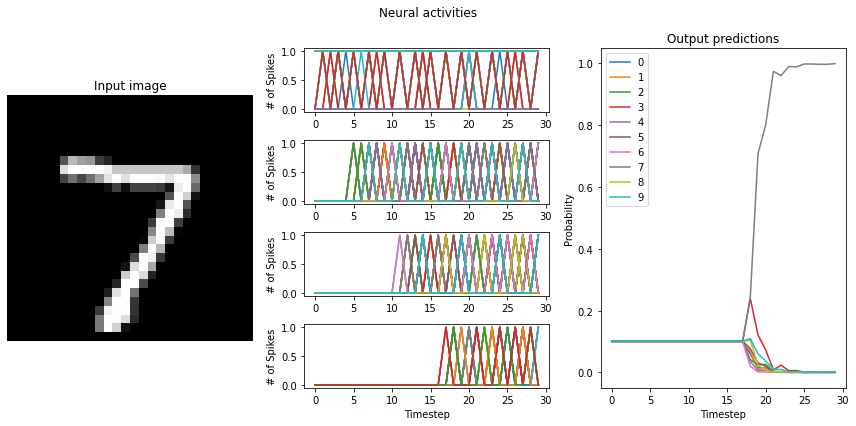

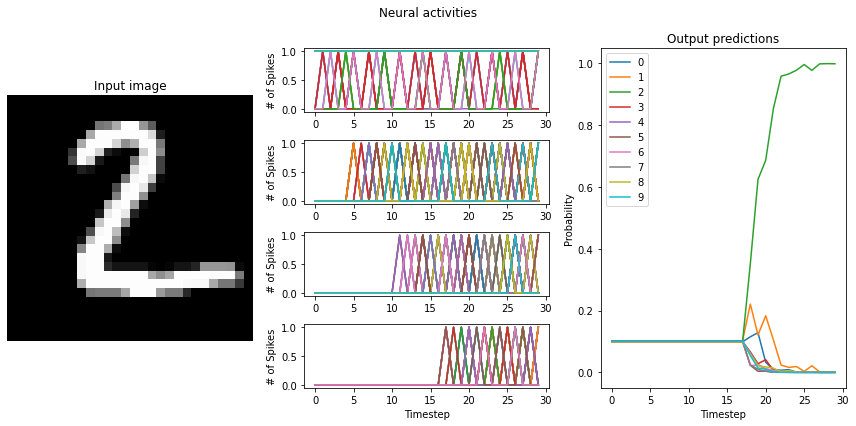

In [13]:
# test the trained networks using spiking neurons
run_network(
    activation=nengo_loihi.neurons.LoihiSpikingRectifiedLinear(),
    scale_firing_rates=100,
    params_file="./keras_to_loihi_loihineuron_params",
    synapse=0.005,
)

This is another way that we can recover normal ReLU performance using Loihi neurons.

As discussed in the [Keras to SNN
example](https://www.nengo.ai/nengo-dl/examples/keras-to-snn.html), we can also train up
this network using an extra term added to the loss function as a way of getting neurons
into the desired range of firing rates. This method has the benefit of being more
precise in the resultant firing rates of neurons in the network. When we set
`scale_firing_rates` to a large number during training, we're simply instantiating the
network with high firing rates and hoping it converges while maintaining these higher
firing rates, but there is no guarantee. Adding the rate regularization term to the loss
function ensures that the firing rates stay near their targets throughout the training
process.

## Running your SNN on Loihi

At this point we're ready to test out our network on the Loihi. To actually run it on
Loihi we have to set up a few more configuration parameters.

We'll start by converting our network same as before, using the same parameters on the
Converter call:

In [14]:
pres_time = 0.03  # how long to present each input, in seconds
n_test = 5  # how many images to test

# convert the keras model to a nengo network
nengo_converter = nengo_dl.Converter(
    model,
    scale_firing_rates=400,
    swap_activations={tf.nn.relu: nengo_loihi.neurons.LoihiSpikingRectifiedLinear()},
    synapse=0.005,
)
net = nengo_converter.net

# get input/output objects
nengo_input = nengo_converter.inputs[inp]
nengo_output = nengo_converter.outputs[dense1]

The next thing we need to do is load in the trained parameters. This involves creating a
NengoDL Simulator, loading in the weights, and then calling the
[`freeze_params`](https://www.nengo.ai/nengo-dl/reference.html#nengo_dl.Simulator.freeze_params)
function to save the weights to the network object. This will then let us build a
network with the trained weights inside the NengoLoihi Simulator.

In [15]:
# build network, load in trained weights, save to network
with nengo_dl.Simulator(net) as nengo_sim:
    nengo_sim.load_params("keras_to_loihi_loihineuron_params")
    nengo_sim.freeze_params(net)

|                     Building network (0%)                    | ETA:  --:--:--

|########             Building network (13%)                     | ETA: 0:00:00

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (35%)             | ETA: 0:00:00

|##############Constructing graph: build stage (70%)             | ETA: 0:00:00

Constructing graph: build stage finished in 0:00:00                            

|   #                     Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

Before we build the network in NengoLoihi we need to make a few more changes.

The `input` Node needs to altered to generate our test images as output:

In [16]:
with net:
    nengo_input.output = nengo.processes.PresentInput(
        test_images, presentation_time=pres_time
    )

We specify that the `to_spikes` layer should run off-chip:

In [17]:
with net:
    nengo_loihi.add_params(net)  # allow on_chip to be set
    net.config[nengo_converter.layers[to_spikes].ensemble].on_chip = False

At this point, if you try to build the network you will get an error
>BuildError: Total synapse bits (1103808) exceeded max (1048576)

which means that too many connections are going into a single Loihi core. To fix this,
we need to specify the `block_shape` parameter on the convnet layers that are running on
the Loihi. This lets us break up our convnet layer across multiple cores and prevent us
from overloading a single core. The first parameter specifies the target size of the
representation per core with a (`rows`, `columns`, `channels`) tuple. The max neurons
per core is 1024, so `rows * columns * channels` must be less than 1024.

The second parameter is the size of the full layer. This [can be
calculated](https://en.wikipedia.org/wiki/Convolutional_neural_network#Convolutional_layer)
with the `input_size`, `kernel_size`, `strides`, and `filters` parameters for the layer.
We do this in the `calculate_size` function below.

These parameters need to be tuned until the synapse and axon constraints are met. More
details on `block_shape` can be found in the [`BlockShape`
documentation](https://www.nengo.ai/nengo-loihi/api.html#nengo_loihi.BlockShape), with
details about how to choose good block shapes in the [tips and tricks
section](https://www.nengo.ai/nengo-loihi/tips.html#splitting-large-ensembles) of the
documentation and in the [CIFAR-10 Loihi
example](https://www.nengo.ai/nengo-loihi/examples/cifar10-convnet.html).

For this example, we are using the `(16, 16, 4)` for `conv0`, `(8, 8, 16)` for `conv1`,
and `(50,)` for our `dense0` (which breaks it up into two 50 neuron ensembles) to fit
our model on Loihi.

In [18]:
with net:
    conv0_shape = conv0_layer.output_shape[1:]
    net.config[
        nengo_converter.layers[conv0].ensemble
    ].block_shape = nengo_loihi.BlockShape((16, 16, 4), conv0_shape)

    conv1_shape = conv1_layer.output_shape[1:]
    net.config[
        nengo_converter.layers[conv1].ensemble
    ].block_shape = nengo_loihi.BlockShape((8, 8, 16), conv1_shape)

    dense0_shape = dense0_layer.output_shape[1:]
    net.config[
        nengo_converter.layers[dense0].ensemble
    ].block_shape = nengo_loihi.BlockShape((50,), dense0_shape)

Now we're ready to build the network and run it!

In [19]:
# build NengoLoihi Simulator and run network
with nengo_loihi.Simulator(net) as loihi_sim:
    loihi_sim.run(n_test * pres_time)

    # get output (last timestep of each presentation period)
    pres_steps = int(round(pres_time / loihi_sim.dt))
    output = loihi_sim.data[nengo_output][pres_steps - 1 :: pres_steps]

    # compute the Loihi accuracy
    loihi_predictions = np.argmax(output, axis=-1)
    correct = 100 * np.mean(loihi_predictions == test_labels[:n_test, 0, 0])
    print("Loihi accuracy: %.2f%%" % correct)

Loihi accuracy: 100.00%


Our accuracy print-out is 100%, and we can also plot the results to see for ourselves:

Text(0, 0.5, 'Probability')

<Figure size 864x288 with 0 Axes>

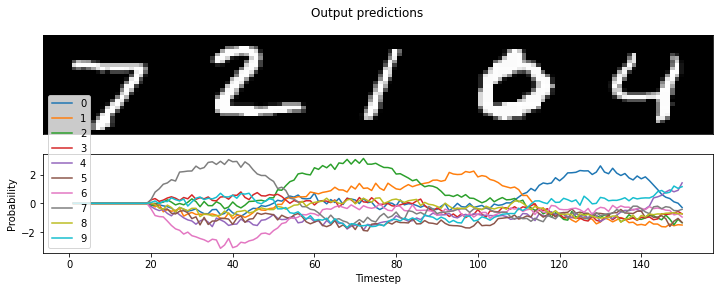

In [20]:
# plot the neural activity of the convnet layers
plt.figure(figsize=(12, 4))

timesteps = loihi_sim.trange() / loihi_sim.dt

# plot the presented MNIST digits
plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
images = test_images.reshape(-1, 28, 28, 1)[:n_test]
ni, nj, nc = images[0].shape
allimage = np.zeros((ni, nj * n_test, nc), dtype=images.dtype)
for i, image in enumerate(images[:n_test]):
    allimage[:, i * nj : (i + 1) * nj] = image
if allimage.shape[-1] == 1:
    allimage = allimage[:, :, 0]
plt.imshow(allimage, aspect="auto", interpolation="none", cmap="gray")
plt.xticks([])
plt.yticks([])

# plot the network predictions
plt.subplot(2, 1, 2)
plt.plot(timesteps, loihi_sim.data[nengo_output])
plt.legend(["%d" % i for i in range(10)], loc="lower left")
plt.suptitle("Output predictions")
plt.xlabel("Timestep")
plt.ylabel("Probability")

## Conclusions

In this example we've expanded on the process of converting a Keras model to an SNN with
additional considerations that are important for SNN's we want to implement on the
Loihi. We then showed the additional steps required to prepare a network generated by
the NengoDL Converter to run on Loihi, including modifying the input node and specifying
the distribution of convnet layers across cores.